# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [17]:
# Read and save test images to array

import os
os.listdir("test_images/")

def read_image(image_path):
    return mpimg.imread(image_path)

test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

In [3]:
def read_image_and_print_dims(image_path):
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


array([[[180, 196, 209],
        [142, 161, 176],
        [134, 156, 179],
        ..., 
        [136, 154, 178],
        [146, 159, 176],
        [186, 195, 210]],

       [[142, 161, 176],
        [143, 166, 184],
        [134, 160, 183],
        ..., 
        [137, 159, 183],
        [142, 159, 179],
        [148, 161, 178]],

       [[131, 158, 179],
        [133, 161, 183],
        [128, 159, 187],
        ..., 
        [129, 156, 185],
        [136, 158, 182],
        [134, 152, 176]],

       ..., 
       [[120, 121, 125],
        [ 91,  92,  97],
        [ 83,  84,  89],
        ..., 
        [ 88,  89,  93],
        [ 94,  95,  99],
        [120, 121, 125]],

       [[138, 139, 143],
        [105, 106, 110],
        [ 89,  90,  95],
        ..., 
        [ 97,  98, 102],
        [109, 110, 114],
        [139, 140, 144]],

       [[180, 181, 185],
        [140, 141, 145],
        [117, 118, 123],
        ..., 
        [122, 123, 125],
        [140, 141, 143],
        [179, 180,

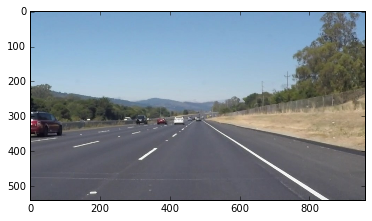

In [4]:
read_image_and_print_dims('test_images/solidWhiteRight.jpg')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [41]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    # print("Hough lines: ", lines)
    line_img = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [111]:
def find_linear_regression_line(points):
    # Separate points into X and y to fit LinearRegression model
    points_x = [[point[0]] for point in points]
    points_y = [point[1] for point in points]
    # points_x_print = [point[0] for point in points]
    # print("X points: ", points_x, "Length: ", len(points_x))
    # print("X points: ", points_x_print, "Length: ", len(points_x))
    # print("Y points: ", points_y, "Length: ", len(points_y))

    # Fit points to LinearRegression line
    clf = LinearRegression().fit(points_x, points_y)

    # Get parameters from line
    coef = clf.coef_[0]
    intercept = clf.intercept_
    print("Coefficients: ", coef, "Intercept: ", intercept)
    return coef, intercept

def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)

In [177]:
def find_line_fit(positive_slope_intercept):
    """positive_slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""
    
    # Initialise arrays
    kept_positive_slopes = []
    kept_positive_intercepts = []
    print("Slope & intercept: ", positive_slope_intercept)
    if len(positive_slope_intercept) == 1:
        return positive_slope_intercept[0][0], positive_slope_intercept[0][1]
    # Remove 5% percentile on each side
    # positive_slope_intercept = sorted(positive_slope_intercept)
    positive_slopes = [pair[0] for pair in positive_slope_intercept]
    positive_intercepts = [pair[1] for pair in positive_slope_intercept]
    mean_slope = np.mean(positive_slopes)
    slope_std = np.std(positive_slopes)
    for pair in positive_slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5*slope_std:
            kept_positive_slopes.append(slope)
            kept_positive_intercepts.append(pair[1])
    
    # Take estimate to be the mean of remaining values
    positive_slope = np.mean(kept_positive_slopes)
    positive_intercept = np.mean(kept_positive_intercepts)
    print("Positive slope: ", positive_slope, "Positive intercept: ", positive_intercept)
    return positive_slope, positive_intercept

In [173]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # middle_point = [(x1+x2)/2, (y1+y2)/2]
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        # positive_slope_points.append(middle_point)
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        # negative_slope_points.append(middle_point)
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
                if not positive_slope_points:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                elif not negative_slope_points:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    print("positive slope line points: ", positive_slope_points)
    print("negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    # Get intercept and coefficient of linear regression lines
    # pos_coef, pos_intercept = find_linear_regression_line(positive_slope_points)
    # neg_coef, neg_intercept = find_linear_regression_line(negative_slope_points)
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

In [164]:
array = []
if not array:
    print("Empty array")
else:
    print("Not empty array")

Empty array


Positive slope:  0.564152709349 Positive intercept:  37.3004566564
Positive slope:  -0.768295476236 Positive intercept:  678.75027465
Point one:  (481, 308) Point two:  (960, 578)
Point one:  (481, 308) Point two:  (0, 678)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

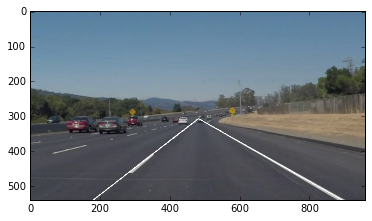

In [170]:
# Pipeline

def draw_lane_lines(image):
    """Draw lane lines in white on original image."""
    # Print image details
    # print("image.shape: ", image.shape)
    imshape = image.shape
    
    # Greyscale image
    greyscaled_image = grayscale(image)
    # plt.imshow(greyscaled_image, cmap="gray")
    # print("Greyscaled image dims: ", greyscaled_image.shape)
    
    # Gaussian Blur
    blurred_grey_image = gaussian_blur(greyscaled_image, 5)
    
    # Canny edge detection
    edges_image = canny(blurred_grey_image, 50, 150)
    # (80,540),(460, 280), (490, 280), (900,540)
    
    # Mask image
    border = 0
    vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edges_image, vertices)
    # plt.subplot(2,1,1)
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    plt.imshow(bw_edges_image_with_mask)
    
    # Hough lines
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 20 #minimum number of pixels making up a line
    max_line_gap = 40    # maximum gap in pixels between connectable line segments
    lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
    # print("Hough output image.shape: ", lines_image.shape)
    # plt.imshow(lines_image)
    # print("lines_image: ", lines_image)
    
    # Convert Hough from single channel to RGB to prep for weighted
    # TODO: Have it convert the lines to red, not white.
    hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    print("hough_rgb.shape: ", hough_rgb_image.shape)
    # plt.imshow(hough_rgb_image)
    
    print("hough_rgb.type: ", hough_rgb_image.dtype)
    # print(hough_rgb_image)
    
    # Combine lines image with original image
    final_image = weighted_img(hough_rgb_image, image)
    # plt.subplot(2,1,2)
    plt.imshow(final_image)
    return final_image
    # plt.show()

draw_lane_lines(test_images[0])

Points:  [583, 369, 877, 538]
Length:  339.11207586873104
Points:  [626, 388, 898, 538]
Length:  310.61873736141547
Points:  [292, 462, 461, 325]
Length:  217.55459085020476
Points:  [280, 460, 460, 324]
Length:  225.6014184352572
Points:  [651, 401, 897, 537]
Length:  281.0907326825273
Points:  [588, 371, 872, 535]
Length:  327.95121588431414
Points:  [307, 439, 462, 322]
Length:  194.20092687729377
Points:  [351, 410, 468, 322]
Length:  146.40013661195812
Points:  [318, 440, 342, 421]
Points:  [281, 460, 305, 442]
Points:  [441, 343, 469, 322]
positive slope line points:  [[ 730.   453.5]
 [ 762.   463. ]
 [ 774.   469. ]
 [ 730.   453. ]]
negative slope line points:  [[ 376.5  393.5]
 [ 370.   392. ]
 [ 384.5  380.5]
 [ 409.5  366. ]]
positive slope points dtype:  float64
dtype printed
X points:  [[730.0], [762.0], [774.0], [730.0]] Length:  4
X points:  [730.0, 762.0, 774.0, 730.0] Length:  4
Y points:  [453.5, 463.0, 469.0, 453.0] Length:  4
Coefficients:  0.343337730871 Intercept

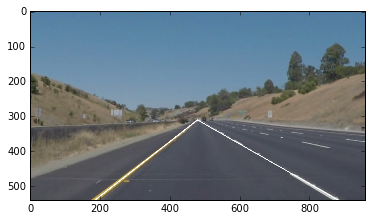

In [66]:
for image in test_images:
    draw_lane_lines(image)

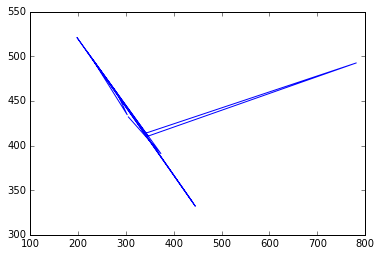

In [59]:
plt.plot([305.0, 373.0, 229.0, 302.5, 281.5, 197.5, 445.0, 339.5, 781.5, 346.0, 217.0, 439.5],
         [432.0, 391.0, 497.5, 434.5, 458.5, 521.0, 332.0, 413.5, 492.5, 410.5, 506.5, 336.5])
plt.show()

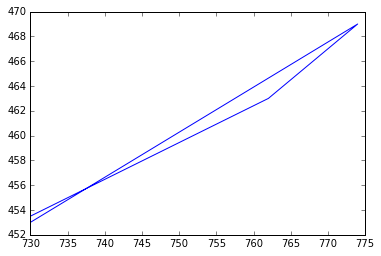

In [102]:
plt.plot([730.0, 762.0, 774.0, 730.0],[453.5, 463.0, 469.0, 453.0])
plt.show()

In [52]:
plt.plot([[ 613.5  396.5]
 [ 603.   386.5]
 [ 627.   406. ]
 [ 592.   379.5]
 [ 780.   492.5]
 [ 567.   364. ]])

SyntaxError: invalid syntax (<ipython-input-52-d00a7c1ad464>, line 1)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [12]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [15]:
def read_image(image_path):
    return mpimg.imread(image_path)

run your solution on all test_images and make copies into the test_images directory).

### Pipeline

Steps:
1. Read in and grayscale the image
2. Define a kernel size and apply Gaussian smoothing
3. Define our parameters for Canny and apply to get edges image
4. Mask edges image using cv2.fillPoly() (ignore everything outside region of interest)
5. Define Hough transform parameters and run Hough transform on masked edge-detected image
6. Draw lines

In [237]:
# Read image
image_path = 'test_images/solidWhiteCurve.jpg'
# image = read_image_and_print_dims(image_path)
image = mpimg.imread(image_path)

In [48]:
image = test_images[3]

image.shape:  (540, 960, 3)
Greyscaled image dims:  (540, 960)


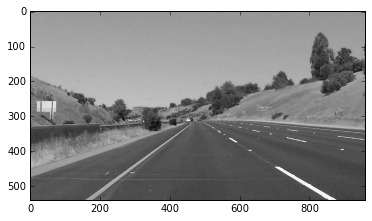

In [49]:
print("image.shape: ", image.shape)
imshape = image.shape
greyscaled_image = grayscale(image)
plt.imshow(greyscaled_image, cmap="gray")
print("Greyscaled image dims: ", greyscaled_image.shape)

Hough output image.shape:  (540, 960)


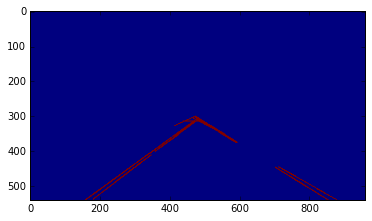

In [205]:
blurred_grey_image = gaussian_blur(greyscaled_image, 5)
edges_image = canny(blurred_grey_image, 50, 150)
# (80,540),(460, 280), (490, 280), (900,540)
vertices = np.array([[(0,imshape[0]),(465, 300), (475, 300), (imshape[1],imshape[0])]], dtype=np.int32)
edges_image_with_mask = region_of_interest(edges_image, vertices)
rho = 2 # distance resolution in pixels of the Hough grid

theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 15     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 20    # maximum gap in pixels between connectable line segments
lines_image = hough_lines(edges_image_with_mask, rho, theta, threshold, min_line_len, max_line_gap)
print("Hough output image.shape: ", lines_image.shape)
plt.imshow(lines_image)

hough_rgb.shape:  (540, 960, 3)


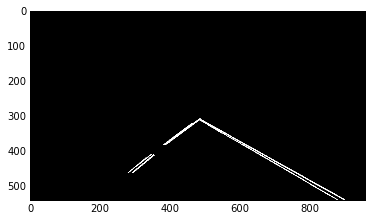

In [10]:
hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
print("hough_rgb.shape: ", hough_rgb_image.shape)
plt.imshow(hough_rgb_image)

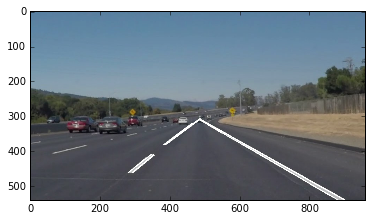

In [11]:
final_image = weighted_img(hough_rgb_image, image)
plt.imshow(final_image)

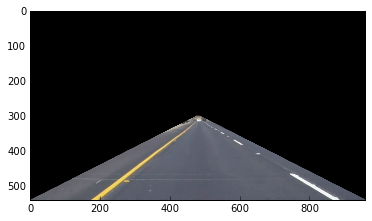

In [134]:
border = 80
vertices = np.array([[(0,imshape[0]),(475, 300), (485, 300), 
                      (imshape[1],imshape[0])]], 
                    dtype=np.int32)    
plt.imshow(region_of_interest(test_images[5], vertices))

In [189]:
help(cv2.fitLine)

Help on built-in function fitLine:

fitLine(...)
    fitLine(points, distType, param, reps, aeps[, line]) -> line



In [ ]:
filename = str()
cv2.imwrite(filename, img[, params])

In [14]:
def read_image(image_path):
    return mpimg.imread(image_path)

In [21]:
image_path = 'test_images/solidWhiteCurve.jpg'

Positive slope:  0.564152709349 Positive intercept:  37.3004566564
Positive slope:  -0.768295476236 Positive intercept:  678.75027465
Point one:  (481, 308) Point two:  (960, 578)
Point one:  (481, 308) Point two:  (0, 678)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 82, 118, 151]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       [[ 87, 126, 159],
        [ 87, 126, 159],
        [ 87, 126, 159],
        ..., 
        [ 89, 125, 158],
        [ 86, 122, 155],
        [ 83, 119, 152]],

       ..., 
       [[ 68,  70,  76],
        [ 68,  70,  76],
        [ 68,  70,  76],
        ..., 
        [ 65,  65,  73],
        [ 64,  64,  72],
        [ 63,  63,  71]],

       [[ 69,  69,  75],
        [ 69,  69,  75],
        [ 70,  70,  76],
        ..., 
        [ 62,  64,  71],
        [ 62,  64,  71],
        [ 61,  63,  70]],

       [[ 67,  67,  74],
        [ 67,  67,  74],
        [ 67,  67,  74],
        ..., 
        [ 61,  62,  72],
        [ 60,  62,  71],
        [ 59,  61,

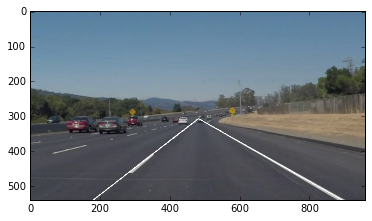

In [155]:
draw_lane_lines(test_images[0])

Positive slope:  0.634908963585 Positive intercept:  1.02712630507
Positive slope:  -0.693779967159 Positive intercept:  642.933479853
Point one:  (483, 307) Point two:  (960, 610)
Point one:  (483, 307) Point two:  (0, 642)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[144, 157, 167],
        [114, 129, 141],
        [107, 125, 143],
        ..., 
        [109, 123, 142],
        [117, 127, 141],
        [149, 156, 168]],

       [[114, 129, 141],
        [114, 133, 147],
        [107, 128, 146],
        ..., 
        [110, 127, 146],
        [114, 127, 143],
        [118, 129, 142]],

       [[105, 126, 143],
        [106, 129, 146],
        [102, 127, 150],
        ..., 
        [103, 125, 148],
        [109, 126, 146],
        [107, 122, 141]],

       ..., 
       [[ 96,  97, 100],
        [ 73,  74,  78],
        [ 66,  67,  71],
        ..., 
        [ 70,  71,  74],
        [ 75,  76,  79],
        [ 96,  97, 100]],

       [[110, 111, 114],
        [ 84,  85,  88],
        [ 71,  72,  76],
        ..., 
        [ 78,  78,  82],
        [ 87,  88,  91],
        [111, 112, 115]],

       [[144, 145, 148],
        [112, 113, 116],
        [ 94,  94,  98],
        ..., 
        [ 98,  98, 100],
        [112, 113, 114],
        [143, 144,

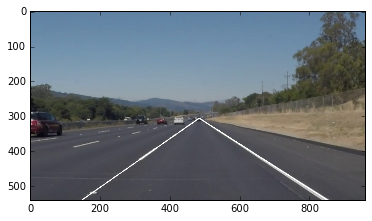

In [156]:
draw_lane_lines(test_images[1])

Positive slope:  0.574621212121 Positive intercept:  42.0287878788
Positive slope:  -0.748439252763 Positive intercept:  667.039620534
Point one:  (472, 313) Point two:  (960, 593)
Point one:  (472, 313) Point two:  (0, 667)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[ 82, 125, 162],
        [ 82, 125, 162],
        [ 82, 125, 162],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 125, 160],
        [ 82, 125, 160],
        [ 82, 125, 160],
        ..., 
        [ 77, 122, 157],
        [ 75, 121, 155],
        [ 70, 116, 150]],

       [[ 82, 126, 158],
        [ 82, 126, 158],
        [ 82, 126, 158],
        ..., 
        [ 78, 122, 157],
        [ 77, 120, 155],
        [ 72, 115, 150]],

       ..., 
       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 58,  63,  74],
        [ 58,  63,  74],
        [ 58,  63,  74]],

       [[ 76,  80,  85],
        [ 76,  80,  85],
        [ 76,  80,  85],
        ..., 
        [ 57,  62,  73],
        [ 57,  62,  73],
        [ 57,  62,  73]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 58,  62,  71],
        [ 58,  62,  71],
        [ 58,  62,

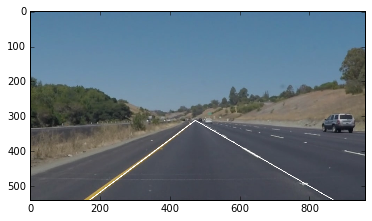

In [157]:
draw_lane_lines(test_images[2])

Positive slope:  0.596914008704 Positive intercept:  23.8442964492
Positive slope:  -0.755808990722 Positive intercept:  670.486567955
Point one:  (478, 309) Point two:  (960, 596)
Point one:  (478, 309) Point two:  (0, 670)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 78, 125, 160],
        [ 76, 123, 158],
        [ 74, 122, 157]],

       [[ 83, 126, 162],
        [ 83, 126, 162],
        [ 83, 126, 162],
        ..., 
        [ 77, 124, 159],
        [ 75, 122, 158],
        [ 72, 121, 156]],

       [[ 82, 126, 161],
        [ 83, 126, 162],
        [ 82, 127, 162],
        ..., 
        [ 75, 124, 159],
        [ 74, 122, 158],
        [ 72, 121, 156]],

       ..., 
       [[ 82,  82,  88],
        [ 82,  82,  88],
        [ 82,  82,  88],
        ..., 
        [ 62,  66,  74],
        [ 62,  66,  74],
        [ 62,  66,  74]],

       [[ 82,  81,  87],
        [ 82,  81,  87],
        [ 82,  81,  87],
        ..., 
        [ 62,  66,  73],
        [ 62,  65,  72],
        [ 62,  65,  72]],

       [[ 79,  78,  85],
        [ 79,  78,  85],
        [ 79,  78,  85],
        ..., 
        [ 62,  65,  72],
        [ 62,  65,  72],
        [ 62,  65,

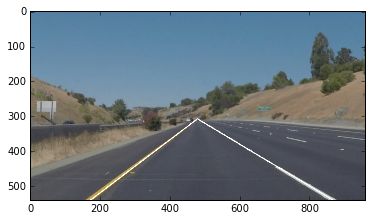

In [158]:
draw_lane_lines(test_images[3])

Positive slope:  0.621711758416 Positive intercept:  9.78511680196
Positive slope:  -0.718822448134 Positive intercept:  647.919520883
Point one:  (476, 305) Point two:  (960, 606)
Point one:  (476, 305) Point two:  (0, 647)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[147, 157, 168],
        [115, 127, 142],
        [106, 123, 142],
        ..., 
        [102, 122, 141],
        [112, 129, 142],
        [146, 159, 171]],

       [[114, 126, 142],
        [115, 130, 147],
        [106, 125, 146],
        ..., 
        [ 99, 123, 144],
        [110, 127, 144],
        [113, 128, 142]],

       [[105, 122, 141],
        [106, 125, 146],
        [100, 123, 147],
        ..., 
        [ 94, 120, 145],
        [ 98, 120, 142],
        [100, 121, 139]],

       ..., 
       [[103, 102, 107],
        [ 92,  91,  96],
        [ 88,  87,  92],
        ..., 
        [ 66,  66,  74],
        [ 70,  70,  78],
        [ 95,  95, 103]],

       [[113, 112, 116],
        [100,  99, 103],
        [ 92,  91,  95],
        ..., 
        [ 70,  70,  78],
        [ 85,  85,  91],
        [109, 109, 115]],

       [[141, 140, 144],
        [111, 110, 114],
        [102, 102, 106],
        ..., 
        [ 95,  95, 102],
        [110, 110, 116],
        [146, 146,

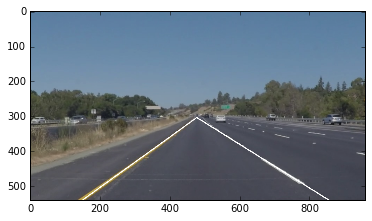

In [159]:
draw_lane_lines(test_images[4])

Positive slope:  0.569934717392 Positive intercept:  39.2694669039
Positive slope:  -0.756224176635 Positive intercept:  678.072958802
Point one:  (481, 313) Point two:  (960, 586)
Point one:  (481, 313) Point two:  (0, 678)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

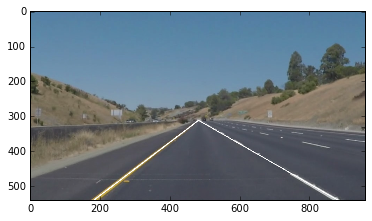

In [160]:
draw_lane_lines(test_images[5])

In [120]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [10]:
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]

NameError: name 'os' is not defined

Coefficients:  0.592537726844 Intercept:  26.7315865015
Coefficients:  -0.715154605472 Intercept:  653.886663723
Point one:  (479, 310) Point two:  (960, 595)
Point one:  (479, 310) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


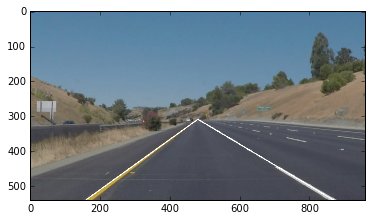

In [121]:
draw_lane_lines(test_images[3])

In [228]:
img = cv2.imread('golden_five_pointed_star.jpg', 0)
print("img: ", img)
# img is src
#  threshold(src, thresh, maxval, type[, dst]) -> retval, dst
ret, thresh = cv2.threshold(img, 127, 255, 0)
# ret is retval
print("ret: ", ret)
# thresh is dst
print("thresh: ", thresh)
image, contours, hierarchy = cv2.findContours(thresh, 1, 2)
print("contours: ", contours)
print("hierarchy: ", hierarchy)
cnt = contours[0]
M = cv2.moments(cnt)
print("moments: ", M)

img:  [[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
ret:  127.0
thresh:  [[255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 ..., 
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]
 [255 255 255 ..., 255 255 255]]
contours:  [array([[[209, 311]],

       [[207, 313]],

       [[206, 313]],

       [[204, 315]],

       [[203, 315]],

       [[200, 318]],

       [[199, 318]],

       [[197, 320]],

       [[196, 320]],

       [[194, 322]],

       [[193, 322]],

       [[191, 324]],

       [[190, 324]],

       [[187, 327]],

       [[186, 327]],

       [[184, 329]],

       [[183, 329]],

       [[181, 331]],

       [[180, 331]],

       [[177, 334]],

       [[176, 334]],

       [[174, 336]],

       [[173, 336]],

       [[171, 338]],

       [[170, 338]],

       [[16

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [122]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [123]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = draw_lane_lines(image)
    print(result.shape)
    return result

Coefficients:  0.570339671771 Intercept:  38.6318800616
Coefficients:  -0.76578262862 Intercept:  681.136171765
Point one:  (480, 312) Point two:  (960, 586)
Point one:  (480, 312) Point two:  (0, 681)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


array([[[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       [[ 88, 127, 162],
        [ 88, 127, 162],
        [ 88, 127, 162],
        ..., 
        [ 81, 124, 161],
        [ 80, 123, 160],
        [ 75, 118, 155]],

       ..., 
       [[ 76,  80,  85],
        [ 75,  79,  84],
        [ 75,  79,  84],
        ..., 
        [ 67,  70,  82],
        [ 66,  68,  80],
        [ 63,  66,  78]],

       [[ 75,  79,  84],
        [ 75,  79,  84],
        [ 74,  78,  83],
        ..., 
        [ 67,  70,  80],
        [ 66,  69,  78],
        [ 62,  66,  75]],

       [[ 72,  78,  82],
        [ 71,  77,  82],
        [ 71,  77,  82],
        ..., 
        [ 66,  70,  79],
        [ 65,  68,  78],
        [ 62,  66,

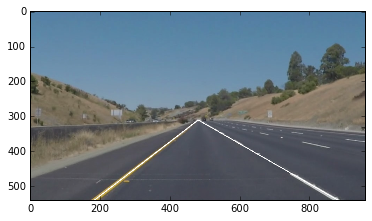

In [126]:
process_image(image)


Let's try the one with the solid white lane on the right first ...

Positive slope:  0.626108962272 Positive intercept:  2.91539595246
Positive slope:  -0.743359422281 Positive intercept:  658.93296864
Point one:  (479, 302) Point two:  (960, 603)
Point one:  (479, 302) Point two:  (0, 658)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  1%|▏         | 3/222 [00:00<00:09, 23.06it/s]

Positive slope:  0.626108962272 Positive intercept:  2.91539595246
Positive slope:  -0.743359422281 Positive intercept:  658.93296864
Point one:  (479, 302) Point two:  (960, 603)
Point one:  (479, 302) Point two:  (0, 658)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.620219445396 Positive intercept:  5.905146483
Positive slope:  -0.742430998309 Positive intercept:  658.69356929
Point one:  (479, 303) Point two:  (960, 601)
Point one:  (479, 303) Point two:  (0, 658)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.633461974185 Positive intercept:  -1.4164128932
Positive slope:  -0.721600332969 Positive intercept:  651.821832546
Point one:  (482, 303) Point two:  (960, 606)
Point one:  (482, 303) Point two:  (0, 651)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.612659347415 Positive intercept:  13.2514990836
Positive slope:  -0.748876986645 Positive intercept:  6

  3%|▎         | 6/222 [00:00<00:09, 22.85it/s]

Positive slope:  0.615145560252 Positive intercept:  11.5811816025
Positive slope:  -0.72445372997 Positive intercept:  650.74379776
Point one:  (477, 305) Point two:  (960, 602)
Point one:  (477, 305) Point two:  (0, 650)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.612762330772 Positive intercept:  12.3287947578
Positive slope:  -0.740486746758 Positive intercept:  656.942753065
Point one:  (476, 304) Point two:  (960, 600)
Point one:  (476, 304) Point two:  (0, 656)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.609301028761 Positive intercept:  11.3061045353
Positive slope:  -0.70236985096 Positive intercept:  642.18307298
Point one:  (480, 304) Point two:  (960, 596)
Point one:  (480, 304) Point two:  (0, 642)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.612550573468 Positive intercept:  12.5577662864
Positive slope:  -0.734240351608 Positive intercept:  6

  4%|▍         | 9/222 [00:00<00:09, 23.20it/s]

(540, 960, 3)
Positive slope:  0.614016761128 Positive intercept:  13.2193693693
Positive slope:  -0.714207913707 Positive intercept:  649.813350237
Point one:  (479, 307) Point two:  (960, 602)
Point one:  (479, 307) Point two:  (0, 649)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


  5%|▌         | 12/222 [00:00<00:09, 23.03it/s]

Positive slope:  0.623179450912 Positive intercept:  10.2380571537
Positive slope:  -0.713099823726 Positive intercept:  650.722373497
Point one:  (479, 308) Point two:  (960, 608)
Point one:  (479, 308) Point two:  (0, 650)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.632700235403 Positive intercept:  5.23489137249
Positive slope:  -0.740300469229 Positive intercept:  659.498817537
Point one:  (476, 306) Point two:  (960, 612)
Point one:  (476, 306) Point two:  (0, 659)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.636317740078 Positive intercept:  3.2940290599
Positive slope:  -0.700510041517 Positive intercept:  645.049461843
Point one:  (480, 308) Point two:  (960, 614)
Point one:  (480, 308) Point two:  (0, 645)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.606629915563 Positive intercept:  19.3631581463
Positive slope:  -0.728198561504 Positive intercept:

  7%|▋         | 15/222 [00:00<00:08, 23.53it/s]

Positive slope:  0.584833375307 Positive intercept:  32.4721317851
Positive slope:  -0.736999679035 Positive intercept:  654.088941618
Point one:  (470, 307) Point two:  (960, 593)
Point one:  (470, 307) Point two:  (0, 654)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


  8%|▊         | 18/222 [00:00<00:08, 23.11it/s]

Positive slope:  0.659564393939 Positive intercept:  -15.3252840909
Positive slope:  -0.712817923321 Positive intercept:  642.025149652
Point one:  (478, 300) Point two:  (960, 617)
Point one:  (478, 300) Point two:  (0, 642)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.632787672881 Positive intercept:  -1.21695960419
Positive slope:  -0.71010884156 Positive intercept:  643.168367792
Point one:  (479, 302) Point two:  (960, 606)
Point one:  (479, 302) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.652457786136 Positive intercept:  -13.3864848337
Positive slope:  -0.688302277433 Positive intercept:  634.192106625
Point one:  (482, 301) Point two:  (960, 612)
Point one:  (482, 301) Point two:  (0, 634)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.639372354735 Positive intercept:  0.385121800302
Positive slope:  -0.722556089744 Positive interc

  9%|▉         | 21/222 [00:00<00:08, 23.37it/s]

Positive slope:  0.638293498176 Positive intercept:  1.65623172807
Positive slope:  -0.695269375368 Positive intercept:  642.375610349
Point one:  (480, 308) Point two:  (960, 614)
Point one:  (480, 308) Point two:  (0, 642)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.629939152238 Positive intercept:  5.87461689911
Positive slope:  -0.675500480074 Positive intercept:  634.485128635
Point one:  (481, 309) Point two:  (960, 610)
Point one:  (481, 309) Point two:  (0, 634)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.636481621049 Positive intercept:  1.36485395543
Positive slope:  -0.713143667289 Positive intercept:  649.144191465
Point one:  (479, 306) Point two:  (960, 612)
Point one:  (479, 306) Point two:  (0, 649)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.650367595368 Positive intercept:  -8.86709364709
Positive slope:  -0.724627118718 Positive intercep

 11%|█         | 24/222 [00:01<00:08, 23.60it/s]

(540, 960, 3)
Positive slope:  0.636203433713 Positive intercept:  0.792276296889
Positive slope:  -0.737048427737 Positive intercept:  656.768769923
Point one:  (477, 304) Point two:  (960, 611)
Point one:  (477, 304) Point two:  (0, 656)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 12%|█▏        | 27/222 [00:01<00:08, 23.98it/s]

Positive slope:  0.651822868919 Positive intercept:  -9.61491279506
Positive slope:  -0.72418092755 Positive intercept:  653.655906998
Point one:  (482, 304) Point two:  (960, 616)
Point one:  (482, 304) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.637402986541 Positive intercept:  1.16335627974
Positive slope:  -0.698047643055 Positive intercept:  643.67793112
Point one:  (481, 307) Point two:  (960, 613)
Point one:  (481, 307) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.638472786518 Positive intercept:  0.013478879241
Positive slope:  -0.71023713921 Positive intercept:  647.804903393
Point one:  (480, 306) Point two:  (960, 612)
Point one:  (480, 306) Point two:  (0, 647)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.639129640503 Positive intercept:  -1.14597929572
Positive slope:  -0.73008511567 Positive intercept:

 14%|█▎        | 30/222 [00:01<00:07, 24.38it/s]

(540, 960, 3)
Positive slope:  0.63685748113 Positive intercept:  0.40606886049
Positive slope:  -0.726463761605 Positive intercept:  653.780023959
Point one:  (479, 305) Point two:  (960, 611)
Point one:  (479, 305) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 15%|█▍        | 33/222 [00:01<00:07, 24.59it/s]

(540, 960, 3)
Positive slope:  0.63606501893 Positive intercept:  -1.19348630199
Positive slope:  -0.708963231524 Positive intercept:  645.556335604
Point one:  (480, 304) Point two:  (960, 609)
Point one:  (480, 304) Point two:  (0, 645)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.635726033473 Positive intercept:  -1.67406174564
Positive slope:  -0.714377393275 Positive intercept:  646.931693195
Point one:  (480, 303) Point two:  (960, 608)
Point one:  (480, 303) Point two:  (0, 646)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.601933561705 Positive intercept:  21.2172559726
Positive slope:  -0.714426924967 Positive intercept:  648.955698217
Point one:  (476, 308) Point two:  (960, 599)
Point one:  (476, 308) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.63598314745 Positive intercept:  0.0482529709681
Positive slope:  -0.735902755186 Po

 18%|█▊        | 39/222 [00:01<00:07, 24.03it/s]

Positive slope:  0.642299233966 Positive intercept:  -0.930281700865
Positive slope:  -0.719938693821 Positive intercept:  651.244484213
Point one:  (478, 306) Point two:  (960, 615)
Point one:  (478, 306) Point two:  (0, 651)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.637847466689 Positive intercept:  0.640784487671
Positive slope:  -0.704027704531 Positive intercept:  646.142024068
Point one:  (481, 307) Point two:  (960, 612)
Point one:  (481, 307) Point two:  (0, 646)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.638261719965 Positive intercept:  0.0192835143905
Positive slope:  -0.743485448382 Positive intercept:  657.156340539
Point one:  (475, 303) Point two:  (960, 612)
Point one:  (475, 303) Point two:  (0, 657)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.627251147444 Positive intercept:  6.23156540852
Positive slope:  -0.732354026515 Positive inte

 19%|█▉        | 42/222 [00:01<00:07, 24.46it/s]

Positive slope:  0.643105829979 Positive intercept:  -5.0634641211
Positive slope:  -0.742163400345 Positive intercept:  657.304211939
Point one:  (478, 302) Point two:  (960, 612)
Point one:  (478, 302) Point two:  (0, 657)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.66388907426 Positive intercept:  -16.656608514
Positive slope:  -0.729804234667 Positive intercept:  650.899775568
Point one:  (478, 301) Point two:  (960, 620)
Point one:  (478, 301) Point two:  (0, 650)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.662865958947 Positive intercept:  -16.0414555061
Positive slope:  -0.731220515556 Positive intercept:  651.347729771
Point one:  (478, 301) Point two:  (960, 620)
Point one:  (478, 301) Point two:  (0, 651)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 20%|██        | 45/222 [00:01<00:07, 24.08it/s]

Positive slope:  0.657036343408 Positive intercept:  -11.9530267516
Positive slope:  -0.733331570156 Positive intercept:  652.289943663
Point one:  (477, 301) Point two:  (960, 618)
Point one:  (477, 301) Point two:  (0, 652)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.656168014619 Positive intercept:  -12.4205074273
Positive slope:  -0.725827257783 Positive intercept:  649.458449146
Point one:  (478, 301) Point two:  (960, 617)
Point one:  (478, 301) Point two:  (0, 649)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 22%|██▏       | 48/222 [00:02<00:07, 24.15it/s]

Positive slope:  0.655037098643 Positive intercept:  -11.7011934849
Positive slope:  -0.736073876589 Positive intercept:  653.252834636
Point one:  (478, 301) Point two:  (960, 617)
Point one:  (478, 301) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.648877490104 Positive intercept:  -8.2716546011
Positive slope:  -0.734204314547 Positive intercept:  652.222804381
Point one:  (477, 301) Point two:  (960, 614)
Point one:  (477, 301) Point two:  (0, 652)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.64867606718 Positive intercept:  -8.2076670479
Positive slope:  -0.740457050618 Positive intercept:  654.847557039
Point one:  (477, 301) Point two:  (960, 614)
Point one:  (477, 301) Point two:  (0, 654)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.615543912701 Positive intercept:  12.1248162212
Positive slope:  -0.718593070561 Positive intercept

 23%|██▎       | 51/222 [00:02<00:06, 24.59it/s]

(540, 960, 3)
Positive slope:  0.652953527195 Positive intercept:  -11.3098427522
Positive slope:  -0.699743431138 Positive intercept:  638.201335395
Point one:  (480, 302) Point two:  (960, 615)
Point one:  (480, 302) Point two:  (0, 638)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 24%|██▍       | 54/222 [00:02<00:06, 24.85it/s]

(540, 960, 3)
Positive slope:  0.622554338796 Positive intercept:  8.0192631148
Positive slope:  -0.739056962922 Positive intercept:  652.493839985
Point one:  (473, 302) Point two:  (960, 605)
Point one:  (473, 302) Point two:  (0, 652)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.65278360472 Positive intercept:  -9.52786676208
Positive slope:  -0.70689339498 Positive intercept:  640.952350705
Point one:  (478, 302) Point two:  (960, 617)
Point one:  (478, 302) Point two:  (0, 640)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.651333063454 Positive intercept:  -9.18123821196
Positive slope:  -0.702800487221 Positive intercept:  639.160793179
Point one:  (478, 302) Point two:  (960, 616)
Point one:  (478, 302) Point two:  (0, 639)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.633963093716 Positive intercept:  -0.200682418112
Positive slope:  -0.713955144451 Pos

 26%|██▌       | 57/222 [00:02<00:06, 24.90it/s]

Positive slope:  0.646224714343 Positive intercept:  -3.1786879788
Positive slope:  -0.67756950892 Positive intercept:  631.144342086
Point one:  (479, 306) Point two:  (960, 617)
Point one:  (479, 306) Point two:  (0, 631)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.63193591278 Positive intercept:  6.02501772556
Positive slope:  -0.669664103244 Positive intercept:  628.621996347
Point one:  (478, 308) Point two:  (960, 612)
Point one:  (478, 308) Point two:  (0, 628)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.630171644784 Positive intercept:  6.85262012495
Positive slope:  -0.677733545538 Positive intercept:  632.530110319
Point one:  (478, 308) Point two:  (960, 611)
Point one:  (478, 308) Point two:  (0, 632)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.659366102366 Positive intercept:  -12.4720852391
Positive slope:  -0.702085862133 Positive intercept:

 27%|██▋       | 60/222 [00:02<00:06, 24.53it/s]

(540, 960, 3)
Positive slope:  0.653830823208 Positive intercept:  -9.13700529455
Positive slope:  -0.687853505976 Positive intercept:  633.867199965
Point one:  (479, 304) Point two:  (960, 618)
Point one:  (479, 304) Point two:  (0, 633)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.656786859922 Positive intercept:  -11.8331309712
Positive slope:  -0.692577497477 Positive intercept:  638.372863043
Point one:  (481, 304) Point two:  (960, 618)
Point one:  (481, 304) Point two:  (0, 638)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 28%|██▊       | 63/222 [00:02<00:06, 23.66it/s]

Positive slope:  0.642175819584 Positive intercept:  0.151984468547
Positive slope:  -0.740739836295 Positive intercept:  646.986166734
Point one:  (467, 300) Point two:  (960, 616)
Point one:  (467, 300) Point two:  (0, 646)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.660675556183 Positive intercept:  -11.4978678977
Positive slope:  -0.697526244671 Positive intercept:  636.326845032
Point one:  (476, 303) Point two:  (960, 622)
Point one:  (476, 303) Point two:  (0, 636)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 30%|██▉       | 66/222 [00:02<00:06, 23.24it/s]

Positive slope:  0.65840382523 Positive intercept:  -10.0566580155
Positive slope:  -0.670729759918 Positive intercept:  628.357888608
Point one:  (480, 306) Point two:  (960, 622)
Point one:  (480, 306) Point two:  (0, 628)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.650001960891 Positive intercept:  -3.65424533773
Positive slope:  -0.681385660815 Positive intercept:  632.095049606
Point one:  (477, 306) Point two:  (960, 620)
Point one:  (477, 306) Point two:  (0, 632)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.656981313424 Positive intercept:  -12.0734845575
Positive slope:  -0.68330240188 Positive intercept:  630.610161513
Point one:  (479, 302) Point two:  (960, 618)
Point one:  (479, 302) Point two:  (0, 630)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 31%|███       | 69/222 [00:02<00:06, 23.32it/s]

Positive slope:  0.648393351817 Positive intercept:  -3.31775061345
Positive slope:  -0.669622337965 Positive intercept:  625.689435744
Point one:  (477, 306) Point two:  (960, 619)
Point one:  (477, 306) Point two:  (0, 625)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.655453921929 Positive intercept:  -8.10869404036
Positive slope:  -0.692061786341 Positive intercept:  635.358372995
Point one:  (477, 304) Point two:  (960, 621)
Point one:  (477, 304) Point two:  (0, 635)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.660880109396 Positive intercept:  -12.5545568686
Positive slope:  -0.694189851825 Positive intercept:  635.970270904
Point one:  (478, 303) Point two:  (960, 621)
Point one:  (478, 303) Point two:  (0, 635)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.657885056505 Positive intercept:  -8.04249308532
Positive slope:  -0.693996313952 Positive inter

 32%|███▏      | 72/222 [00:03<00:06, 22.84it/s]

Positive slope:  0.654887769842 Positive intercept:  -9.02842354968
Positive slope:  -0.683990940014 Positive intercept:  631.227168765
Point one:  (478, 304) Point two:  (960, 619)
Point one:  (478, 304) Point two:  (0, 631)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.659790486771 Positive intercept:  -10.4035395879
Positive slope:  -0.667272940929 Positive intercept:  625.269286018
Point one:  (479, 305) Point two:  (960, 622)
Point one:  (479, 305) Point two:  (0, 625)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.677339173143 Positive intercept:  -19.6567433495
Positive slope:  -0.673622625484 Positive intercept:  627.515715674
Point one:  (479, 304) Point two:  (960, 630)
Point one:  (479, 304) Point two:  (0, 627)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 34%|███▍      | 75/222 [00:03<00:06, 23.27it/s]

Positive slope:  0.661878787879 Positive intercept:  -12.4312727273
Positive slope:  -0.668163843929 Positive intercept:  625.795696042
Point one:  (479, 305) Point two:  (960, 622)
Point one:  (479, 305) Point two:  (0, 625)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.665940361601 Positive intercept:  -14.6418429899
Positive slope:  -0.676825976379 Positive intercept:  627.515365646
Point one:  (478, 303) Point two:  (960, 624)
Point one:  (478, 303) Point two:  (0, 627)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.668405575395 Positive intercept:  -13.9065113473
Positive slope:  -0.666304637527 Positive intercept:  622.390080846
Point one:  (476, 304) Point two:  (960, 627)
Point one:  (476, 304) Point two:  (0, 622)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 35%|███▌      | 78/222 [00:03<00:06, 23.38it/s]

Positive slope:  0.673880306934 Positive intercept:  -18.3689730604
Positive slope:  -0.700980392157 Positive intercept:  636.992156863
Point one:  (476, 302) Point two:  (960, 628)
Point one:  (476, 302) Point two:  (0, 636)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.656835906989 Positive intercept:  -3.39325134155
Positive slope:  -0.677996914695 Positive intercept:  627.747411821
Point one:  (472, 307) Point two:  (960, 627)
Point one:  (472, 307) Point two:  (0, 627)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 36%|███▋      | 81/222 [00:03<00:06, 23.47it/s]

Positive slope:  0.674119722226 Positive intercept:  -16.7123439405
Positive slope:  -0.640526526408 Positive intercept:  612.880899443
Point one:  (478, 306) Point two:  (960, 630)
Point one:  (478, 306) Point two:  (0, 612)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.673599530425 Positive intercept:  -16.4830592865
Positive slope:  -0.695621232827 Positive intercept:  633.01975036
Point one:  (474, 303) Point two:  (960, 630)
Point one:  (474, 303) Point two:  (0, 633)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.66137048685 Positive intercept:  -9.37557141852
Positive slope:  -0.648168949055 Positive intercept:  616.554752961
Point one:  (477, 306) Point two:  (960, 625)
Point one:  (477, 306) Point two:  (0, 616)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 38%|███▊      | 84/222 [00:03<00:05, 23.39it/s]

Positive slope:  0.645276092419 Positive intercept:  -0.350744622173
Positive slope:  -0.683528168367 Positive intercept:  628.73599853
Point one:  (473, 305) Point two:  (960, 619)
Point one:  (473, 305) Point two:  (0, 628)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.678575866118 Positive intercept:  -23.5558705863
Positive slope:  -0.672154434872 Positive intercept:  626.426319332
Point one:  (481, 302) Point two:  (960, 627)
Point one:  (481, 302) Point two:  (0, 626)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.686492312394 Positive intercept:  -26.2543399669
Positive slope:  -0.661959749595 Positive intercept:  621.320935287
Point one:  (480, 303) Point two:  (960, 632)
Point one:  (480, 303) Point two:  (0, 621)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.686511551998 Positive intercept:  -27.5018163061
Positive slope:  -0.643915842347 Positive inter

 39%|███▉      | 87/222 [00:03<00:05, 23.27it/s]

Positive slope:  0.686234117054 Positive intercept:  -25.4376539709
Positive slope:  -0.675706524879 Positive intercept:  628.300173744
Point one:  (480, 303) Point two:  (960, 633)
Point one:  (480, 303) Point two:  (0, 628)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.670893877112 Positive intercept:  -14.5769362226
Positive slope:  -0.662117648267 Positive intercept:  623.867112927
Point one:  (478, 306) Point two:  (960, 629)
Point one:  (478, 306) Point two:  (0, 623)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.652809527668 Positive intercept:  -3.70824192529
Positive slope:  -0.651742435344 Positive intercept:  619.129233568
Point one:  (477, 307) Point two:  (960, 622)
Point one:  (477, 307) Point two:  (0, 619)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 41%|████      | 90/222 [00:03<00:05, 23.29it/s]

Positive slope:  0.635874558349 Positive intercept:  6.38513372574
Positive slope:  -0.646659616826 Positive intercept:  616.633058442
Point one:  (475, 308) Point two:  (960, 616)
Point one:  (475, 308) Point two:  (0, 616)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.689725452893 Positive intercept:  -23.1533537956
Positive slope:  -0.664059175935 Positive intercept:  624.629404924
Point one:  (478, 306) Point two:  (960, 638)
Point one:  (478, 306) Point two:  (0, 624)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.712595457447 Positive intercept:  -39.1594434055
Positive slope:  -0.653350540215 Positive intercept:  621.361577841
Point one:  (483, 305) Point two:  (960, 644)
Point one:  (483, 305) Point two:  (0, 621)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 42%|████▏     | 93/222 [00:03<00:05, 23.18it/s]

Positive slope:  0.669470087617 Positive intercept:  -12.3246191449
Positive slope:  -0.672457961724 Positive intercept:  628.620889075
Point one:  (477, 307) Point two:  (960, 630)
Point one:  (477, 307) Point two:  (0, 628)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.68147941446 Positive intercept:  -20.3070109951
Positive slope:  -0.656119519006 Positive intercept:  622.482013794
Point one:  (480, 307) Point two:  (960, 633)
Point one:  (480, 307) Point two:  (0, 622)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 43%|████▎     | 96/222 [00:04<00:05, 23.42it/s]

Positive slope:  0.687607386586 Positive intercept:  -26.1695955533
Positive slope:  -0.675187674339 Positive intercept:  628.742278708
Point one:  (480, 304) Point two:  (960, 633)
Point one:  (480, 304) Point two:  (0, 628)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.635789251116 Positive intercept:  5.47640915731
Positive slope:  -0.672161037522 Positive intercept:  626.987076405
Point one:  (475, 307) Point two:  (960, 615)
Point one:  (475, 307) Point two:  (0, 626)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.680841765024 Positive intercept:  -21.414832874
Positive slope:  -0.65829296365 Positive intercept:  622.384100357
Point one:  (480, 305) Point two:  (960, 632)
Point one:  (480, 305) Point two:  (0, 622)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 45%|████▍     | 99/222 [00:04<00:05, 23.05it/s]

Positive slope:  0.698130873301 Positive intercept:  -36.9796622728
Positive slope:  -0.650422985163 Positive intercept:  618.066595525
Point one:  (485, 302) Point two:  (960, 633)
Point one:  (485, 302) Point two:  (0, 618)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.679779483564 Positive intercept:  -23.8769797741
Positive slope:  -0.644045952106 Positive intercept:  616.449489643
Point one:  (483, 304) Point two:  (960, 628)
Point one:  (483, 304) Point two:  (0, 616)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.698529986735 Positive intercept:  -38.0998066394
Positive slope:  -0.673644594426 Positive intercept:  623.833802145
Point one:  (482, 298) Point two:  (960, 632)
Point one:  (482, 298) Point two:  (0, 623)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.696752095911 Positive intercept:  -36.3443074586
Positive slope:  -0.65790284901 Positive interc

 46%|████▌     | 102/222 [00:04<00:05, 22.93it/s]

Positive slope:  0.689500862636 Positive intercept:  -27.0100993293
Positive slope:  -0.672750580738 Positive intercept:  629.687048766
Point one:  (482, 305) Point two:  (960, 634)
Point one:  (482, 305) Point two:  (0, 629)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.686056070559 Positive intercept:  -26.1830331172
Positive slope:  -0.687292619776 Positive intercept:  635.417777265
Point one:  (481, 304) Point two:  (960, 632)
Point one:  (481, 304) Point two:  (0, 635)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.677431389106 Positive intercept:  -18.5131817102
Positive slope:  -0.672326084918 Positive intercept:  631.134368926
Point one:  (481, 307) Point two:  (960, 631)
Point one:  (481, 307) Point two:  (0, 631)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 47%|████▋     | 105/222 [00:04<00:05, 22.99it/s]

Positive slope:  0.688105238976 Positive intercept:  -27.7848170406
Positive slope:  -0.680108979782 Positive intercept:  633.014793009
Point one:  (482, 304) Point two:  (960, 632)
Point one:  (482, 304) Point two:  (0, 633)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.70068958956 Positive intercept:  -38.8021379126
Positive slope:  -0.646254134329 Positive intercept:  621.251430232
Point one:  (490, 304) Point two:  (960, 633)
Point one:  (490, 304) Point two:  (0, 621)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.684998884101 Positive intercept:  -27.7577291498
Positive slope:  -0.645142454313 Positive intercept:  617.789588713
Point one:  (485, 304) Point two:  (960, 629)
Point one:  (485, 304) Point two:  (0, 617)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 49%|████▊     | 108/222 [00:04<00:04, 23.40it/s]

Positive slope:  0.686492293191 Positive intercept:  -30.1493208028
Positive slope:  -0.682997302248 Positive intercept:  634.604087423
Point one:  (485, 303) Point two:  (960, 628)
Point one:  (485, 303) Point two:  (0, 634)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.691319314914 Positive intercept:  -32.966498848
Positive slope:  -0.722258525191 Positive intercept:  647.782328474
Point one:  (481, 299) Point two:  (960, 630)
Point one:  (481, 299) Point two:  (0, 647)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.687826239194 Positive intercept:  -29.1382472604
Positive slope:  -0.710994320748 Positive intercept:  645.630288355
Point one:  (482, 302) Point two:  (960, 631)
Point one:  (482, 302) Point two:  (0, 645)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 50%|█████     | 111/222 [00:04<00:04, 23.60it/s]

(540, 960, 3)
Positive slope:  0.641583245853 Positive intercept:  -2.26607776719
Positive slope:  -0.67044500462 Positive intercept:  629.934579366
Point one:  (481, 306) Point two:  (960, 613)
Point one:  (481, 306) Point two:  (0, 629)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.691977987512 Positive intercept:  -34.580013534
Positive slope:  -0.696387360306 Positive intercept:  638.430764622
Point one:  (484, 300) Point two:  (960, 629)
Point one:  (484, 300) Point two:  (0, 638)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 51%|█████▏    | 114/222 [00:04<00:04, 23.43it/s]

Positive slope:  0.681930752538 Positive intercept:  -28.3551098582
Positive slope:  -0.693304129978 Positive intercept:  637.868093588
Point one:  (484, 302) Point two:  (960, 626)
Point one:  (484, 302) Point two:  (0, 637)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.683632763893 Positive intercept:  -29.2246094064
Positive slope:  -0.695559269162 Positive intercept:  640.180159791
Point one:  (485, 302) Point two:  (960, 627)
Point one:  (485, 302) Point two:  (0, 640)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.684144865727 Positive intercept:  -32.0656488272
Positive slope:  -0.679297119737 Positive intercept:  632.332352202
Point one:  (487, 301) Point two:  (960, 624)
Point one:  (487, 301) Point two:  (0, 632)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.684719087743 Positive intercept:  -31.8110007486
Positive slope:  -0.666019266103 Positive inter

 53%|█████▎    | 117/222 [00:04<00:04, 23.63it/s]

Positive slope:  0.639244903679 Positive intercept:  -0.789915853885
Positive slope:  -0.681612878176 Positive intercept:  631.067884776
Point one:  (478, 305) Point two:  (960, 612)
Point one:  (478, 305) Point two:  (0, 631)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.673644937806 Positive intercept:  -24.5131098732
Positive slope:  -0.675373251972 Positive intercept:  631.420509183
Point one:  (486, 303) Point two:  (960, 622)
Point one:  (486, 303) Point two:  (0, 631)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.678712147686 Positive intercept:  -29.7306147678
Positive slope:  -0.694691786782 Positive intercept:  638.662522758
Point one:  (486, 300) Point two:  (960, 621)
Point one:  (486, 300) Point two:  (0, 638)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.661829056488 Positive intercept:  -15.6527526201
Positive slope:  -0.691931041189 Positive inte

 54%|█████▍    | 120/222 [00:05<00:04, 23.58it/s]

(540, 960, 3)
Positive slope:  0.648797652895 Positive intercept:  -6.24713951715
Positive slope:  -0.694815834447 Positive intercept:  639.242438623
Point one:  (480, 305) Point two:  (960, 616)
Point one:  (480, 305) Point two:  (0, 639)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.652191982167 Positive intercept:  -7.47257761462
Positive slope:  -0.673383381065 Positive intercept:  632.622310725
Point one:  (482, 307) Point two:  (960, 618)
Point one:  (482, 307) Point two:  (0, 632)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 55%|█████▌    | 123/222 [00:05<00:04, 23.84it/s]

Positive slope:  0.661906926122 Positive intercept:  -17.596121686
Positive slope:  -0.691583660889 Positive intercept:  638.038857955
Point one:  (484, 303) Point two:  (960, 617)
Point one:  (484, 303) Point two:  (0, 638)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.638591752009 Positive intercept:  -1.91887544036
Positive slope:  -0.702614882205 Positive intercept:  643.23122103
Point one:  (481, 305) Point two:  (960, 611)
Point one:  (481, 305) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.654250327861 Positive intercept:  -15.3433274544
Positive slope:  -0.704919199307 Positive intercept:  644.986939395
Point one:  (485, 302) Point two:  (960, 612)
Point one:  (485, 302) Point two:  (0, 644)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 57%|█████▋    | 126/222 [00:05<00:04, 23.44it/s]

(540, 960, 3)
Positive slope:  0.638415913379 Positive intercept:  -1.84776759314
Positive slope:  -0.691554357277 Positive intercept:  640.216400836
Point one:  (482, 306) Point two:  (960, 611)
Point one:  (482, 306) Point two:  (0, 640)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.631783029607 Positive intercept:  -0.105982173121
Positive slope:  -0.68367933678 Positive intercept:  636.94716074
Point one:  (484, 305) Point two:  (960, 606)
Point one:  (484, 305) Point two:  (0, 636)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 58%|█████▊    | 129/222 [00:05<00:04, 23.06it/s]

Positive slope:  0.63341150625 Positive intercept:  -0.56336269913
Positive slope:  -0.700175455857 Positive intercept:  643.993301522
Point one:  (483, 305) Point two:  (960, 607)
Point one:  (483, 305) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.634396464042 Positive intercept:  -0.494911152327
Positive slope:  -0.678651579107 Positive intercept:  636.123542248
Point one:  (484, 307) Point two:  (960, 608)
Point one:  (484, 307) Point two:  (0, 636)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.638371838178 Positive intercept:  -2.78469944457
Positive slope:  -0.69986879012 Positive intercept:  643.795930514
Point one:  (483, 305) Point two:  (960, 610)
Point one:  (483, 305) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.621791328972 Positive intercept:  6.8311121147
Positive slope:  -0.700286897418 Positive intercep

 59%|█████▉    | 132/222 [00:05<00:03, 23.21it/s]

Positive slope:  0.637844234861 Positive intercept:  -3.15889529679
Positive slope:  -0.739951885211 Positive intercept:  660.189475336
Point one:  (481, 303) Point two:  (960, 609)
Point one:  (481, 303) Point two:  (0, 660)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.635070586321 Positive intercept:  -0.524666415961
Positive slope:  -0.716495275107 Positive intercept:  652.472000222
Point one:  (483, 306) Point two:  (960, 609)
Point one:  (483, 306) Point two:  (0, 652)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.639818721322 Positive intercept:  -4.55813381473
Positive slope:  -0.709242905455 Positive intercept:  648.938421259
Point one:  (484, 305) Point two:  (960, 609)
Point one:  (484, 305) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 61%|██████    | 135/222 [00:05<00:03, 22.00it/s]

(540, 960, 3)
Positive slope:  0.650085326637 Positive intercept:  -11.8537085451
Positive slope:  -0.724698678592 Positive intercept:  653.042409912
Point one:  (483, 302) Point two:  (960, 612)
Point one:  (483, 302) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.63673028885 Positive intercept:  -5.50188524309
Positive slope:  -0.721164765366 Positive intercept:  648.726067279
Point one:  (481, 301) Point two:  (960, 605)
Point one:  (481, 301) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.624759579097 Positive intercept:  0.0735122066365
Positive slope:  -0.69905288387 Positive intercept:  642.914910179
Point one:  (485, 303) Point two:  (960, 599)
Point one:  (485, 303) Point two:  (0, 642)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 62%|██████▏   | 138/222 [00:05<00:03, 22.32it/s]

(540, 960, 3)
Positive slope:  0.626645827685 Positive intercept:  2.9497345793
Positive slope:  -0.728664226242 Positive intercept:  654.344656187
Point one:  (480, 304) Point two:  (960, 604)
Point one:  (480, 304) Point two:  (0, 654)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.586303679521 Positive intercept:  29.3195885469
Positive slope:  -0.686860517699 Positive intercept:  637.301744928
Point one:  (477, 309) Point two:  (960, 592)
Point one:  (477, 309) Point two:  (0, 637)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.631104596061 Positive intercept:  -0.114948634393
Positive slope:  -0.703717351752 Positive intercept:  646.076562538
Point one:  (484, 305) Point two:  (960, 605)
Point one:  (484, 305) Point two:  (0, 646)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.638311248016 Positive intercept:  -3.39126252747
Positive slope:  -0.719118011853 Po

 64%|██████▎   | 141/222 [00:06<00:03, 22.58it/s]

(540, 960, 3)
Positive slope:  0.636097621604 Positive intercept:  -0.793831798848
Positive slope:  -0.701730557612 Positive intercept:  647.18984965
Point one:  (484, 307) Point two:  (960, 609)
Point one:  (484, 307) Point two:  (0, 647)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.639624857237 Positive intercept:  -1.61493853241
Positive slope:  -0.700637663853 Positive intercept:  648.792883547
Point one:  (485, 308) Point two:  (960, 612)
Point one:  (485, 308) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 65%|██████▍   | 144/222 [00:06<00:03, 22.89it/s]

Positive slope:  0.630710955711 Positive intercept:  4.75588578089
Positive slope:  -0.736559767029 Positive intercept:  661.485751029
Point one:  (480, 307) Point two:  (960, 610)
Point one:  (480, 307) Point two:  (0, 661)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.626998404479 Positive intercept:  3.60363084752
Positive slope:  -0.72402452163 Positive intercept:  656.566355157
Point one:  (483, 306) Point two:  (960, 605)
Point one:  (483, 306) Point two:  (0, 656)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.635823372099 Positive intercept:  -4.92001532566
Positive slope:  -0.699415687006 Positive intercept:  645.75316142
Point one:  (487, 304) Point two:  (960, 605)
Point one:  (487, 304) Point two:  (0, 645)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.641315166315 Positive intercept:  -9.00032097532
Positive slope:  -0.7329798339 Positive intercept: 

 66%|██████▌   | 147/222 [00:06<00:03, 23.48it/s]

Positive slope:  0.625364782125 Positive intercept:  2.04373807252
Positive slope:  -0.745495120441 Positive intercept:  661.444783399
Point one:  (481, 302) Point two:  (960, 602)
Point one:  (481, 302) Point two:  (0, 661)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 68%|██████▊   | 150/222 [00:06<00:03, 23.80it/s]

Positive slope:  0.625776742866 Positive intercept:  0.980886300873
Positive slope:  -0.742127271693 Positive intercept:  662.221183773
Point one:  (483, 303) Point two:  (960, 601)
Point one:  (483, 303) Point two:  (0, 662)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.636048287108 Positive intercept:  -4.80469012556
Positive slope:  -0.728758922037 Positive intercept:  657.547982952
Point one:  (485, 303) Point two:  (960, 605)
Point one:  (485, 303) Point two:  (0, 657)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.604073978219 Positive intercept:  16.0761431746
Positive slope:  -0.736075036075 Positive intercept:  660.725613276
Point one:  (481, 306) Point two:  (960, 595)
Point one:  (481, 306) Point two:  (0, 660)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.631599126775 Positive intercept:  -1.46025929095
Positive slope:  -0.742883110376 Positive interc

 69%|██████▉   | 153/222 [00:06<00:02, 23.39it/s]

Positive slope:  0.631339469531 Positive intercept:  -1.79804536133
Positive slope:  -0.730526827038 Positive intercept:  658.809984191
Point one:  (485, 304) Point two:  (960, 604)
Point one:  (485, 304) Point two:  (0, 658)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.635232309693 Positive intercept:  -6.64422679197
Positive slope:  -0.728030590696 Positive intercept:  657.47379488
Point one:  (487, 302) Point two:  (960, 603)
Point one:  (487, 302) Point two:  (0, 657)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.636480688737 Positive intercept:  -9.54895738204
Positive slope:  -0.701911126811 Positive intercept:  648.117713665
Point one:  (491, 303) Point two:  (960, 601)
Point one:  (491, 303) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.639057172201 Positive intercept:  -8.17185803948
Positive slope:  -0.759524165258 Positive interc

 70%|███████   | 156/222 [00:06<00:02, 23.36it/s]

(540, 960, 3)
Positive slope:  0.638297127632 Positive intercept:  -10.9470232402
Positive slope:  -0.725457668454 Positive intercept:  657.907859919
Point one:  (490, 302) Point two:  (960, 601)
Point one:  (490, 302) Point two:  (0, 657)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.625165025616 Positive intercept:  -0.712734279825
Positive slope:  -0.737814940498 Positive intercept:  659.763591886
Point one:  (484, 302) Point two:  (960, 599)
Point one:  (484, 302) Point two:  (0, 659)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 72%|███████▏  | 159/222 [00:06<00:02, 23.53it/s]

Positive slope:  0.612826458346 Positive intercept:  8.41017509762
Positive slope:  -0.756312797482 Positive intercept:  664.303091369
Point one:  (479, 301) Point two:  (960, 596)
Point one:  (479, 301) Point two:  (0, 664)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.612966925268 Positive intercept:  7.12174213664
Positive slope:  -0.737063133644 Positive intercept:  661.495598381
Point one:  (484, 304) Point two:  (960, 595)
Point one:  (484, 304) Point two:  (0, 661)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.615952595995 Positive intercept:  1.8860000027
Positive slope:  -0.741449734346 Positive intercept:  666.056363681
Point one:  (489, 303) Point two:  (960, 593)
Point one:  (489, 303) Point two:  (0, 666)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 73%|███████▎  | 162/222 [00:06<00:02, 24.09it/s]

(540, 960, 3)
Positive slope:  0.612621635023 Positive intercept:  3.80763096157
Positive slope:  -0.759978850314 Positive intercept:  673.596469733
Point one:  (487, 302) Point two:  (960, 591)
Point one:  (487, 302) Point two:  (0, 673)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.591981265005 Positive intercept:  17.9059099601
Positive slope:  -0.76820664713 Positive intercept:  676.647041406
Point one:  (484, 304) Point two:  (960, 586)
Point one:  (484, 304) Point two:  (0, 676)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 74%|███████▍  | 165/222 [00:07<00:02, 23.92it/s]

Positive slope:  0.577422386523 Positive intercept:  27.9498320337
Positive slope:  -0.763997279479 Positive intercept:  675.422082887
Point one:  (482, 306) Point two:  (960, 582)
Point one:  (482, 306) Point two:  (0, 675)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.586802284771 Positive intercept:  24.1027957352
Positive slope:  -0.776301429671 Positive intercept:  681.034964997
Point one:  (481, 306) Point two:  (960, 587)
Point one:  (481, 306) Point two:  (0, 681)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.588517327289 Positive intercept:  22.6559163641
Positive slope:  -0.739332519934 Positive intercept:  667.434779027
Point one:  (485, 308) Point two:  (960, 587)
Point one:  (485, 308) Point two:  (0, 667)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.587140764458 Positive intercept:  24.9391053772
Positive slope:  -0.772117986113 Positive intercept

 76%|███████▌  | 168/222 [00:07<00:02, 24.21it/s]

hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.58668897153 Positive intercept:  22.4636462164
Positive slope:  -0.778898450177 Positive intercept:  681.742486481
Point one:  (482, 305) Point two:  (960, 585)
Point one:  (482, 305) Point two:  (0, 681)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 77%|███████▋  | 171/222 [00:07<00:02, 24.29it/s]

(540, 960, 3)
Positive slope:  0.591697731154 Positive intercept:  21.4712201471
Positive slope:  -0.806716210771 Positive intercept:  692.464189573
Point one:  (479, 305) Point two:  (960, 589)
Point one:  (479, 305) Point two:  (0, 692)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.595152647434 Positive intercept:  19.1370437956
Positive slope:  -0.808417673787 Positive intercept:  693.615792384
Point one:  (480, 305) Point two:  (960, 590)
Point one:  (480, 305) Point two:  (0, 693)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.589738955823 Positive intercept:  22.1151004016
Positive slope:  -0.774451529728 Positive intercept:  681.169529672
Point one:  (483, 307) Point two:  (960, 588)
Point one:  (483, 307) Point two:  (0, 681)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.593225993665 Positive intercept:  22.1460758397
Positive slope:  -0.793351877142 Posi

 78%|███████▊  | 174/222 [00:07<00:01, 24.64it/s]

(540, 960, 3)
Positive slope:  0.574123809582 Positive intercept:  33.3714272299
Positive slope:  -0.784226295382 Positive intercept:  683.884460363
Point one:  (478, 308) Point two:  (960, 584)
Point one:  (478, 308) Point two:  (0, 683)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.586081435483 Positive intercept:  26.3460621037
Positive slope:  -0.796908466724 Positive intercept:  689.290975012
Point one:  (479, 307) Point two:  (960, 588)
Point one:  (479, 307) Point two:  (0, 689)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.588656433142 Positive intercept:  24.5426050603
Positive slope:  -0.769038197305 Positive intercept:  677.730675253
Point one:  (481, 307) Point two:  (960, 589)
Point one:  (481, 307) Point two:  (0, 677)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.587713229619 Positive intercept:  27.0757830989
Positive slope:  -0.787286392443 Posi

 80%|███████▉  | 177/222 [00:07<00:01, 24.76it/s]

(540, 960, 3)
Positive slope:  0.58983460018 Positive intercept:  22.5568097192
Positive slope:  -0.765636097534 Positive intercept:  677.650530035
Point one:  (483, 307) Point two:  (960, 588)
Point one:  (483, 307) Point two:  (0, 677)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.585152641041 Positive intercept:  27.0470761509
Positive slope:  -0.791464254532 Positive intercept:  688.314385712
Point one:  (480, 308) Point two:  (960, 588)
Point one:  (480, 308) Point two:  (0, 688)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 81%|████████  | 180/222 [00:07<00:01, 24.56it/s]

Positive slope:  0.586886091008 Positive intercept:  22.459145915
Positive slope:  -0.7875594613 Positive intercept:  685.377643384
Point one:  (482, 305) Point two:  (960, 585)
Point one:  (482, 305) Point two:  (0, 685)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.603223799131 Positive intercept:  10.6263636901
Positive slope:  -0.838414718007 Positive intercept:  704.467295711
Point one:  (481, 300) Point two:  (960, 589)
Point one:  (481, 300) Point two:  (0, 704)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.589606246037 Positive intercept:  21.4398483773
Positive slope:  -0.80480290778 Positive intercept:  692.977502552
Point one:  (481, 305) Point two:  (960, 587)
Point one:  (481, 305) Point two:  (0, 692)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 82%|████████▏ | 183/222 [00:07<00:01, 24.80it/s]

(540, 960, 3)
Positive slope:  0.591025748036 Positive intercept:  19.9575930265
Positive slope:  -0.80593774538 Positive intercept:  692.883790939
Point one:  (481, 304) Point two:  (960, 587)
Point one:  (481, 304) Point two:  (0, 692)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.589855126427 Positive intercept:  20.0834269022
Positive slope:  -0.80247944608 Positive intercept:  690.281915495
Point one:  (481, 304) Point two:  (960, 586)
Point one:  (481, 304) Point two:  (0, 690)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.585661466078 Positive intercept:  24.0790914667
Positive slope:  -0.814913000108 Positive intercept:  695.048693501
Point one:  (479, 304) Point two:  (960, 586)
Point one:  (479, 304) Point two:  (0, 695)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 84%|████████▍ | 186/222 [00:07<00:01, 24.77it/s]

(540, 960, 3)
Positive slope:  0.601969852094 Positive intercept:  11.5443989266
Positive slope:  -0.829351013558 Positive intercept:  701.66768627
Point one:  (482, 301) Point two:  (960, 589)
Point one:  (482, 301) Point two:  (0, 701)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.591742617074 Positive intercept:  21.1025289863
Positive slope:  -0.812220606191 Positive intercept:  694.907063851
Point one:  (479, 305) Point two:  (960, 589)
Point one:  (479, 305) Point two:  (0, 694)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.588681796823 Positive intercept:  20.2017358014
Positive slope:  -0.790757761623 Positive intercept:  684.934419622
Point one:  (481, 303) Point two:  (960, 585)
Point one:  (481, 303) Point two:  (0, 684)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.589535067594 Positive intercept:  15.147386997
Positive slope:  -0.778081075341 Positi

 85%|████████▌ | 189/222 [00:07<00:01, 24.05it/s]

(540, 960, 3)
Positive slope:  0.586736989823 Positive intercept:  15.1845097046
Positive slope:  -0.788488660187 Positive intercept:  679.262824471
Point one:  (482, 298) Point two:  (960, 578)
Point one:  (482, 298) Point two:  (0, 679)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.572042985828 Positive intercept:  27.8465677747
Positive slope:  -0.796454462279 Positive intercept:  682.383638943
Point one:  (478, 301) Point two:  (960, 577)
Point one:  (478, 301) Point two:  (0, 682)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.568092622439 Positive intercept:  31.3765229645
Positive slope:  -0.797763682145 Positive intercept:  686.661052276
Point one:  (479, 303) Point two:  (960, 576)
Point one:  (479, 303) Point two:  (0, 686)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 86%|████████▋ | 192/222 [00:08<00:01, 24.04it/s]

(540, 960, 3)
Positive slope:  0.578043008894 Positive intercept:  26.6680140589
Positive slope:  -0.818952394653 Positive intercept:  700.180334271
Point one:  (482, 305) Point two:  (960, 581)
Point one:  (482, 305) Point two:  (0, 700)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.594113753403 Positive intercept:  16.6421550379
Positive slope:  -0.803483458704 Positive intercept:  692.954231951
Point one:  (483, 304) Point two:  (960, 586)
Point one:  (483, 304) Point two:  (0, 692)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.588746029112 Positive intercept:  20.6093543309
Positive slope:  -0.76193435123 Positive intercept:  675.179086703
Point one:  (484, 305) Point two:  (960, 585)
Point one:  (484, 305) Point two:  (0, 675)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 88%|████████▊ | 195/222 [00:08<00:01, 23.87it/s]

(540, 960, 3)
Positive slope:  0.588288659059 Positive intercept:  22.9265481282
Positive slope:  -0.776603332963 Positive intercept:  681.9594594
Point one:  (482, 306) Point two:  (960, 587)
Point one:  (482, 306) Point two:  (0, 681)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.570359527405 Positive intercept:  32.1636397088
Positive slope:  -0.819313010057 Positive intercept:  696.628417297
Point one:  (478, 304) Point two:  (960, 579)
Point one:  (478, 304) Point two:  (0, 696)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8


 89%|████████▉ | 198/222 [00:08<00:00, 24.36it/s]

(540, 960, 3)
Positive slope:  0.579688086987 Positive intercept:  25.6648848583
Positive slope:  -0.774258098787 Positive intercept:  679.545737123
Point one:  (482, 305) Point two:  (960, 582)
Point one:  (482, 305) Point two:  (0, 679)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.594086739715 Positive intercept:  16.5194322823
Positive slope:  -0.793056390721 Positive intercept:  686.074964058
Point one:  (482, 303) Point two:  (960, 586)
Point one:  (482, 303) Point two:  (0, 686)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.591617428648 Positive intercept:  20.1305318042
Positive slope:  -0.73598109206 Positive intercept:  662.924552852
Point one:  (484, 306) Point two:  (960, 588)
Point one:  (484, 306) Point two:  (0, 662)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 91%|█████████ | 201/222 [00:08<00:00, 24.55it/s]

Positive slope:  0.594357078109 Positive intercept:  14.6073062811
Positive slope:  -0.638677771987 Positive intercept:  651.018084397
Point one:  (516, 321) Point two:  (960, 585)
Point one:  (516, 321) Point two:  (0, 651)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.479065202894 Positive intercept:  117.162646969
Positive slope:  -0.538625415522 Positive intercept:  634.452768153
Point one:  (508, 360) Point two:  (960, 577)
Point one:  (508, 360) Point two:  (0, 634)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 92%|█████████▏| 204/222 [00:08<00:00, 24.35it/s]

Positive slope:  0.568152342599 Positive intercept:  34.3140183033
Positive slope:  -0.83921397858 Positive intercept:  703.002853685
Point one:  (475, 304) Point two:  (960, 579)
Point one:  (475, 304) Point two:  (0, 703)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.567685175052 Positive intercept:  35.1293540597
Positive slope:  -0.81305488354 Positive intercept:  694.62377706
Point one:  (477, 306) Point two:  (960, 580)
Point one:  (477, 306) Point two:  (0, 694)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.57726282314 Positive intercept:  24.9326584861
Positive slope:  -0.875755938539 Positive intercept:  713.554324761
Point one:  (473, 298) Point two:  (960, 579)
Point one:  (473, 298) Point two:  (0, 713)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 93%|█████████▎| 207/222 [00:08<00:00, 24.00it/s]

Positive slope:  0.568473733725 Positive intercept:  30.3817671594
Positive slope:  -0.787614670117 Positive intercept:  685.300924866
Point one:  (482, 304) Point two:  (960, 576)
Point one:  (482, 304) Point two:  (0, 685)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.565562700013 Positive intercept:  34.409010884
Positive slope:  -0.781488879293 Positive intercept:  679.602930488
Point one:  (478, 305) Point two:  (960, 577)
Point one:  (478, 305) Point two:  (0, 679)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.564886402999 Positive intercept:  33.5533520796
Positive slope:  -0.81880558896 Positive intercept:  694.430167447
Point one:  (477, 303) Point two:  (960, 575)
Point one:  (477, 303) Point two:  (0, 694)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.56707871011 Positive intercept:  31.9630536089
Positive slope:  -0.759276603239 Positive intercept:  

 95%|█████████▍| 210/222 [00:08<00:00, 23.71it/s]

Positive slope:  0.569885805605 Positive intercept:  29.3211383993
Positive slope:  -0.740390585635 Positive intercept:  663.285818312
Point one:  (483, 305) Point two:  (960, 576)
Point one:  (483, 305) Point two:  (0, 663)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.565222359802 Positive intercept:  30.6285763291
Positive slope:  -0.715384615385 Positive intercept:  653.933333333
Point one:  (486, 305) Point two:  (960, 573)
Point one:  (486, 305) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.562715597421 Positive intercept:  35.4362700043
Positive slope:  -0.793646887093 Positive intercept:  687.172451032
Point one:  (480, 305) Point two:  (960, 575)
Point one:  (480, 305) Point two:  (0, 687)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 96%|█████████▌| 213/222 [00:08<00:00, 23.94it/s]

Positive slope:  0.558232485478 Positive intercept:  35.2753355483
Positive slope:  -0.790820818446 Positive intercept:  686.830231919
Point one:  (482, 304) Point two:  (960, 571)
Point one:  (482, 304) Point two:  (0, 686)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.561627569817 Positive intercept:  38.4633703928
Positive slope:  -0.771121948753 Positive intercept:  677.924786662
Point one:  (479, 307) Point two:  (960, 577)
Point one:  (479, 307) Point two:  (0, 677)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.565049295852 Positive intercept:  36.0822781008
Positive slope:  -0.791737826295 Positive intercept:  686.900846204
Point one:  (479, 307) Point two:  (960, 578)
Point one:  (479, 307) Point two:  (0, 686)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 97%|█████████▋| 216/222 [00:09<00:00, 23.49it/s]

Positive slope:  0.56125683699 Positive intercept:  38.4354232887
Positive slope:  -0.745002436275 Positive intercept:  667.833667454
Point one:  (481, 308) Point two:  (960, 577)
Point one:  (481, 308) Point two:  (0, 667)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.56826554131 Positive intercept:  34.5141941663
Positive slope:  -0.827831983115 Positive intercept:  696.296993005
Point one:  (474, 303) Point two:  (960, 580)
Point one:  (474, 303) Point two:  (0, 696)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


 99%|█████████▊| 219/222 [00:09<00:00, 23.49it/s]

Positive slope:  0.563864450961 Positive intercept:  38.5350276963
Positive slope:  -0.757549026837 Positive intercept:  672.913978565
Point one:  (480, 309) Point two:  (960, 579)
Point one:  (480, 309) Point two:  (0, 672)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.565742638117 Positive intercept:  37.60087903
Positive slope:  -0.777420391365 Positive intercept:  679.958143504
Point one:  (478, 308) Point two:  (960, 580)
Point one:  (478, 308) Point two:  (0, 679)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
Positive slope:  0.568851127952 Positive intercept:  36.6077735951
Positive slope:  -0.80294485838 Positive intercept:  689.282442764
Point one:  (475, 307) Point two:  (960, 582)
Point one:  (475, 307) Point two:  (0, 689)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


100%|█████████▉| 221/222 [00:09<00:00, 23.71it/s]

Positive slope:  0.569579321423 Positive intercept:  36.0630063441
Positive slope:  -0.773196152379 Positive intercept:  677.863403437
Point one:  (477, 308) Point two:  (960, 582)
Point one:  (477, 308) Point two:  (0, 677)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 8.96 s, sys: 2.37 s, total: 11.3 s
Wall time: 9.74 s


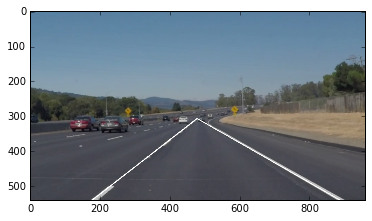

In [161]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [162]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

positive slope line points:  [[665 425]
 [774 496]
 [660 428]
 [759 497]
 [663 425]
 [726 463]
 [563 360]
 [610 389]
 [658 428]
 [721 471]
 [667 425]
 [775 495]]
negative slope line points:  [[125 538]
 [279 441]
 [109 535]
 [457 325]
 [320 413]
 [414 356]
 [251 457]
 [318 416]
 [105 538]
 [334 400]
 [397 366]
 [444 330]
 [405 361]
 [458 323]
 [295 429]
 [448 333]
 [289 433]
 [346 398]]
Slope & intercept:  [[0.65137614678899081, -8.1651376146788834], [0.69696969696969702, -32.000000000000057], [0.60317460317460314, 25.09523809523813], [0.61702127659574468, 12.617021276595722], [0.68253968253968256, -21.111111111111143], [0.64814814814814814, -7.3148148148147811]]
Positive slope:  0.649871592369 Positive intercept:  -5.14646736146
Slope & intercept:  [[-0.62987012987012991, 616.73376623376623], [-0.60344827586206895, 600.77586206896547], [-0.6063829787234043, 607.04255319148933], [-0.61194029850746268, 610.59701492537317], [-0.6026200873362445, 601.27510917030565], [-0.76595744680851063






  0%|          | 0/682 [00:00<?, ?it/s]




  0%|          | 3/682 [00:00<00:30, 22.14it/s]

positive slope line points:  [[665 425]
 [774 496]
 [660 428]
 [759 497]
 [663 425]
 [726 463]
 [563 360]
 [610 389]
 [658 428]
 [721 471]
 [667 425]
 [775 495]]
negative slope line points:  [[125 538]
 [279 441]
 [109 535]
 [457 325]
 [320 413]
 [414 356]
 [251 457]
 [318 416]
 [105 538]
 [334 400]
 [397 366]
 [444 330]
 [405 361]
 [458 323]
 [295 429]
 [448 333]
 [289 433]
 [346 398]]
Slope & intercept:  [[0.65137614678899081, -8.1651376146788834], [0.69696969696969702, -32.000000000000057], [0.60317460317460314, 25.09523809523813], [0.61702127659574468, 12.617021276595722], [0.68253968253968256, -21.111111111111143], [0.64814814814814814, -7.3148148148147811]]
Positive slope:  0.649871592369 Positive intercept:  -5.14646736146
Slope & intercept:  [[-0.62987012987012991, 616.73376623376623], [-0.60344827586206895, 600.77586206896547], [-0.6063829787234043, 607.04255319148933], [-0.61194029850746268, 610.59701492537317], [-0.6026200873362445, 601.27510917030565], [-0.76595744680851063

positive slope line points:  [[783 511]
 [821 539]
 [794 510]
 [842 538]
 [787 510]
 [833 532]]
negative slope line points:  [[192 491]
 [455 327]
 [134 538]
 [365 388]
 [135 538]
 [443 338]
 [115 539]
 [196 487]
 [328 407]
 [405 359]]
Slope & intercept:  [[0.73684210526315785, -65.947368421052602], [0.58333333333333337, 46.833333333333314], [0.47826086956521741, 133.60869565217388]]
Positive slope:  0.599478769387 Positive intercept:  38.1648868548
Slope & intercept:  [[-0.62357414448669202, 610.72623574144484], [-0.64935064935064934, 625.01298701298697], [-0.64935064935064934, 625.66233766233768], [-0.64197530864197527, 612.82716049382714], [-0.62337662337662336, 611.46753246753246]]
Positive slope:  -0.637525475041 Positive intercept:  617.139250676
Point one:  (468, 318) Point two:  (960, 613)
Point one:  (468, 318) Point two:  (0, 617)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)







  1%|          | 6/682 [00:00<00:29, 22.58it/s]

positive slope line points:  [[591 374]
 [619 391]
 [567 362]
 [617 394]]
negative slope line points:  [[136 538]
 [445 337]
 [118 539]
 [455 328]
 [117 538]
 [347 395]
 [177 512]
 [251 465]
 [369 388]
 [452 326]]
Slope & intercept:  [[0.6071428571428571, 15.178571428571445], [0.64000000000000001, -0.87999999999999545]]
Positive slope:  0.623571428571 Positive intercept:  7.14928571429
Slope & intercept:  [[-0.65048543689320393, 626.46601941747576], [-0.62611275964391688, 612.88130563798222], [-0.62173913043478257, 610.74347826086955], [-0.63513513513513509, 624.41891891891896], [-0.74698795180722888, 663.63855421686753]]
Positive slope:  -0.656092082783 Positive intercept:  627.62965529
Point one:  (484, 309) Point two:  (960, 605)
Point one:  (484, 309) Point two:  (0, 627)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[597 383]
 [624 400]
 [570 363]
 [630 400]]
negative slope line points:  [[121 537]
 [455 328]
 [231 477]
 [441 34






  1%|▏         | 9/682 [00:00<00:29, 22.73it/s]

(540, 960, 3)
positive slope line points:  [[636 399]
 [676 428]
 [585 370]
 [666 427]
 [628 394]
 [675 428]
 [588 373]
 [644 413]
 [586 370]
 [669 428]]
negative slope line points:  [[121 538]
 [370 382]
 [199 501]
 [445 335]
 [402 359]
 [454 326]
 [144 535]
 [207 495]
 [377 376]
 [446 334]
 [276 440]
 [333 405]
 [298 435]
 [436 342]
 [399 361]
 [447 333]]
Slope & intercept:  [[0.72499999999999998, -62.099999999999966], [0.70370370370370372, -41.666666666666686], [0.72340425531914898, -60.297872340425556], [0.7142857142857143, -47.0], [0.6987951807228916, -39.493975903614455]]
Positive slope:  0.713037770806 Positive intercept:  -50.1117029821
Slope & intercept:  [[-0.62650602409638556, 613.80722891566268], [-0.67479674796747968, 635.28455284552842], [-0.63461538461538458, 614.11538461538464], [-0.63492063492063489, 626.42857142857144], [-0.60869565217391308, 605.47826086956525], [-0.61403508771929827, 609.47368421052636], [-0.67391304347826086, 635.82608695652175], [-0.58333333333333






  2%|▏         | 12/682 [00:00<00:28, 23.15it/s]

positive slope line points:  [[591 374]
 [701 440]
 [642 411]
 [691 442]
 [641 410]
 [696 442]
 [593 374]
 [673 422]]
negative slope line points:  [[150 522]
 [282 437]
 [287 443]
 [422 352]
 [360 389]
 [443 331]
 [142 538]
 [256 462]
 [393 370]
 [441 338]
 [221 487]
 [262 458]
 [123 539]
 [170 508]
 [309 428]
 [363 391]
 [335 404]
 [407 362]
 [410 360]
 [451 329]
 [152 533]
 [200 500]
 [323 418]
 [376 377]
 [399 361]
 [454 326]]
Slope & intercept:  [[0.59999999999999998, 19.400000000000034], [0.63265306122448983, 4.8367346938775313], [0.58181818181818179, 37.054545454545462], [0.59999999999999998, 18.199999999999989]]
Positive slope:  0.593939393939 Positive intercept:  24.8848484848
Slope & intercept:  [[-0.64393939393939392, 618.59090909090912], [-0.67407407407407405, 636.45925925925928], [-0.6987951807228916, 640.56626506024099], [-0.66666666666666663, 632.66666666666663], [-0.66666666666666663, 632.0], [-0.70731707317073167, 643.31707317073165], [-0.65957446808510634, 620.12765957

(540, 960, 3)
positive slope line points:  [[703 449]
 [839 538]
 [709 447]
 [844 528]
 [713 448]
 [806 504]
 [703 451]
 [838 539]
 [572 364]
 [630 400]
 [573 364]
 [635 399]
 [714 456]
 [773 496]]
negative slope line points:  [[130 539]
 [359 390]
 [187 514]
 [445 333]
 [251 470]
 [441 337]
 [150 538]
 [228 484]
 [319 417]
 [364 385]
 [385 371]
 [443 334]
 [307 440]
 [370 381]
 [166 528]
 [211 496]
 [376 377]
 [427 348]
 [302 441]
 [375 378]
 [186 502]
 [239 467]]
Slope & intercept:  [[0.65441176470588236, -11.051470588235304], [0.59999999999999998, 21.600000000000023], [0.60215053763440862, 18.666666666666629], [0.6518518518518519, -7.2518518518518817], [0.62068965517241381, 8.9655172413793025], [0.56451612903225812, 40.5322580645161], [0.67796610169491522, -28.067796610169466]]
Positive slope:  0.624512291442 Positive intercept:  6.19904613176
Slope & intercept:  [[-0.6506550218340611, 623.58515283842792], [-0.70155038759689925, 645.18992248062023], [-0.69999999999999996, 645.700000






  2%|▏         | 15/682 [00:00<00:28, 23.63it/s]

(540, 960, 3)







  3%|▎         | 18/682 [00:00<00:27, 23.85it/s]

positive slope line points:  [[734 470]
 [839 538]
 [743 468]
 [861 538]
 [747 468]
 [805 503]
 [740 467]
 [808 505]
 [787 503]
 [838 537]
 [597 375]
 [648 408]
 [745 468]
 [858 536]
 [599 379]
 [644 408]]
negative slope line points:  [[132 539]
 [337 405]
 [206 502]
 [437 340]
 [132 538]
 [374 380]
 [152 538]
 [274 453]
 [366 384]
 [448 330]
 [360 388]
 [442 336]
 [152 539]
 [294 440]
 [356 391]
 [409 361]]
Slope & intercept:  [[0.64761904761904765, -5.3523809523809973], [0.59322033898305082, 27.237288135593246], [0.60344827586206895, 17.224137931034477], [0.55882352941176472, 53.470588235294088], [0.66666666666666663, -21.666666666666629], [0.6470588235294118, -11.29411764705884], [0.60176991150442483, 19.681415929203524], [0.64444444444444449, -7.0222222222222399]]
Positive slope:  0.620381379753 Positive intercept:  9.03475534285
Slope & intercept:  [[-0.65365853658536588, 625.28292682926826], [-0.70129870129870131, 646.46753246753246], [-0.65289256198347112, 624.18181818181824], [

positive slope line points:  [[608 386]
 [649 412]
 [614 384]
 [657 410]
 [613 384]
 [657 412]]
negative slope line points:  [[135 539]
 [446 329]
 [154 538]
 [420 351]
 [134 538]
 [235 470]
 [155 538]
 [290 443]
 [386 381]
 [435 334]
 [381 382]
 [419 346]
 [330 413]
 [394 369]]
Slope & intercept:  [[0.63414634146341464, 0.43902439024390105], [0.60465116279069764, 12.744186046511629], [0.63636363636363635, -6.0909090909090651]]
Positive slope:  0.625053713539 Positive intercept:  2.36410044862
Slope & intercept:  [[-0.67524115755627012, 630.15755627009651], [-0.70300751879699253, 646.26315789473688], [-0.67326732673267331, 628.21782178217825], [-0.70370370370370372, 647.07407407407413], [-0.95918367346938771, 751.24489795918362], [-0.94736842105263153, 742.9473684210526], [-0.6875, 639.875]]
Positive slope:  -0.764181685902 Positive intercept:  669.3971252
Point one:  (480, 302) Point two:  (960, 602)







  3%|▎         | 21/682 [00:00<00:27, 24.15it/s]




  4%|▎         | 24/682 [00:00<00:26, 24.44it/s]

Point one:  (480, 302) Point two:  (0, 669)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[617 392]
 [669 423]
 [624 390]
 [676 423]
 [617 391]
 [672 423]]
negative slope line points:  [[134 538]
 [445 329]
 [153 538]
 [419 351]
 [154 538]
 [379 380]
 [346 397]
 [431 336]
 [368 386]
 [434 339]
 [133 538]
 [286 435]
 [368 382]
 [414 350]]
Slope & intercept:  [[0.59615384615384615, 24.173076923076906], [0.63461538461538458, -6.0], [0.58181818181818179, 32.018181818181858]]
Positive slope:  0.604195804196 Positive intercept:  16.7304195804
Slope & intercept:  [[-0.67202572347266876, 628.0514469453376], [-0.70300751879699253, 645.56015037593988], [-0.70222222222222219, 646.14222222222224], [-0.71764705882352942, 645.30588235294113], [-0.71212121212121215, 648.06060606060601], [-0.67320261437908502, 627.53594771241831], [-0.69565217391304346, 638.0]]
Positive slope:  -0.696554074818 Positive intercept:  639.808036524
Point one:  (479, 306






  4%|▍         | 27/682 [00:01<00:26, 24.68it/s]

(540, 960, 3)
positive slope line points:  [[699 444]
 [843 534]
 [709 442]
 [871 539]
 [731 465]
 [848 538]
 [575 365]
 [625 396]
 [799 497]
 [862 534]
 [707 441]
 [756 471]]
negative slope line points:  [[138 538]
 [439 335]
 [158 538]
 [367 391]
 [322 415]
 [385 378]
 [354 394]
 [441 333]
 [391 367]
 [444 330]
 [270 450]
 [324 421]]
Slope & intercept:  [[0.625, 7.125], [0.59876543209876543, 17.475308641975289], [0.62393162393162394, 8.9059829059829099], [0.62, 8.5], [0.58730158730158732, 27.746031746031747], [0.61224489795918369, 8.1428571428571104]]
Positive slope:  0.611207256882 Positive intercept:  12.9825300728
Slope & intercept:  [[-0.67441860465116277, 631.06976744186045], [-0.70334928229665072, 649.12918660287085], [-0.58730158730158732, 604.11111111111109], [-0.70114942528735635, 642.20689655172418], [-0.69811320754716977, 639.96226415094338], [-0.53703703703703709, 595.0]]
Positive slope:  -0.672866421417 Positive intercept:  633.295845172
Point one:  (483, 308) Point two:






  4%|▍         | 30/682 [00:01<00:26, 24.56it/s]

hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[595 374]
 [623 390]]
negative slope line points:  [[330 418]
 [403 363]
 [162 539]
 [229 489]
 [262 457]
 [439 333]
 [253 472]
 [301 439]
 [199 523]
 [270 450]
 [188 518]
 [242 481]
 [141 539]
 [217 486]
 [257 459]
 [314 429]
 [249 464]
 [302 438]
 [162 538]
 [227 492]]
Slope & intercept:  [[0.5714285714285714, 34.0]]
Slope & intercept:  [[-0.75342465753424659, 666.63013698630141], [-0.74626865671641796, 659.8955223880597], [-0.70056497175141241, 640.54802259887003], [-0.6875, 645.9375], [-1.028169014084507, 727.6056338028169], [-0.68518518518518523, 646.81481481481478], [-0.69736842105263153, 637.32894736842104], [-0.52631578947368418, 594.26315789473688], [-0.49056603773584906, 586.15094339622647], [-0.70769230769230773, 652.64615384615388]]
Positive slope:  -0.725832111499 Positive intercept:  652.407765522
Point one:  (476, 306) Point two:  (960, 582)
Point one:  (476, 306) Point two






  5%|▍         | 33/682 [00:01<00:26, 24.42it/s]

(540, 960, 3)
positive slope line points:  [[610 384]
 [633 397]]
negative slope line points:  [[178 515]
 [312 422]
 [216 501]
 [362 395]
 [272 451]
 [324 414]
 [329 412]
 [429 337]
 [220 498]
 [282 452]
 [143 539]
 [189 506]
 [282 453]
 [424 346]
 [143 537]
 [231 479]
 [312 430]
 [375 385]
 [199 513]
 [250 475]]
Slope & intercept:  [[0.56521739130434778, 39.217391304347871]]
Slope & intercept:  [[-0.69402985074626866, 638.53731343283584], [-0.72602739726027399, 657.82191780821915], [-0.71153846153846156, 644.53846153846155], [-0.75, 658.75], [-0.74193548387096775, 661.22580645161293], [-0.71739130434782605, 641.58695652173913], [-0.75352112676056338, 665.49295774647885], [-0.65909090909090906, 631.25], [-0.7142857142857143, 652.85714285714289], [-0.74509803921568629, 661.27450980392155]]
Positive slope:  -0.728203042003 Positive intercept:  653.565007351
Point one:  (474, 307) Point two:  (960, 581)
Point one:  (474, 307) Point two:  (0, 653)
hough_rgb.shape:  (540, 960, 3)
hough_rgb

positive slope line points:  [[626 394]
 [680 427]
 [632 391]
 [690 427]
 [626 393]
 [683 427]]
negative slope line points:  [[255 474]
 [393 370]
 [145 539]
 [433 337]
 [166 539]
 [250 476]
 [371 385]
 [414 353]
 [221 499]
 [268 463]
 [186 511]
 [353 394]
 [373 378]
 [419 349]]
Slope & intercept:  [[0.61111111111111116, 11.4444444444444], [0.62068965517241381, -1.2758620689655231], [0.59649122807017541, 19.596491228070192]]
Positive slope:  0.609430664785 Positive intercept:  9.92169120118
Slope & intercept:  [[-0.75362318840579712, 666.17391304347825], [-0.70138888888888884, 640.70138888888891], [-0.75, 663.5], [-0.7441860465116279, 661.09302325581393], [-0.76595744680851063, 668.27659574468089], [-0.70059880239520955, 641.31137724550899], [-0.63043478260869568, 613.1521739130435]]
Positive slope:  -0.735959062168 Positive intercept:  656.842716363
Point one:  (480, 302) Point two:  (960, 594)
Point one:  (480, 302) Point two:  (0, 656)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:






  5%|▌         | 36/682 [00:01<00:26, 24.50it/s]




  6%|▌         | 39/682 [00:01<00:26, 24.60it/s]

positive slope line points:  [[657 407]
 [746 458]
 [652 409]
 [734 460]
 [659 407]
 [745 457]
 [652 408]
 [731 459]]
negative slope line points:  [[217 490]
 [422 341]
 [167 539]
 [407 358]
 [260 460]
 [433 335]
 [203 511]
 [269 464]
 [309 433]
 [359 400]
 [180 528]
 [246 481]]
Slope & intercept:  [[0.5730337078651685, 30.516853932584297], [0.62195121951219512, 3.4878048780487916], [0.58139534883720934, 23.860465116279045], [0.64556962025316456, -12.911392405063282]]
Positive slope:  0.605487474117 Positive intercept:  11.2384328805
Slope & intercept:  [[-0.72682926829268291, 647.72195121951222], [-0.75416666666666665, 664.94583333333333], [-0.7225433526011561, 647.86127167630059], [-0.71212121212121215, 655.56060606060601], [-0.66000000000000003, 636.94000000000005], [-0.71212121212121215, 656.18181818181824]]
Positive slope:  -0.725556342361 Positive intercept:  654.454296094
Point one:  (483, 303) Point two:  (960, 592)
Point one:  (483, 303) Point two:  (0, 654)
hough_rgb.shape:  

positive slope line points:  [[715 446]
 [863 539]
 [724 445]
 [845 515]
 [834 510]
 [884 538]
 [715 447]
 [762 477]
 [721 445]
 [826 503]
 [733 458]
 [803 503]]
negative slope line points:  [[168 537]
 [383 375]
 [146 537]
 [362 385]
 [243 468]
 [431 336]
 [360 392]
 [414 344]
 [264 464]
 [315 432]]
Slope & intercept:  [[0.6283783783783784, -3.2905405405405759], [0.57851239669421484, 26.157024793388473], [0.56000000000000005, 42.95999999999998], [0.63829787234042556, -9.3829787234042783], [0.55238095238095242, 46.733333333333292], [0.6428571428571429, -13.214285714285722]]
Positive slope:  0.600071123775 Positive intercept:  14.9937588581
Slope & intercept:  [[-0.75348837209302322, 663.58604651162796], [-0.70370370370370372, 639.74074074074076], [-0.7021276595744681, 638.61702127659578], [-0.88888888888888884, 712.0], [-0.62745098039215685, 629.64705882352939]]
Positive slope:  -0.73513192093 Positive intercept:  656.71817347
Point one:  (480, 303) Point two:  (960, 591)
Point one:  (






  6%|▌         | 42/682 [00:01<00:26, 23.99it/s]

positive slope line points:  [[802 492]
 [863 526]
 [790 494]
 [861 539]
 [798 492]
 [875 533]
 [792 495]
 [861 537]
 [801 492]
 [882 539]]
negative slope line points:  [[165 539]
 [399 362]
 [144 538]
 [358 388]
 [153 531]
 [431 336]
 [359 392]
 [419 346]]
Slope & intercept:  [[0.55737704918032782, 44.983606557377072], [0.63380281690140849, -6.7042253521127009], [0.53246753246753242, 67.090909090909122], [0.60869565217391308, 12.913043478260818], [0.58024691358024694, 27.222222222222229]]
Positive slope:  0.582517992861 Positive intercept:  29.1011111993
Slope & intercept:  [[-0.75641025641025639, 663.80769230769226], [-0.7009345794392523, 638.93457943925227], [-0.70143884892086328, 638.3201438848921], [-0.76666666666666672, 667.23333333333335]]
Positive slope:  -0.731362587859 Positive intercept:  652.073937241
Point one:  (474, 305) Point two:  (960, 588)
Point one:  (474, 305) Point two:  (0, 652)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope l






  7%|▋         | 45/682 [00:01<00:27, 23.21it/s]

positive slope line points:  [[604 381]
 [640 402]]
negative slope line points:  [[145 538]
 [352 393]
 [173 534]
 [376 381]
 [314 419]
 [414 351]
 [335 404]
 [433 335]
 [190 521]
 [246 478]
 [385 372]
 [435 334]]
Slope & intercept:  [[0.58333333333333337, 28.666666666666629]]
Slope & intercept:  [[-0.70048309178743962, 639.57004830917879], [-0.75369458128078815, 664.38916256157631], [-0.68000000000000005, 632.51999999999998], [-0.70408163265306123, 639.86734693877554], [-0.7678571428571429, 666.89285714285711], [-0.76000000000000001, 664.60000000000002]]
Positive slope:  -0.727686074763 Positive intercept:  651.306569159
Point one:  (474, 305) Point two:  (960, 588)
Point one:  (474, 305) Point two:  (0, 651)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[609 384]
 [649 410]
 [610 382]
 [653 411]]
negative slope line points:  [[165 539]
 [417 349]
 [144 538]
 [435 334]
 [153 533]
 [220 485]
 [282 443]
 [352 391]
 [373 376]
 [423 344






  7%|▋         | 48/682 [00:02<00:26, 23.60it/s]

(540, 960, 3)
positive slope line points:  [[619 391]
 [670 422]
 [622 388]
 [678 422]
 [618 391]
 [667 421]
 [623 388]
 [678 420]]
negative slope line points:  [[166 539]
 [403 360]
 [145 539]
 [306 426]
 [308 423]
 [360 387]
 [347 395]
 [421 346]
 [383 369]
 [439 332]
 [228 493]
 [354 398]
 [253 462]
 [323 414]
 [173 519]
 [236 474]
 [310 422]
 [375 381]]
Slope & intercept:  [[0.60784313725490191, 14.745098039215691], [0.6071428571428571, 10.35714285714289], [0.61224489795918369, 12.63265306122446], [0.58181818181818179, 25.527272727272759]]
Positive slope:  0.602262268544 Positive intercept:  15.8155416712
Slope & intercept:  [[-0.75527426160337552, 664.37552742616037], [-0.70186335403726707, 640.77018633540376], [-0.69230769230769229, 636.23076923076928], [-0.66216216216216217, 624.7702702702702], [-0.6607142857142857, 622.05357142857144], [-0.75396825396825395, 664.90476190476193], [-0.68571428571428572, 635.48571428571427], [-0.7142857142857143, 642.57142857142856], [-0.630769230

hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[672 423]
 [794 499]
 [684 423]
 [809 498]
 [675 426]
 [791 498]
 [682 423]
 [808 498]]
negative slope line points:  [[190 520]
 [251 473]
 [327 408]
 [410 349]
 [170 521]
 [309 421]
 [346 395]
 [406 357]
 [144 539]
 [247 465]
 [340 399]
 [390 369]
 [381 369]
 [422 340]
 [290 445]
 [339 401]
 [332 415]
 [388 369]]
Slope & intercept:  [[0.62295081967213117, 4.3770491803278446], [0.59999999999999998, 12.600000000000023], [0.62068965517241381, 7.0344827586206975], [0.59523809523809523, 17.047619047619037]]
Positive slope:  0.609719642521 Positive intercept:  10.2647877466
Slope & intercept:  [[-0.77049180327868849, 666.39344262295083], [-0.71084337349397586, 640.4457831325301], [-0.71942446043165464, 643.30215827338134], [-0.6333333333333333, 614.13333333333333], [-0.71844660194174759, 642.45631067961165], [-0.59999999999999998, 603.0], [-0.70731707317073167, 638.48780487804879], [-0.8979591






  7%|▋         | 51/682 [00:02<00:26, 23.70it/s]

(540, 960, 3)
positive slope line points:  [[705 437]
 [873 534]
 [694 437]
 [855 537]
 [693 437]
 [852 536]
 [810 499]
 [872 534]
 [747 462]
 [873 535]]
negative slope line points:  [[165 538]
 [437 333]
 [163 526]
 [288 436]
 [293 434]
 [336 402]
 [144 539]
 [202 497]
 [310 422]
 [409 350]
 [238 473]
 [284 439]
 [164 538]
 [320 421]
 [318 428]
 [380 370]]
Slope & intercept:  [[0.57738095238095233, 29.946428571428612], [0.6211180124223602, 5.9440993788820151], [0.62264150943396224, 5.5094339622641542], [0.56451612903225812, 41.741935483870918], [0.57936507936507942, 29.214285714285666]]
Positive slope:  0.593004336527 Positive intercept:  22.4712366221
Slope & intercept:  [[-0.75367647058823528, 662.35661764705878], [-0.71999999999999997, 643.36000000000001], [-0.7441860465116279, 652.04651162790697], [-0.72413793103448276, 643.27586206896558], [-0.72727272727272729, 647.4545454545455], [-0.73913043478260865, 648.91304347826087], [-0.75, 661.0], [-0.93548387096774188, 725.483870967741






  8%|▊         | 54/682 [00:02<00:27, 23.04it/s]

positive slope line points:  [[806 507]
 [855 538]
 [827 509]
 [876 538]
 [824 508]
 [876 539]
 [808 507]
 [856 538]]
negative slope line points:  [[142 538]
 [410 350]
 [209 505]
 [439 332]
 [184 522]
 [248 482]
 [163 539]
 [253 471]
 [187 508]
 [334 405]
 [244 468]
 [300 428]]
Slope & intercept:  [[0.63265306122448983, -2.9183673469387941], [0.59183673469387754, 19.551020408163254], [0.59615384615384615, 16.769230769230774], [0.64583333333333337, -14.833333333333371]]
Positive slope:  0.616619243851 Positive intercept:  4.64213762428
Slope & intercept:  [[-0.70149253731343286, 637.61194029850742], [-0.75217391304347825, 662.20434782608697], [-0.625, 637.0], [-0.75555555555555554, 662.15555555555557], [-0.70068027210884354, 639.02721088435374], [-0.7142857142857143, 642.28571428571422]]
Positive slope:  -0.724837598461 Positive intercept:  648.65695377
Point one:  (480, 300) Point two:  (960, 596)
Point one:  (480, 300) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.ty






  8%|▊         | 57/682 [00:02<00:27, 22.84it/s]

positive slope line points:  [[586 373]
 [619 390]]
negative slope line points:  [[142 538]
 [424 340]
 [162 539]
 [363 388]
 [259 468]
 [438 333]
 [358 393]
 [407 351]
 [141 538]
 [224 482]
 [301 436]
 [353 396]]
Slope & intercept:  [[0.51515151515151514, 71.121212121212125]]
Slope & intercept:  [[-0.7021276595744681, 637.70212765957444], [-0.75124378109452739, 660.70149253731347], [-0.75418994413407825, 663.3351955307262], [-0.8571428571428571, 699.85714285714289], [-0.67469879518072284, 633.13253012048187], [-0.76923076923076927, 667.53846153846155]]
Positive slope:  -0.751438967726 Positive intercept:  660.377825041
Point one:  (465, 310) Point two:  (960, 565)
Point one:  (465, 310) Point two:  (0, 660)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[597 375]
 [631 394]]
negative slope line points:  [[201 510]
 [437 333]
 [141 538]
 [423 340]
 [233 487]
 [439 332]
 [202 497]
 [253 460]]
Slope & intercept:  [[0.55882352941176472, 






  9%|▉         | 60/682 [00:02<00:27, 22.95it/s]

positive slope line points:  [[627 392]
 [680 425]
 [619 394]
 [671 426]
 [626 392]
 [680 427]
 [620 394]
 [673 426]]
negative slope line points:  [[251 460]
 [367 381]
 [281 448]
 [441 331]
 [294 430]
 [385 368]
 [160 539]
 [246 476]
 [202 496]
 [244 465]
 [241 478]
 [300 436]
 [387 365]
 [439 332]
 [291 441]
 [354 396]
 [369 378]
 [434 336]]
Slope & intercept:  [[0.62264150943396224, 1.6037735849056958], [0.61538461538461542, 13.076923076923038], [0.64814814814814814, -13.740740740740762], [0.60377358490566035, 19.660377358490564]]
Positive slope:  0.613933236575 Positive intercept:  11.4470246734
Slope & intercept:  [[-0.68103448275862066, 630.93965517241372], [-0.73124999999999996, 653.48125000000005], [-0.68131868131868134, 630.30769230769238], [-0.73255813953488369, 656.20930232558135], [-0.73809523809523814, 645.09523809523807], [-0.71186440677966101, 649.5593220338983], [-0.63461538461538458, 610.59615384615381], [-0.7142857142857143, 648.85714285714289], [-0.64615384615384619,






  9%|▉         | 63/682 [00:02<00:26, 23.40it/s]

positive slope line points:  [[631 402]
 [694 441]
 [590 372]
 [703 439]
 [639 400]
 [690 431]]
negative slope line points:  [[140 538]
 [426 338]
 [200 508]
 [426 343]
 [314 418]
 [418 343]
 [373 376]
 [432 337]
 [168 532]
 [300 436]]
Slope & intercept:  [[0.61904761904761907, 11.380952380952351], [0.59292035398230092, 22.176991150442461], [0.60784313725490191, 11.58823529411768]]
Positive slope:  0.606603703428 Positive intercept:  15.0487262752
Slope & intercept:  [[-0.69930069930069927, 635.90209790209792], [-0.73008849557522126, 654.01769911504425], [-0.72115384615384615, 644.44230769230762], [-0.66101694915254239, 622.5593220338983], [-0.72727272727272729, 654.18181818181824]]
Positive slope:  -0.719453942076 Positive intercept:  647.135980723
Point one:  (476, 304) Point two:  (960, 597)
Point one:  (476, 304) Point two:  (0, 647)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[647 407]
 [733 456]
 [644 410]
 [722 458]
 [656 41

positive slope line points:  [[703 447]
 [850 539]
 [713 445]
 [862 534]
 [799 506]
 [849 538]
 [717 446]
 [864 534]
 [568 362]
 [625 396]
 [705 445]
 [774 491]]
negative slope line points:  [[156 538]
 [441 331]
 [136 539]
 [250 460]
 [226 478]
 [426 338]
 [136 538]
 [207 489]
 [310 428]
 [376 379]
 [366 387]
 [439 332]
 [155 538]
 [305 433]]
Slope & intercept:  [[0.62585034013605445, 7.0272108843537353], [0.59731543624161076, 19.11409395973152], [0.64000000000000001, -5.3600000000000136], [0.59863945578231292, 16.775510204081627], [0.59649122807017541, 23.192982456140385], [0.66666666666666663, -25.0]]
Positive slope:  0.611659292046 Positive intercept:  12.1499595009
Slope & intercept:  [[-0.72631578947368425, 651.30526315789473], [-0.69298245614035092, 633.24561403508778], [-0.69999999999999996, 636.20000000000005], [-0.6901408450704225, 631.85915492957747], [-0.74242424242424243, 658.15151515151513], [-0.75342465753424659, 662.7534246575342], [-0.69999999999999996, 646.5]]
Positiv






 10%|▉         | 66/682 [00:02<00:26, 23.44it/s]




 10%|█         | 69/682 [00:02<00:25, 23.86it/s]

positive slope line points:  [[744 464]
 [870 539]
 [734 466]
 [850 538]
 [733 466]
 [849 539]
 [750 466]
 [871 538]
 [743 464]
 [870 537]]
negative slope line points:  [[156 538]
 [441 331]
 [231 475]
 [424 340]
 [136 539]
 [221 480]
 [235 472]
 [294 430]
 [255 467]
 [328 415]
 [379 378]
 [434 337]
 [236 481]
 [285 450]
 [161 534]
 [294 440]]
Slope & intercept:  [[0.59523809523809523, 21.142857142857167], [0.62068965517241381, 10.413793103448256], [0.62931034482758619, 4.7155172413793025], [0.5950413223140496, 19.719008264462786], [0.57480314960629919, 36.921259842519703]]
Positive slope:  0.603016513432 Positive intercept:  18.5824871189
Slope & intercept:  [[-0.72631578947368425, 651.30526315789473], [-0.69948186528497414, 636.58031088082907], [-0.69411764705882351, 633.39999999999998], [-0.71186440677966101, 639.28813559322032], [-0.71232876712328763, 648.64383561643831], [-0.74545454545454548, 660.5272727272727], [-0.63265306122448983, 630.30612244897964], [-0.70676691729323304, 6

(540, 960, 3)
positive slope line points:  [[621 390]
 [649 408]]
negative slope line points:  [[160 524]
 [294 431]
 [158 538]
 [443 331]
 [326 411]
 [440 332]
 [209 502]
 [425 345]
 [317 417]
 [425 339]
 [138 539]
 [225 478]
 [283 440]
 [324 411]
 [379 373]
 [429 341]
 [376 375]
 [444 330]]
Slope & intercept:  [[0.6428571428571429, -9.2142857142857224]]
Slope & intercept:  [[-0.69402985074626866, 635.04477611940297], [-0.72631578947368425, 652.7578947368421], [-0.69298245614035092, 636.91228070175441], [-0.72685185185185186, 653.91203703703707], [-0.72222222222222221, 645.94444444444446], [-0.70114942528735635, 635.75862068965512], [-0.70731707317073167, 640.17073170731703], [-0.64000000000000001, 615.55999999999995], [-0.66176470588235292, 623.82352941176464]]
Positive slope:  -0.704079171847 Positive intercept:  640.540539356
Point one:  (482, 300) Point two:  (960, 607)
Point one:  (482, 300) Point two:  (0, 640)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)






 11%|█         | 72/682 [00:03<01:15,  8.09it/s]

(540, 960, 3)
positive slope line points:  [[619 397]
 [676 432]
 [582 369]
 [686 431]
 [622 398]
 [679 432]
 [627 395]
 [680 426]]
negative slope line points:  [[137 538]
 [446 329]
 [156 538]
 [366 391]
 [138 538]
 [360 388]
 [233 483]
 [369 387]
 [367 391]
 [435 336]
 [365 383]
 [417 351]
 [369 391]
 [424 340]]
Slope & intercept:  [[0.61403508771929827, 16.912280701754355], [0.59615384615384615, 22.038461538461547], [0.59649122807017541, 26.982456140350905], [0.58490566037735847, 28.26415094339626]]
Positive slope:  0.592516911534 Positive intercept:  25.7616895407
Slope & intercept:  [[-0.6763754045307443, 630.66343042071196], [-0.69999999999999996, 647.20000000000005], [-0.67567567567567566, 631.24324324324323], [-0.70588235294117652, 647.47058823529414], [-0.80882352941176472, 687.83823529411757], [-0.61538461538461542, 607.61538461538464], [-0.92727272727272725, 733.16363636363633]]
Positive slope:  -0.729916329317 Positive intercept:  655.02778831
Point one:  (475, 307) Point t






 11%|█         | 74/682 [00:04<01:09,  8.76it/s]




 11%|█▏        | 77/682 [00:04<00:55, 10.85it/s]

(540, 960, 3)
positive slope line points:  [[645 414]
 [728 467]
 [651 412]
 [742 466]
 [653 412]
 [742 465]
 [645 412]
 [729 467]]
negative slope line points:  [[138 539]
 [323 414]
 [158 539]
 [443 332]
 [300 428]
 [448 328]
 [140 537]
 [195 499]
 [188 504]
 [259 457]
 [396 366]
 [444 331]
 [399 359]
 [445 329]
 [216 496]
 [332 414]]
Slope & intercept:  [[0.63855421686746983, 2.132530120481988], [0.59340659340659341, 25.692307692307679], [0.5955056179775281, 23.13483146067415], [0.65476190476190477, -10.321428571428555]]
Positive slope:  0.620557083253 Positive intercept:  10.1595601755
Slope & intercept:  [[-0.67567567567567566, 632.24324324324323], [-0.72631578947368425, 653.7578947368421], [-0.67567567567567566, 630.70270270270271], [-0.69090909090909092, 633.72727272727275], [-0.6619718309859155, 628.45070422535207], [-0.72916666666666663, 654.75], [-0.65217391304347827, 619.21739130434776], [-0.7068965517241379, 648.68965517241372]]
Positive slope:  -0.689848149269 Positive inte






 12%|█▏        | 80/682 [00:04<00:46, 12.94it/s]




 12%|█▏        | 83/682 [00:04<00:39, 15.01it/s]

(540, 960, 3)
positive slope line points:  [[586 370]
 [606 383]
 [781 501]
 [840 539]
 [800 502]
 [861 538]
 [603 384]
 [647 416]
 [784 501]
 [838 537]]
negative slope line points:  [[210 490]
 [431 336]
 [157 539]
 [446 329]
 [253 461]
 [427 339]
 [155 527]
 [249 462]
 [248 474]
 [412 355]]
Slope & intercept:  [[0.65000000000000002, -10.900000000000034], [0.64406779661016944, -2.0169491525423382], [0.5901639344262295, 29.868852459016409], [0.72727272727272729, -54.545454545454561], [0.66666666666666663, -21.666666666666629]]
Positive slope:  0.637724599426 Positive intercept:  -1.17869084005
Slope & intercept:  [[-0.69683257918552033, 636.33484162895934], [-0.72664359861591699, 653.08304498269899], [-0.70114942528735635, 638.39080459770116], [-0.69148936170212771, 634.18085106382978], [-0.72560975609756095, 653.95121951219517]]
Positive slope:  -0.708344944178 Positive intercept:  643.188152357
Point one:  (478, 304) Point two:  (960, 611)
Point one:  (478, 304) Point two:  (0, 643)







 13%|█▎        | 86/682 [00:04<00:35, 16.78it/s]

(540, 960, 3)
positive slope line points:  [[575 366]
 [669 421]
 [575 368]
 [662 424]
 [606 390]
 [661 424]]
negative slope line points:  [[133 538]
 [402 356]
 [155 539]
 [445 329]
 [157 537]
 [419 347]
 [134 539]
 [243 465]]
Slope & intercept:  [[0.58510638297872342, 29.563829787234056], [0.64367816091954022, -2.1149425287356394], [0.61818181818181817, 15.381818181818176]]
Positive slope:  0.615655454027 Positive intercept:  14.2769018134
Slope & intercept:  [[-0.67657992565055758, 627.9851301115242], [-0.72413793103448276, 651.24137931034488], [-0.72519083969465647, 650.85496183206101], [-0.67889908256880738, 629.97247706422013]]
Positive slope:  -0.701201944737 Positive intercept:  640.01348708
Point one:  (475, 306) Point two:  (960, 605)
Point one:  (475, 306) Point two:  (0, 640)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[582 372]
 [682 437]
 [583 369]
 [687 434]
 [617 397]
 [681 437]
 [582 370]
 [690 434]
 [629 404]
 [68






 13%|█▎        | 89/682 [00:04<00:32, 18.46it/s]




 13%|█▎        | 92/682 [00:04<00:29, 20.00it/s]

(540, 960, 3)
positive slope line points:  [[683 439]
 [836 538]
 [693 436]
 [854 536]
 [692 436]
 [833 524]
 [562 360]
 [619 389]
 [808 507]
 [851 534]
 [562 359]
 [615 392]
 [690 436]
 [746 481]
 [568 364]
 [613 392]
 [789 509]
 [835 539]]
negative slope line points:  [[130 539]
 [431 336]
 [150 538]
 [435 338]
 [371 376]
 [429 337]
 [150 539]
 [309 427]
 [387 370]
 [441 333]
 [130 538]
 [203 489]
 [332 409]
 [396 365]]
Slope & intercept:  [[0.6470588235294118, -2.941176470588232], [0.6211180124223602, 5.5652173913043725], [0.62411347517730498, 4.1134751773049629], [0.50877192982456143, 74.070175438596493], [0.62790697674418605, -0.34883720930230311], [0.62264150943396224, 9.0754716981132333], [0.8035714285714286, -118.46428571428578], [0.62222222222222223, 10.577777777777783], [0.65217391304347827, -5.5652173913043725]]
Positive slope:  0.6157508578 Positive intercept:  11.8183608015
Slope & intercept:  [[-0.67441860465116277, 626.67441860465112], [-0.70175438596491224, 643.26315789






 14%|█▍        | 95/682 [00:04<00:27, 21.48it/s]




 14%|█▍        | 98/682 [00:05<00:25, 22.52it/s]

positive slope line points:  [[544 351]
 [622 396]
 [541 350]
 [619 399]
 [565 362]
 [622 397]]
negative slope line points:  [[155 538]
 [439 339]
 [242 469]
 [457 324]
 [373 379]
 [443 331]
 [142 535]
 [206 491]
 [184 507]
 [238 470]
 [363 386]
 [425 345]
 [156 539]
 [324 421]
 [329 410]
 [445 329]
 [330 415]
 [446 333]]
Slope & intercept:  [[0.57692307692307687, 37.153846153846189], [0.62820512820512819, 10.141025641025635], [0.61403508771929827, 15.070175438596493]]
Positive slope:  0.606387764283 Positive intercept:  20.7883490778
Slope & intercept:  [[-0.70070422535211263, 646.60915492957747], [-0.67441860465116277, 632.20930232558135], [-0.68571428571428572, 634.7714285714286], [-0.6875, 632.625], [-0.68518518518518523, 633.07407407407413], [-0.66129032258064513, 626.04838709677415], [-0.70238095238095233, 648.57142857142856], [-0.69827586206896552, 639.73275862068965], [-0.7068965517241379, 648.27586206896547]]
Positive slope:  -0.692634458385 Positive intercept:  639.483626145







 15%|█▍        | 101/682 [00:05<00:24, 23.25it/s]




 15%|█▌        | 104/682 [00:05<00:24, 23.43it/s]

(540, 960, 3)
positive slope line points:  [[646 417]
 [725 470]
 [653 415]
 [741 468]
 [654 415]
 [738 465]
 [557 358]
 [600 385]
 [647 415]
 [726 470]]
negative slope line points:  [[136 538]
 [432 338]
 [156 538]
 [298 438]
 [331 413]
 [413 357]
 [314 425]
 [365 391]
 [136 539]
 [454 325]
 [300 435]
 [345 405]
 [263 453]
 [346 416]
 [275 453]
 [325 419]
 [335 415]
 [398 366]]
Slope & intercept:  [[0.67088607594936711, -16.392405063291164], [0.60227272727272729, 21.715909090909065], [0.59523809523809523, 25.714285714285722], [0.62790697674418605, 8.2558139534883708], [0.69620253164556967, -35.443037974683591]]
Positive slope:  0.63850128137 Positive intercept:  0.770113144142
Slope & intercept:  [[-0.67567567567567566, 629.89189189189187], [-0.70422535211267601, 647.85915492957747], [-0.68292682926829273, 639.04878048780483], [-0.66666666666666663, 634.33333333333326], [-0.67295597484276726, 630.52201257861634], [-0.66666666666666663, 635.0], [-0.44578313253012047, 570.24096385542168






 16%|█▌        | 107/682 [00:05<00:24, 23.43it/s]

(540, 960, 3)
positive slope line points:  [[803 506]
 [854 537]
 [786 508]
 [833 539]
 [558 358]
 [603 386]
 [798 505]
 [855 539]
 [559 358]
 [606 386]
 [215 445]
 [278 451]]
negative slope line points:  [[153 538]
 [421 350]
 [207 490]
 [448 328]
 [133 538]
 [257 455]
 [153 539]
 [350 401]
 [202 493]
 [256 456]
 [163 519]
 [225 507]]
Slope & intercept:  [[0.60784313725490191, 17.901960784313758], [0.65957446808510634, -10.425531914893554], [0.62222222222222223, 10.800000000000011], [0.59649122807017541, 29.0], [0.5957446808510638, 24.978723404255334], [0.095238095238095233, 424.52380952380952]]
Positive slope:  0.529518971954 Positive intercept:  82.7964936329
Slope & intercept:  [[-0.70149253731343286, 645.32835820895525], [-0.67219917012448138, 629.1452282157677], [-0.66935483870967738, 627.02419354838707], [-0.70050761421319796, 646.17766497461935], [-0.68518518518518523, 631.40740740740739], [-0.19354838709677419, 550.54838709677415]]
Positive slope:  -0.685747869109 Positive int






 16%|█▌        | 110/682 [00:05<00:24, 23.63it/s]




 17%|█▋        | 113/682 [00:05<00:23, 23.73it/s]

(540, 960, 3)
positive slope line points:  [[579 374]
 [662 428]
 [550 354]
 [655 415]
 [618 399]
 [666 428]
 [564 361]
 [664 428]
 [615 397]
 [672 426]
 [585 372]
 [672 428]]
negative slope line points:  [[135 538]
 [273 448]
 [156 539]
 [388 376]
 [333 408]
 [440 333]
 [242 467]
 [300 430]
 [309 430]
 [385 378]
 [295 433]
 [344 399]
 [408 355]
 [462 321]
 [264 462]
 [325 420]
 [184 520]
 [257 467]]
Slope & intercept:  [[0.6506024096385542, -2.6987951807228683], [0.580952380952381, 34.476190476190425], [0.60416666666666663, 25.625], [0.67000000000000004, -16.879999999999995], [0.50877192982456143, 84.10526315789474], [0.64367816091954022, -4.5517241379310462]]
Positive slope:  0.609695258 Positive intercept:  20.0126557192
Slope & intercept:  [[-0.65217391304347827, 626.04347826086951], [-0.70258620689655171, 648.60344827586209], [-0.7009345794392523, 641.41121495327104], [-0.63793103448275867, 621.37931034482756], [-0.68421052631578949, 641.42105263157896], [-0.69387755102040816, 637






 17%|█▋        | 116/682 [00:05<00:23, 23.89it/s]




 17%|█▋        | 119/682 [00:05<00:23, 24.34it/s]

(540, 960, 3)
positive slope line points:  [[694 447]
 [836 539]
 [766 483]
 [856 537]
 [705 445]
 [800 502]
 [577 371]
 [630 400]
 [568 364]
 [626 400]
 [697 444]
 [800 501]
 [783 503]
 [834 537]
 [584 369]
 [631 399]
 [697 448]
 [755 485]
 [581 368]
 [622 400]]
negative slope line points:  [[694 447]
 [836 539]
 [137 539]
 [395 365]
 [223 493]
 [458 323]
 [298 440]
 [462 321]
 [157 538]
 [227 490]
 [137 538]
 [244 466]
 [225 490]
 [288 449]
 [386 370]
 [460 322]
 [222 452]
 [301 451]]
Slope & intercept:  [[0.647887323943662, -2.6338028169014365], [0.59999999999999998, 23.400000000000034], [0.59999999999999998, 22.0], [0.54716981132075471, 55.283018867924511], [0.62068965517241381, 11.448275862068954], [0.55339805825242716, 58.281553398058293], [0.66666666666666663, -19.0], [0.63829787234042556, -3.7659574468085566], [0.63793103448275867, 3.36206896551721], [0.78048780487804881, -85.463414634146375]]
Positive slope:  0.612448935798 Positive intercept:  16.4861285367
Slope & intercept:






 18%|█▊        | 122/682 [00:05<00:22, 24.59it/s]




 18%|█▊        | 125/682 [00:06<00:22, 25.03it/s]

positive slope line points:  [[601 380]
 [637 402]
 [569 365]
 [631 405]
 [574 365]
 [634 405]
 [570 363]
 [632 405]]
negative slope line points:  [[139 538]
 [379 376]
 [159 539]
 [229 488]
 [330 418]
 [429 344]
 [371 380]
 [453 328]
 [257 468]
 [327 420]
 [395 370]
 [451 328]
 [406 356]
 [463 321]
 [285 448]
 [332 416]
 [210 503]
 [253 471]
 [330 417]
 [441 331]]
Slope & intercept:  [[0.61111111111111116, 12.722222222222172], [0.64516129032258063, -2.0967741935483559], [0.66666666666666663, -17.666666666666629], [0.67741935483870963, -23.129032258064512]]
Positive slope:  0.650089605735 Positive intercept:  -7.54256272401
Slope & intercept:  [[-0.67500000000000004, 631.82500000000005], [-0.72857142857142854, 654.84285714285716], [-0.74747474747474751, 664.66666666666674], [-0.63414634146341464, 615.26829268292681], [-0.68571428571428572, 644.2285714285714], [-0.75, 666.25], [-0.61403508771929827, 605.29824561403507], [-0.68085106382978722, 642.04255319148933], [-0.7441860465116279, 6






 19%|█▉        | 128/682 [00:06<00:21, 25.20it/s]




 19%|█▉        | 131/682 [00:06<00:21, 25.05it/s]

(540, 960, 3)
positive slope line points:  [[564 360]
 [615 391]
 [667 428]
 [782 502]
 [676 428]
 [795 499]
 [678 428]
 [739 463]
 [564 362]
 [613 391]
 [669 430]
 [725 467]
 [670 428]
 [733 472]
 [742 468]
 [792 498]]
negative slope line points:  [[164 538]
 [445 334]
 [373 380]
 [456 324]
 [170 521]
 [344 400]
 [360 389]
 [455 329]
 [167 523]
 [241 470]
 [353 402]
 [458 323]
 [410 361]
 [464 321]
 [148 536]
 [212 490]
 [396 365]
 [453 330]]
Slope & intercept:  [[0.60784313725490191, 17.176470588235304], [0.64347826086956517, -1.1999999999999886], [0.59663865546218486, 24.672268907563023], [0.57377049180327866, 38.983606557377072], [0.59183673469387754, 28.204081632653072], [0.6607142857142857, -12.01785714285711], [0.69841269841269837, -39.936507936507894], [0.59999999999999998, 22.800000000000011]]
Positive slope:  0.610611652257 Positive intercept:  16.9455100776
Slope & intercept:  [[-0.72597864768683273, 657.06049822064051], [-0.67469879518072284, 631.6626506024096], [-0.6954022






 20%|█▉        | 134/682 [00:06<00:21, 25.10it/s]

positive slope line points:  [[593 375]
 [620 392]
 [564 362]
 [611 393]
 [568 362]
 [616 390]]
negative slope line points:  [[186 523]
 [466 320]
 [319 419]
 [454 325]
 [145 537]
 [239 472]
 [237 475]
 [289 438]
 [142 539]
 [199 499]
 [369 385]
 [458 323]
 [198 514]
 [443 336]]
Slope & intercept:  [[0.62962962962962965, 1.6296296296296191], [0.65957446808510634, -10.0], [0.58333333333333337, 30.666666666666629]]
Positive slope:  0.624179143683 Positive intercept:  7.43209876543
Slope & intercept:  [[-0.72499999999999998, 657.85000000000002], [-0.6962962962962963, 641.1185185185185], [-0.69148936170212771, 637.26595744680856], [-0.71153846153846156, 643.63461538461536], [-0.70175438596491224, 638.64912280701753], [-0.6966292134831461, 642.05617977528095], [-0.72653061224489801, 657.85306122448981]]
Positive slope:  -0.707034047319 Positive intercept:  645.489636451
Point one:  (479, 306) Point two:  (960, 606)
Point one:  (479, 306) Point two:  (0, 645)
hough_rgb.shape:  (540, 960, 3)







 20%|██        | 137/682 [00:06<00:21, 25.23it/s]




 21%|██        | 140/682 [00:06<00:21, 25.25it/s]

(540, 960, 3)
positive slope line points:  [[643 412]
 [719 461]
 [647 411]
 [730 459]
 [643 413]
 [717 461]
 [653 412]
 [729 459]]
negative slope line points:  [[143 538]
 [373 383]
 [164 538]
 [431 345]
 [389 370]
 [460 322]
 [170 535]
 [456 328]
 [310 424]
 [383 376]
 [248 466]
 [316 421]]
Slope & intercept:  [[0.64473684210526316, -2.5657894736842195], [0.57831325301204817, 36.831325301204856], [0.64864864864864868, -4.0810810810810949], [0.61842105263157898, 8.1710526315789025]]
Positive slope:  0.622529949099 Positive intercept:  9.5888768445
Slope & intercept:  [[-0.67391304347826086, 634.36956521739125], [-0.72284644194756553, 656.54681647940072], [-0.676056338028169, 632.9859154929577], [-0.72377622377622375, 658.04195804195808], [-0.65753424657534243, 627.83561643835617], [-0.66176470588235292, 630.11764705882354]]
Positive slope:  -0.685981833281 Positive intercept:  639.982919788
Point one:  (481, 309) Point two:  (960, 607)
Point one:  (481, 309) Point two:  (0, 639)
hough






 21%|██        | 143/682 [00:06<00:21, 25.30it/s]




 21%|██▏       | 146/682 [00:06<00:21, 25.51it/s]

positive slope line points:  [[580 369]
 [606 384]
 [771 496]
 [838 538]
 [792 496]
 [838 525]
 [771 493]
 [830 532]
 [785 493]
 [852 533]
 [771 494]
 [830 535]
 [779 500]
 [831 533]]
negative slope line points:  [[166 537]
 [463 322]
 [236 476]
 [430 341]
 [197 502]
 [301 430]
 [157 529]
 [198 500]
 [386 373]
 [458 323]
 [347 400]
 [406 358]
 [193 504]
 [247 494]]
Slope & intercept:  [[0.57692307692307687, 34.384615384615415], [0.62686567164179108, 12.686567164179053], [0.63043478260869568, -3.3043478260869961], [0.66101694915254239, -16.644067796610159], [0.59701492537313428, 24.343283582089612], [0.69491525423728817, -41.779661016949149], [0.63461538461538458, 5.6346153846154152]]
Positive slope:  0.621145131719 Positive intercept:  9.5167776488
Slope & intercept:  [[-0.72390572390572394, 657.16835016835012], [-0.69587628865979378, 640.2268041237113], [-0.69230769230769229, 638.38461538461536], [-0.70731707317073167, 640.04878048780483], [-0.69444444444444442, 641.05555555555554], [






 22%|██▏       | 149/682 [00:07<00:20, 25.56it/s]




 22%|██▏       | 152/682 [00:07<00:20, 25.39it/s]

(540, 960, 3)
positive slope line points:  [[555 356]
 [690 434]
 [625 402]
 [681 436]
 [587 376]
 [666 418]
 [624 401]
 [687 436]
 [627 398]
 [689 434]]
negative slope line points:  [[166 537]
 [430 346]
 [142 538]
 [327 413]
 [247 466]
 [460 322]
 [335 413]
 [467 320]
 [309 433]
 [373 380]]
Slope & intercept:  [[0.57777777777777772, 35.333333333333371], [0.6071428571428571, 22.535714285714334], [0.53164556962025311, 63.924050632911417], [0.55555555555555558, 54.333333333333314], [0.58064516129032262, 33.935483870967744]]
Positive slope:  0.570553384277 Positive intercept:  42.0123830913
Slope & intercept:  [[-0.72348484848484851, 657.09848484848487], [-0.67567567567567566, 633.94594594594594], [-0.676056338028169, 632.9859154929577], [-0.70454545454545459, 649.02272727272725], [-0.828125, 688.890625]]
Positive slope:  -0.721577463347 Positive intercept:  652.388739712
Point one:  (472, 311) Point two:  (960, 589)
Point one:  (472, 311) Point two:  (0, 652)
hough_rgb.shape:  (540, 960






 23%|██▎       | 155/682 [00:07<00:21, 24.97it/s]




 23%|██▎       | 158/682 [00:07<00:20, 25.10it/s]

positive slope line points:  [[728 457]
 [864 538]
 [718 460]
 [843 538]
 [718 459]
 [842 537]
 [727 457]
 [804 503]
 [576 366]
 [639 405]
 [585 375]
 [638 405]
 [581 368]
 [642 403]
 [733 459]
 [781 487]
 [575 366]
 [642 405]]
negative slope line points:  [[145 537]
 [467 320]
 [165 539]
 [412 360]
 [144 539]
 [288 441]
 [392 375]
 [462 321]
 [165 538]
 [380 382]
 [372 382]
 [416 358]]
Slope & intercept:  [[0.59558823529411764, 23.411764705882376], [0.624, 11.968000000000018], [0.62903225806451613, 7.3548387096774377], [0.59740259740259738, 22.688311688311728], [0.61904761904761907, 9.4285714285714448], [0.56603773584905659, 43.867924528301899], [0.57377049180327866, 34.639344262295083], [0.58333333333333337, 31.416666666666629], [0.58208955223880599, 31.298507462686587]]
Positive slope:  0.592658695621 Positive intercept:  26.0898863428
Slope & intercept:  [[-0.67391304347826086, 634.71739130434787], [-0.7246963562753036, 658.57489878542515], [-0.68055555555555558, 637.0], [-0.771428






 24%|██▎       | 161/682 [00:07<00:21, 24.52it/s]

positive slope line points:  [[551 356]
 [648 412]
 [580 369]
 [651 412]
 [581 369]
 [650 410]
 [552 355]
 [629 399]]
negative slope line points:  [[171 539]
 [397 375]
 [180 518]
 [473 320]
 [386 384]
 [473 321]
 [292 441]
 [468 322]
 [420 361]
 [474 321]]
Slope & intercept:  [[0.57731958762886593, 37.896907216494867], [0.60563380281690138, 17.732394366197184], [0.59420289855072461, 23.768115942028999], [0.5714285714285714, 39.571428571428612]]
Positive slope:  0.587146215106 Positive intercept:  29.742211524
Slope & intercept:  [[-0.72566371681415931, 663.08849557522126], [-0.67576791808873715, 639.63822525597266], [-0.72413793103448276, 663.51724137931035], [-0.67613636363636365, 638.43181818181824], [-0.7407407407407407, 672.11111111111109]]
Positive slope:  -0.708489334063 Positive intercept:  655.357378301
Point one:  (482, 313) Point two:  (960, 593)
Point one:  (482, 313) Point two:  (0, 655)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope li






 24%|██▍       | 164/682 [00:07<00:20, 24.92it/s]




 24%|██▍       | 167/682 [00:07<00:20, 24.71it/s]

positive slope line points:  [[676 424]
 [775 479]
 [668 424]
 [767 486]
 [673 428]
 [725 461]
 [553 355]
 [612 391]
 [568 363]
 [614 391]]
negative slope line points:  [[175 538]
 [475 320]
 [155 539]
 [327 419]
 [256 469]
 [374 387]
 [331 418]
 [380 383]
 [382 383]
 [468 321]
 [223 502]
 [283 459]
 [400 371]
 [467 324]
 [397 378]
 [447 341]
 [331 424]
 [395 373]]
Slope & intercept:  [[0.55555555555555558, 48.4444444444444], [0.6262626262626263, 5.6565656565656468], [0.63461538461538458, 0.90384615384618883], [0.61016949152542377, 17.576271186440636], [0.60869565217391308, 17.260869565217376]]
Positive slope:  0.607059742027 Positive intercept:  17.9683994013
Slope & intercept:  [[-0.72666666666666668, 665.16666666666663], [-0.69767441860465118, 647.1395348837209], [-0.69491525423728817, 646.89830508474574], [-0.7142857142857143, 654.42857142857144], [-0.72093023255813948, 658.39534883720921], [-0.71666666666666667, 661.81666666666661], [-0.70149253731343286, 651.59701492537317], [-0.






 25%|██▍       | 170/682 [00:07<00:21, 24.27it/s]




 25%|██▌       | 173/682 [00:08<00:20, 24.43it/s]

Point one:  (483, 312) Point two:  (0, 656)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[603 379]
 [637 399]
 [577 366]
 [635 399]]
negative slope line points:  [[158 539]
 [468 322]
 [178 538]
 [391 383]
 [394 379]
 [448 339]
 [322 426]
 [463 327]
 [325 430]
 [388 385]
 [355 402]
 [404 373]
 [362 403]
 [437 348]]
Slope & intercept:  [[0.58823529411764708, 24.294117647058783], [0.56896551724137934, 37.706896551724128]]
Positive slope:  0.57860040568 Positive intercept:  31.0005070994
Slope & intercept:  [[-0.69999999999999996, 649.60000000000002], [-0.72769953051643188, 667.53051643192487], [-0.7407407407407407, 670.85185185185185], [-0.7021276595744681, 652.08510638297867], [-0.7142857142857143, 662.14285714285711], [-0.59183673469387754, 612.10204081632651], [-0.73333333333333328, 668.4666666666667]]
Positive slope:  -0.719697829742 Positive intercept:  661.779499746
Point one:  (485, 312) Point two:  (960, 586)
Point one:  (485,






 26%|██▌       | 176/682 [00:08<00:21, 24.05it/s]

positive slope line points:  [[637 402]
 [697 438]
 [645 400]
 [704 433]
 [596 375]
 [702 432]
 [639 403]
 [706 435]
 [659 415]
 [706 438]
 [638 400]
 [694 436]]
negative slope line points:  [[244 493]
 [410 368]
 [162 539]
 [340 414]
 [406 366]
 [461 323]
 [346 408]
 [443 342]
 [386 385]
 [429 353]
 [164 537]
 [234 487]
 [390 376]
 [463 326]
 [189 532]
 [233 488]
 [234 500]
 [276 468]
 [425 350]
 [467 321]
 [162 538]
 [379 386]
 [289 459]
 [345 416]]
Slope & intercept:  [[0.59999999999999998, 19.800000000000011], [0.55932203389830504, 39.237288135593246], [0.53773584905660377, 54.509433962264154], [0.47761194029850745, 97.80597014925371], [0.48936170212765956, 92.510638297872333], [0.6428571428571429, -10.142857142857167]]
Positive slope:  0.532806305076 Positive intercept:  60.772666109
Slope & intercept:  [[-0.75301204819277112, 676.73493975903614], [-0.702247191011236, 652.76404494382018], [-0.78181818181818186, 683.41818181818189], [-0.68041237113402064, 643.42268041237116], [-0.7






 26%|██▌       | 179/682 [00:08<00:20, 24.03it/s]




 27%|██▋       | 182/682 [00:08<00:20, 24.09it/s]

positive slope line points:  [[751 460]
 [844 513]
 [741 462]
 [869 538]
 [798 485]
 [876 531]
 [755 461]
 [803 487]]
negative slope line points:  [[170 539]
 [466 324]
 [190 538]
 [326 435]
 [268 478]
 [372 399]
 [391 384]
 [465 320]
 [424 358]
 [467 321]
 [369 401]
 [425 351]
 [170 538]
 [468 321]]
Slope & intercept:  [[0.56989247311827962, 32.010752688172033], [0.59375, 22.03125], [0.58974358974358976, 14.384615384615358], [0.54166666666666663, 52.041666666666686]]
Positive slope:  0.573763182382 Positive intercept:  30.1170711849
Slope & intercept:  [[-0.72635135135135132, 662.47972972972968], [-0.75735294117647056, 681.89705882352939], [-0.75961538461538458, 681.57692307692309], [-0.86486486486486491, 722.16216216216219], [-0.86046511627906974, 722.83720930232562], [-0.8928571428571429, 730.46428571428578], [-0.72818791946308725, 661.79194630872485]]
Positive slope:  -0.79852781723 Positive intercept:  694.744187874
Point one:  (484, 308) Point two:  (960, 580)
Point one:  (484, 3






 27%|██▋       | 185/682 [00:08<00:20, 24.26it/s]




 28%|██▊       | 188/682 [00:08<00:20, 24.15it/s]

positive slope line points:  [[615 389]
 [654 411]
 [586 370]
 [663 409]
 [583 370]
 [653 410]
 [614 386]
 [657 412]]
negative slope line points:  [[193 538]
 [461 328]
 [296 448]
 [466 320]
 [172 539]
 [291 450]
 [193 539]
 [383 390]
 [277 462]
 [328 423]
 [387 385]
 [439 345]
 [347 409]
 [457 331]]
Slope & intercept:  [[0.5641025641025641, 42.076923076923094], [0.50649350649350644, 73.194805194805213], [0.5714285714285714, 36.85714285714289], [0.60465116279069764, 14.744186046511629]]
Positive slope:  0.561668951204 Positive intercept:  41.7182642938
Slope & intercept:  [[-0.78358208955223885, 689.23134328358208], [-0.75294117647058822, 670.87058823529412], [-0.74789915966386555, 667.63865546218494], [-0.78421052631578947, 690.35263157894735], [-0.76470588235294112, 673.82352941176464], [-0.76923076923076927, 682.69230769230774], [-0.70909090909090911, 655.0545454545454]]
Positive slope:  -0.767094933931 Positive intercept:  679.101509277
Point one:  (479, 311) Point two:  (960, 580)






 28%|██▊       | 191/682 [00:08<00:20, 24.12it/s]

positive slope line points:  [[678 426]
 [787 489]
 [687 425]
 [760 465]
 [680 425]
 [788 489]
 [566 363]
 [622 391]
 [716 439]
 [803 489]
 [568 362]
 [623 391]
 [688 425]
 [790 479]]
negative slope line points:  [[194 539]
 [339 422]
 [197 522]
 [464 321]
 [174 539]
 [345 410]
 [313 445]
 [465 322]
 [309 448]
 [360 406]
 [194 538]
 [241 502]]
Slope & intercept:  [[0.57798165137614677, 34.128440366972484], [0.54794520547945202, 48.561643835616451], [0.59259259259259256, 22.037037037037067], [0.5, 80.0], [0.57471264367816088, 27.505747126436802], [0.52727272727272723, 62.509090909090958], [0.52941176470588236, 60.764705882352928]]
Positive slope:  0.549988083586 Positive intercept:  47.9295235939
Slope & intercept:  [[-0.80689655172413788, 695.53793103448277], [-0.7528089887640449, 670.30337078651678], [-0.75438596491228072, 670.26315789473688], [-0.80921052631578949, 698.28289473684208], [-0.82352941176470584, 702.47058823529414], [-0.76595744680851063, 686.59574468085111]]
Positive sl






 28%|██▊       | 194/682 [00:08<00:20, 24.18it/s]




 29%|██▉       | 197/682 [00:09<00:20, 24.06it/s]

positive slope line points:  [[595 380]
 [619 393]
 [567 363]
 [620 393]]
negative slope line points:  [[172 538]
 [331 419]
 [272 476]
 [462 323]
 [376 387]
 [457 324]
 [235 505]
 [282 466]
 [192 538]
 [253 489]
 [305 440]
 [420 351]
 [249 494]
 [463 321]
 [396 370]
 [456 329]
 [201 536]
 [252 490]
 [391 374]
 [447 337]
 [202 517]
 [253 478]]
Slope & intercept:  [[0.54166666666666663, 57.708333333333371], [0.56603773584905659, 42.056603773584925]]
Positive slope:  0.553852201258 Positive intercept:  49.8824685535
Slope & intercept:  [[-0.74842767295597479, 666.72955974842762], [-0.80526315789473679, 695.03157894736842], [-0.77777777777777779, 679.44444444444446], [-0.82978723404255317, 700.0], [-0.80327868852459017, 692.22950819672133], [-0.77391304347826084, 676.04347826086951], [-0.80841121495327106, 695.29439252336454], [-0.68333333333333335, 640.60000000000002], [-0.90196078431372551, 717.29411764705878], [-0.6607142857142857, 632.33928571428578], [-0.76470588235294112, 671.470588






 29%|██▉       | 200/682 [00:09<00:20, 24.07it/s]




 30%|██▉       | 203/682 [00:09<00:19, 23.98it/s]

positive slope line points:  [[572 364]
 [708 439]
 [556 357]
 [698 439]
 [660 410]
 [707 437]
 [645 402]
 [703 439]
 [633 403]
 [695 438]
 [595 375]
 [657 410]
 [569 364]
 [634 401]]
negative slope line points:  [[170 539]
 [455 325]
 [274 473]
 [462 321]
 [190 538]
 [231 507]
 [180 530]
 [310 435]
 [390 373]
 [457 327]
 [306 448]
 [461 323]]
Slope & intercept:  [[0.55147058823529416, 48.558823529411768], [0.57746478873239437, 35.929577464788736], [0.57446808510638303, 30.851063829787222], [0.63793103448275867, -9.4655172413793593], [0.56451612903225812, 45.661290322580612], [0.56451612903225812, 39.112903225806406], [0.56923076923076921, 40.107692307692332]]
Positive slope:  0.566944414895 Positive intercept:  40.03689178
Slope & intercept:  [[-0.75087719298245614, 666.64912280701753], [-0.80851063829787229, 694.531914893617], [-0.75609756097560976, 681.65853658536582], [-0.73076923076923073, 661.53846153846155], [-0.68656716417910446, 640.76119402985069], [-0.80645161290322576, 694.






 30%|███       | 206/682 [00:09<00:20, 23.74it/s]

positive slope line points:  [[736 466]
 [860 538]
 [745 463]
 [881 538]
 [748 464]
 [806 495]
 [536 348]
 [594 381]
 [738 467]
 [789 496]
 [539 349]
 [595 381]
 [749 464]
 [878 536]]
negative slope line points:  [[169 536]
 [289 448]
 [219 514]
 [357 403]
 [339 409]
 [459 324]
 [404 369]
 [455 328]
 [359 403]
 [442 334]
 [187 539]
 [310 440]
 [385 383]
 [441 335]
 [167 538]
 [225 496]
 [336 421]
 [378 382]
 [345 405]
 [408 365]
 [263 466]
 [313 430]
 [341 417]
 [408 359]
 [421 355]
 [460 322]
 [408 370]
 [452 326]]
Slope & intercept:  [[0.58064516129032262, 38.645161290322562], [0.55147058823529416, 52.154411764705856], [0.53448275862068961, 64.206896551724185], [0.56896551724137934, 43.034482758620697], [0.56862745098039214, 47.352941176470608], [0.5714285714285714, 41.0], [0.55813953488372092, 45.953488372093034]]
Positive slope:  0.561965654669 Positive intercept:  47.4781974163
Slope & intercept:  [[-0.73333333333333328, 659.93333333333328], [-0.80434782608695654, 690.152173913043






 31%|███       | 209/682 [00:09<00:19, 23.84it/s]




 31%|███       | 212/682 [00:09<00:19, 24.15it/s]

positive slope line points:  [[524 342]
 [645 412]
 [551 354]
 [653 410]
 [548 353]
 [645 407]
 [547 353]
 [606 387]
 [526 343]
 [605 387]]
negative slope line points:  [[162 538]
 [450 328]
 [243 490]
 [449 334]
 [286 449]
 [464 320]
 [202 522]
 [245 490]
 [182 538]
 [286 459]
 [324 428]
 [452 331]
 [229 501]
 [283 461]]
Slope & intercept:  [[0.57851239669421484, 38.85950413223145], [0.5490196078431373, 51.490196078431325], [0.55670103092783507, 47.927835051546367], [0.57627118644067798, 37.779661016949149], [0.55696202531645567, 50.037974683544292]]
Positive slope:  0.563493249444 Positive intercept:  45.2190341925
Slope & intercept:  [[-0.72916666666666663, 656.125], [-0.75728155339805825, 674.01941747572812], [-0.7247191011235955, 656.2696629213483], [-0.7441860465116279, 672.32558139534888], [-0.75961538461538458, 676.25], [-0.7578125, 673.53125], [-0.7407407407407407, 670.62962962962956]]
Positive slope:  -0.748133815322 Positive intercept:  670.480146417
Point one:  (476, 313) P






 32%|███▏      | 215/682 [00:09<00:19, 24.16it/s]




 32%|███▏      | 218/682 [00:09<00:19, 23.63it/s]

(540, 960, 3)
positive slope line points:  [[690 443]
 [828 526]
 [509 335]
 [625 399]
 [540 349]
 [627 399]
 [700 440]
 [773 483]
 [689 442]
 [737 470]
 [778 484]
 [847 525]
 [784 488]
 [842 525]
 [689 441]
 [752 480]
 [551 355]
 [624 396]]
negative slope line points:  [[690 443]
 [828 526]
 [157 538]
 [390 374]
 [178 538]
 [447 335]
 [359 394]
 [464 320]
 [355 397]
 [449 333]
 [348 402]
 [406 367]
 [410 367]
 [448 328]
 [177 538]
 [466 320]
 [163 534]
 [229 486]]
Slope & intercept:  [[0.60144927536231885, 28.0], [0.55172413793103448, 54.172413793103431], [0.57471264367816088, 38.655172413793139], [0.58904109589041098, 27.671232876712338], [0.58333333333333337, 40.083333333333314], [0.59420289855072461, 21.710144927536248], [0.63793103448275867, -12.13793103448279], [0.61904761904761907, 14.476190476190482], [0.56164383561643838, 45.534246575342479]]
Positive slope:  0.584394354926 Positive intercept:  33.7878417995
Slope & intercept:  [[0.60144927536231885, 28.0], [-0.703862660944206






 32%|███▏      | 221/682 [00:10<00:20, 22.87it/s]

hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[520 340]
 [624 402]
 [542 350]
 [630 400]
 [542 352]
 [626 402]]
negative slope line points:  [[300 445]
 [442 338]
 [153 538]
 [464 320]
 [377 386]
 [451 330]
 [205 514]
 [255 478]
 [153 539]
 [381 379]]
Slope & intercept:  [[0.59615384615384615, 30.0], [0.56818181818181823, 42.045454545454504], [0.59523809523809523, 29.380952380952408]]
Positive slope:  0.586524586525 Positive intercept:  33.8088023088
Slope & intercept:  [[-0.75352112676056338, 671.05633802816897], [-0.70096463022508038, 645.24758842443725], [-0.7567567567567568, 671.29729729729729], [-0.71999999999999997, 661.60000000000002], [-0.70175438596491224, 646.36842105263156]]
Positive slope:  -0.726599379941 Positive intercept:  659.113928961
Point one:  (476, 313) Point two:  (960, 596)
Point one:  (476, 313) Point two:  (0, 659)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line point






 33%|███▎      | 224/682 [00:10<00:20, 22.76it/s]




 33%|███▎      | 227/682 [00:10<00:20, 22.67it/s]

(540, 960, 3)
positive slope line points:  [[541 350]
 [689 442]
 [570 363]
 [694 437]
 [641 405]
 [700 440]
 [553 356]
 [691 442]
 [566 361]
 [634 403]]
negative slope line points:  [[151 539]
 [457 324]
 [360 398]
 [444 336]
 [172 538]
 [304 442]
 [296 446]
 [352 406]
 [310 428]
 [364 396]
 [296 438]
 [366 399]
 [382 376]
 [457 325]
 [254 468]
 [307 430]
 [168 526]
 [222 490]]
Slope & intercept:  [[0.6216216216216216, 13.702702702702709], [0.59677419354838712, 22.838709677419331], [0.59322033898305082, 24.745762711864415], [0.62318840579710144, 11.376811594202877], [0.61764705882352944, 11.41176470588232]]
Positive slope:  0.610490323755 Positive intercept:  16.8151502784
Slope & intercept:  [[-0.70261437908496727, 645.09477124183002], [-0.73809523809523814, 663.71428571428578], [-0.72727272727272729, 663.09090909090912], [-0.7142857142857143, 657.42857142857144], [-0.59259259259259256, 611.7037037037037], [-0.55714285714285716, 602.91428571428571], [-0.68000000000000005, 635.7599999






 34%|███▎      | 230/682 [00:10<00:19, 22.80it/s]

hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[743 475]
 [848 538]
 [744 467]
 [866 537]
 [735 469]
 [782 497]
 [747 467]
 [870 538]
 [595 378]
 [646 410]
 [735 467]
 [849 538]]
negative slope line points:  [[151 538]
 [458 323]
 [174 537]
 [451 329]
 [281 446]
 [444 331]
 [408 363]
 [454 327]
 [389 377]
 [445 330]]
Slope & intercept:  [[0.59999999999999998, 29.199999999999989], [0.57377049180327866, 40.114754098360663], [0.5957446808510638, 31.127659574468112], [0.57723577235772361, 35.804878048780438], [0.62745098039215685, 4.6666666666666856], [0.6228070175438597, 9.236842105263122]]
Positive slope:  0.599501490491 Positive intercept:  25.0251334156
Slope & intercept:  [[-0.70032573289902278, 643.7491856677525], [-0.75090252707581229, 667.65703971119137], [-0.70552147239263807, 644.25153374233128], [-0.78260869565217395, 682.304347826087], [-0.8392857142857143, 703.48214285714289]]
Positive slope:  -0.755728828461 Positive interce






 34%|███▍      | 233/682 [00:10<00:19, 22.90it/s]




 35%|███▍      | 236/682 [00:10<00:19, 22.95it/s]

positive slope line points:  [[606 383]
 [640 404]
 [573 365]
 [640 405]
 [542 350]
 [636 406]
 [573 366]
 [637 406]]
negative slope line points:  [[234 479]
 [455 325]
 [167 538]
 [434 344]
 [166 538]
 [445 335]
 [174 520]
 [230 480]
 [291 440]
 [458 323]
 [157 532]
 [201 500]]
Slope & intercept:  [[0.61764705882352944, 8.7058823529411598], [0.59701492537313428, 22.910447761194064], [0.5957446808510638, 27.106382978723445], [0.625, 7.875]]
Positive slope:  0.608851666262 Positive intercept:  16.6494282732
Slope & intercept:  [[-0.69683257918552033, 642.05882352941171], [-0.72659176029962547, 659.34082397003749], [-0.72759856630824371, 658.78136200716847], [-0.7142857142857143, 644.28571428571433], [-0.70059880239520955, 643.87425149700596], [-0.72727272727272729, 646.18181818181824]]
Positive slope:  -0.715530024958 Positive intercept:  649.087132245
Point one:  (477, 307) Point two:  (960, 601)
Point one:  (477, 307) Point two:  (0, 649)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type






 35%|███▌      | 239/682 [00:10<00:19, 22.48it/s]




 35%|███▌      | 242/682 [00:10<00:19, 22.49it/s]

positive slope line points:  [[657 415]
 [753 470]
 [654 417]
 [742 472]
 [660 415]
 [720 448]
 [659 415]
 [752 467]
 [553 355]
 [612 386]
 [554 356]
 [606 386]]
negative slope line points:  [[164 539]
 [437 340]
 [217 489]
 [444 330]
 [144 538]
 [226 481]
 [325 415]
 [377 378]
 [202 499]
 [247 467]
 [196 515]
 [246 478]
 [374 381]
 [427 343]]
Slope & intercept:  [[0.57291666666666663, 38.59375], [0.625, 8.25], [0.55000000000000004, 51.999999999999943], [0.55913978494623651, 46.52688172043014], [0.52542372881355937, 64.440677966101646], [0.57692307692307687, 36.384615384615415]]
Positive slope:  0.55688065147 Positive intercept:  47.5891850142
Slope & intercept:  [[-0.7289377289377289, 658.54578754578756], [-0.70044052863436124, 640.99559471365637], [-0.69512195121951215, 638.09756097560978], [-0.71153846153846156, 646.25], [-0.71111111111111114, 642.64444444444439], [-0.73999999999999999, 660.03999999999996], [-0.71698113207547165, 649.15094339622647]]
Positive slope:  -0.714875844788






 36%|███▌      | 245/682 [00:11<00:19, 22.33it/s]

positive slope line points:  [[824 511]
 [871 538]
 [540 349]
 [598 382]
 [553 355]
 [599 382]]
negative slope line points:  [[163 538]
 [238 484]
 [144 537]
 [456 326]
 [298 441]
 [397 371]
 [392 368]
 [458 323]
 [226 493]
 [268 464]
 [285 441]
 [458 324]
 [197 502]
 [254 493]
 [408 363]
 [446 329]]
Slope & intercept:  [[0.57446808510638303, 37.638297872340388], [0.56896551724137934, 41.758620689655174], [0.58695652173913049, 30.413043478260818]]
Positive slope:  0.576796708029 Positive intercept:  36.6033206801
Slope & intercept:  [[-0.71999999999999997, 655.36000000000001], [-0.67628205128205132, 634.38461538461536], [-0.70707070707070707, 651.70707070707067], [-0.68181818181818177, 635.27272727272725], [-0.69047619047619047, 649.04761904761904], [-0.67630057803468213, 633.74566473988443], [-0.15789473684210525, 533.10526315789468], [-0.89473684210526316, 728.0526315789474]]
Positive slope:  -0.720954935827 Positive intercept:  655.367189819
Point one:  (476, 311) Point two:  (960, 






 36%|███▋      | 248/682 [00:11<00:19, 22.28it/s]




 37%|███▋      | 251/682 [00:11<00:20, 21.43it/s]

positive slope line points:  [[547 355]
 [650 417]
 [558 359]
 [659 415]
 [571 369]
 [658 415]
 [546 354]
 [606 389]]
negative slope line points:  [[144 538]
 [452 330]
 [236 488]
 [441 339]
 [165 538]
 [453 329]
 [385 374]
 [458 324]
 [315 422]
 [359 392]]
Slope & intercept:  [[0.60194174757281549, 25.73786407766994], [0.5544554455445545, 49.613861386138581], [0.52873563218390807, 67.091954022988489], [0.58333333333333337, 35.5]]
Positive slope:  0.567116539659 Positive intercept:  44.4859198717
Slope & intercept:  [[-0.67532467532467533, 635.2467532467532], [-0.72682926829268291, 659.53170731707314], [-0.72569444444444442, 657.73958333333337], [-0.68493150684931503, 637.69863013698637], [-0.68181818181818177, 636.77272727272725]]
Positive slope:  -0.698919615346 Positive intercept:  645.397880261
Point one:  (474, 313) Point two:  (960, 588)
Point one:  (474, 313) Point two:  (0, 645)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[






 37%|███▋      | 254/682 [00:11<00:19, 21.75it/s]

(540, 960, 3)
positive slope line points:  [[665 428]
 [796 509]
 [676 427]
 [812 509]
 [531 345]
 [607 391]
 [562 361]
 [611 390]
 [559 363]
 [604 391]
 [706 444]
 [812 507]
 [665 429]
 [781 501]
 [693 438]
 [736 464]
 [546 352]
 [611 391]]
negative slope line points:  [[146 539]
 [314 425]
 [281 457]
 [457 325]
 [178 531]
 [248 479]
 [259 473]
 [303 439]
 [357 395]
 [444 330]
 [321 428]
 [455 327]
 [389 372]
 [446 329]
 [243 446]
 [317 444]
 [146 538]
 [194 505]
 [243 448]
 [295 446]
 [243 445]
 [316 443]
 [243 447]
 [313 445]]
Slope & intercept:  [[0.61832061068702293, 16.816793893129727], [0.6029411764705882, 19.411764705882376], [0.60526315789473684, 23.60526315789474], [0.59183673469387754, 28.387755102040842], [0.62222222222222223, 15.177777777777749], [0.59433962264150941, 24.396226415094361], [0.62068965517241381, 16.241379310344826], [0.60465116279069764, 18.976744186046517], [0.59999999999999998, 24.400000000000034]]
Positive slope:  0.606696038064 Positive intercept:  20.82






 38%|███▊      | 257/682 [00:11<00:18, 22.44it/s]




 38%|███▊      | 260/682 [00:11<00:18, 22.92it/s]

(540, 960, 3)
positive slope line points:  [[540 349]
 [611 393]
 [564 360]
 [616 391]
 [550 354]
 [613 393]
 [563 361]
 [616 393]]
negative slope line points:  [[189 513]
 [286 445]
 [172 539]
 [457 325]
 [388 371]
 [450 327]
 [151 539]
 [379 379]
 [224 501]
 [455 327]
 [366 388]
 [448 329]
 [173 538]
 [219 503]]
Slope & intercept:  [[0.61971830985915488, 14.352112676056379], [0.59615384615384615, 23.769230769230774], [0.61904761904761907, 13.523809523809518], [0.60377358490566035, 21.075471698113233]]
Positive slope:  0.609673339992 Positive intercept:  18.1801561668
Slope & intercept:  [[-0.7010309278350515, 645.49484536082468], [-0.75087719298245614, 668.15087719298242], [-0.70967741935483875, 646.35483870967744], [-0.70175438596491224, 644.96491228070181], [-0.75324675324675328, 669.72727272727275], [-0.71951219512195119, 651.34146341463406], [-0.76086956521739135, 669.63043478260875]]
Positive slope:  -0.728138348532 Positive intercept:  656.523520638
Point one:  (477, 309) Point






 39%|███▊      | 263/682 [00:11<00:18, 22.59it/s]




 39%|███▉      | 266/682 [00:12<00:18, 22.01it/s]

(540, 960, 3)
positive slope line points:  [[553 357]
 [684 439]
 [561 361]
 [695 438]
 [553 355]
 [695 437]
 [554 357]
 [627 401]]
negative slope line points:  [[151 538]
 [458 323]
 [172 539]
 [367 392]
 [309 437]
 [457 326]
 [350 406]
 [440 334]
 [180 531]
 [249 482]
 [270 466]
 [313 433]]
Slope & intercept:  [[0.62595419847328249, 10.847328244274763], [0.57462686567164178, 38.634328358208961], [0.57746478873239437, 35.661971830985919], [0.60273972602739723, 23.082191780821915]]
Positive slope:  0.595196394726 Positive intercept:  27.0564550536
Slope & intercept:  [[-0.70032573289902278, 643.7491856677525], [-0.75384615384615383, 668.6615384615385], [-0.75, 668.75], [-0.80000000000000004, 686.0], [-0.71014492753623193, 658.82608695652175], [-0.76744186046511631, 673.20930232558135]]
Positive slope:  -0.746959779124 Positive intercept:  666.532685569
Point one:  (476, 310) Point two:  (960, 598)
Point one:  (476, 310) Point two:  (0, 666)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.typ






 39%|███▉      | 269/682 [00:12<00:18, 21.85it/s]

positive slope line points:  [[699 447]
 [845 538]
 [575 365]
 [632 399]
 [706 444]
 [869 538]
 [711 445]
 [797 495]
 [579 372]
 [632 398]
 [699 446]
 [746 475]
 [707 444]
 [816 507]
 [552 355]
 [627 400]]
negative slope line points:  [[148 538]
 [309 426]
 [228 494]
 [454 329]
 [375 382]
 [452 326]
 [220 500]
 [286 453]
 [320 420]
 [427 343]
 [219 490]
 [282 445]
 [212 506]
 [262 475]
 [297 444]
 [357 401]
 [367 392]
 [456 327]
 [348 401]
 [390 370]]
Slope & intercept:  [[0.62328767123287676, 11.321917808219155], [0.59649122807017541, 22.017543859649152], [0.57668711656441718, 36.858895705521491], [0.58139534883720934, 31.627906976744157], [0.49056603773584906, 87.962264150943383], [0.61702127659574468, 14.702127659574444], [0.57798165137614677, 35.366972477064223], [0.59999999999999998, 23.800000000000011]]
Positive slope:  0.582928791302 Positive intercept:  32.9572035797
Slope & intercept:  [[-0.69565217391304346, 640.95652173913049], [-0.73008849557522126, 660.46017699115043], [-0






 40%|███▉      | 272/682 [00:12<00:18, 22.24it/s]




 40%|████      | 275/682 [00:12<00:18, 22.35it/s]

positive slope line points:  [[551 354]
 [635 404]
 [579 367]
 [637 400]
 [573 365]
 [639 404]
 [575 367]
 [637 404]]
negative slope line points:  [[151 538]
 [319 421]
 [171 539]
 [319 431]
 [353 399]
 [455 325]
 [169 538]
 [454 331]
 [219 492]
 [282 447]
 [379 381]
 [461 322]
 [150 538]
 [202 502]
 [264 470]
 [317 432]
 [368 395]
 [461 323]]
Slope & intercept:  [[0.59523809523809523, 26.023809523809518], [0.56896551724137934, 37.568965517241338], [0.59090909090909094, 26.409090909090878], [0.59677419354838712, 23.854838709677381]]
Positive slope:  0.587971724234 Positive intercept:  28.464176165
Slope & intercept:  [[-0.6964285714285714, 643.16071428571422], [-0.72972972972972971, 663.78378378378375], [-0.72549019607843135, 655.09803921568619], [-0.72631578947368425, 660.74736842105267], [-0.7142857142857143, 648.42857142857144], [-0.71951219512195119, 653.69512195121956], [-0.69230769230769229, 641.84615384615381], [-0.71698113207547165, 659.28301886792451], [-0.77419354838709675, 6






 41%|████      | 278/682 [00:12<00:17, 22.94it/s]




 41%|████      | 281/682 [00:12<00:17, 23.45it/s]

positive slope line points:  [[666 415]
 [756 466]
 [657 415]
 [743 469]
 [561 360]
 [612 384]
 [657 417]
 [739 467]
 [564 362]
 [612 385]]
negative slope line points:  [[151 539]
 [461 322]
 [374 390]
 [455 329]
 [170 538]
 [448 336]
 [233 492]
 [451 333]
 [152 538]
 [208 498]
 [268 458]
 [388 374]
 [397 365]
 [449 330]
 [218 492]
 [263 460]
 [397 372]
 [458 325]]
Slope & intercept:  [[0.56666666666666665, 37.600000000000023], [0.62790697674418605, 2.4651162790697754], [0.47058823529411764, 96.0], [0.6097560975609756, 16.390243902439011], [0.47916666666666669, 91.75]]
Positive slope:  0.550816928587 Positive intercept:  48.8410720363
Slope & intercept:  [[-0.69999999999999996, 644.70000000000005], [-0.75308641975308643, 671.65432098765427], [-0.72661870503597126, 661.52517985611507], [-0.72935779816513757, 661.94036697247702], [-0.7142857142857143, 646.57142857142856], [-0.69999999999999996, 645.60000000000002], [-0.67307692307692313, 632.21153846153857], [-0.71111111111111114, 647.02






 42%|████▏     | 284/682 [00:12<00:17, 23.29it/s]

positive slope line points:  [[508 335]
 [612 392]
 [827 511]
 [874 538]
 [500 331]
 [610 392]
 [825 511]
 [874 539]
 [565 362]
 [614 390]
 [544 351]
 [590 377]
 [522 341]
 [613 389]]
negative slope line points:  [[154 539]
 [466 320]
 [203 516]
 [447 338]
 [173 538]
 [431 351]
 [370 386]
 [464 320]
 [381 384]
 [450 335]
 [154 538]
 [221 491]
 [341 414]
 [387 381]
 [337 387]
 [401 375]]
Slope & intercept:  [[0.54807692307692313, 56.576923076923038], [0.57446808510638303, 35.914893617021221], [0.55454545454545456, 53.727272727272691], [0.5714285714285714, 39.571428571428612], [0.5714285714285714, 39.142857142857167], [0.56521739130434778, 43.52173913043481], [0.52747252747252749, 65.659340659340671]]
Positive slope:  0.558948217766 Positive intercept:  47.7306364179
Slope & intercept:  [[-0.70192307692307687, 647.09615384615381], [-0.72950819672131151, 664.0901639344263], [-0.72480620155038755, 663.39147286821708], [-0.7021276595744681, 645.78723404255322], [-0.71014492753623193, 654.56






 42%|████▏     | 287/682 [00:12<00:17, 23.09it/s]




 43%|████▎     | 290/682 [00:13<00:17, 22.73it/s]

positive slope line points:  [[534 347]
 [686 431]
 [527 344]
 [677 434]
 [264 422]
 [337 424]
 [509 335]
 [624 399]
 [549 359]
 [686 432]
 [623 401]
 [678 434]]
negative slope line points:  [[366 389]
 [458 325]
 [165 529]
 [247 473]
 [206 513]
 [364 398]
 [302 441]
 [448 334]
 [293 440]
 [343 403]
 [248 472]
 [313 420]
 [315 432]
 [367 398]
 [154 537]
 [226 488]
 [404 362]
 [452 326]
 [186 528]
 [232 495]]
Slope & intercept:  [[0.55263157894736847, 51.89473684210526], [0.59999999999999998, 27.800000000000011], [0.027397260273972601, 414.76712328767121], [0.55652173913043479, 51.730434782608711], [0.53284671532846717, 66.467153284671497], [0.59999999999999998, 27.199999999999989]]
Positive slope:  0.47823288228 Positive intercept:  106.643241366
Slope & intercept:  [[-0.69565217391304346, 643.60869565217388], [-0.68292682926829273, 641.68292682926835], [-0.72784810126582278, 662.9367088607595], [-0.73287671232876717, 662.32876712328766], [-0.73999999999999999, 656.81999999999994], [-0






 43%|████▎     | 293/682 [00:13<00:17, 22.58it/s]

positive slope line points:  [[723 457]
 [864 538]
 [714 458]
 [842 538]
 [118 532]
 [217 538]
 [714 460]
 [829 531]
 [ 80 527]
 [240 535]
 [487 325]
 [593 381]
 [ 72 529]
 [177 538]
 [486 325]
 [593 382]
 [118 527]
 [245 538]
 [781 491]
 [837 523]
 [ 70 530]
 [150 537]
 [537 349]
 [631 405]
 [517 339]
 [585 383]
 [142 527]
 [225 538]
 [126 528]
 [195 538]]
negative slope line points:  [[723 457]
 [864 538]
 [154 539]
 [466 320]
 [258 476]
 [436 346]
 [154 538]
 [304 433]
 [176 538]
 [251 483]
 [ 65 534]
 [195 525]
 [324 421]
 [454 330]
 [404 373]
 [446 331]
 [407 373]
 [452 326]
 [249 483]
 [295 450]
 [406 363]
 [451 333]]
Slope & intercept:  [[0.57446808510638303, 41.659574468085054], [0.625, 11.75], [0.060606060606060608, 524.84848484848487], [0.61739130434782608, 19.182608695652164], [0.050000000000000003, 523.0], [0.52830188679245282, 67.716981132075489], [0.085714285714285715, 522.82857142857142], [0.53271028037383172, 66.102803738317789], [0.086614173228346455, 516.7795275590551






 43%|████▎     | 296/682 [00:13<00:17, 22.17it/s]




 44%|████▍     | 299/682 [00:13<00:16, 22.67it/s]

(540, 960, 3)
positive slope line points:  [[546 353]
 [617 400]
 [553 355]
 [643 409]
 [526 343]
 [641 409]
 [551 354]
 [639 409]]
negative slope line points:  [[226 501]
 [301 443]
 [398 366]
 [457 324]
 [188 515]
 [284 446]
 [154 539]
 [241 476]
 [363 399]
 [455 327]
 [306 441]
 [382 378]
 [340 416]
 [407 360]
 [332 422]
 [400 365]
 [288 454]
 [351 400]
 [321 430]
 [361 393]
 [382 387]
 [441 339]
 [382 384]
 [446 329]]
Slope & intercept:  [[0.6619718309859155, -8.4366197183098848], [0.59999999999999998, 23.199999999999989], [0.57391304347826089, 41.121739130434776], [0.625, 9.625]]
Positive slope:  0.615221218616 Positive intercept:  16.377529853
Slope & intercept:  [[-0.77333333333333332, 675.77333333333331], [-0.71186440677966101, 649.32203389830511], [-0.71875, 650.125], [-0.72413793103448276, 650.51724137931035], [-0.78260869565217395, 683.08695652173913], [-0.82894736842105265, 694.65789473684208], [-0.83582089552238803, 700.17910447761187], [-0.83823529411764708, 700.294117647






 44%|████▍     | 302/682 [00:13<00:16, 22.86it/s]




 45%|████▍     | 305/682 [00:13<00:16, 23.09it/s]

(540, 960, 3)
positive slope line points:  [[656 425]
 [751 484]
 [664 423]
 [766 482]
 [531 345]
 [574 373]
 [657 426]
 [750 484]
 [539 349]
 [609 392]
 [566 367]
 [611 392]
 [551 355]
 [606 389]
 [565 362]
 [613 391]
 [662 423]
 [766 483]]
negative slope line points:  [[155 538]
 [453 329]
 [306 441]
 [412 364]
 [174 538]
 [351 409]
 [415 354]
 [457 324]
 [363 398]
 [432 347]
 [357 396]
 [456 326]
 [183 532]
 [239 492]
 [398 373]
 [448 328]]
Slope & intercept:  [[0.62105263157894741, 17.589473684210475], [0.57843137254901966, 38.921568627450938], [0.65116279069767447, -0.76744186046516916], [0.62365591397849462, 16.258064516129025], [0.61428571428571432, 17.899999999999977], [0.55555555555555558, 52.555555555555543], [0.61818181818181817, 14.381818181818176], [0.60416666666666663, 20.645833333333371], [0.57692307692307687, 41.076923076923094]]
Positive slope:  0.599031593715 Positive intercept:  27.4161546219
Slope & intercept:  [[-0.70134228187919467, 646.70805369127515], [-0.726415






 45%|████▌     | 308/682 [00:13<00:16, 23.00it/s]

(540, 960, 3)
positive slope line points:  [[563 361]
 [612 393]
 [540 349]
 [618 390]
 [545 352]
 [611 393]
 [563 362]
 [608 391]]
negative slope line points:  [[172 538]
 [452 327]
 [240 477]
 [354 395]
 [369 386]
 [438 334]
 [373 389]
 [436 340]
 [237 479]
 [321 418]
 [315 432]
 [378 378]]
Slope & intercept:  [[0.65306122448979587, -6.6734693877550626], [0.52564102564102566, 65.153846153846132], [0.62121212121212122, 13.439393939393938], [0.64444444444444449, -0.82222222222225128]]
Positive slope:  0.611089703947 Positive intercept:  17.7743871208
Slope & intercept:  [[-0.75357142857142856, 667.61428571428564], [-0.7192982456140351, 649.63157894736844], [-0.75362318840579712, 664.08695652173913], [-0.77777777777777779, 679.11111111111109], [-0.72619047619047616, 651.10714285714289], [-0.8571428571428571, 702.0]]
Positive slope:  -0.764600662284 Positive intercept:  668.925179192
Point one:  (473, 307) Point two:  (960, 604)
Point one:  (473, 307) Point two:  (0, 668)
hough_rgb.shape






 46%|████▌     | 311/682 [00:14<00:15, 23.44it/s]




 46%|████▌     | 314/682 [00:14<00:15, 23.68it/s]

(540, 960, 3)
positive slope line points:  [[560 361]
 [698 438]
 [569 363]
 [668 429]
 [591 375]
 [683 439]]
negative slope line points:  [[209 506]
 [417 354]
 [146 539]
 [450 327]
 [145 538]
 [239 473]
 [166 538]
 [378 384]
 [343 402]
 [422 350]
 [147 538]
 [290 438]
 [360 400]
 [398 367]]
Slope & intercept:  [[0.55797101449275366, 48.536231884057941], [0.66666666666666663, -16.333333333333314], [0.69565217391304346, -36.130434782608688]]
Positive slope:  0.640096618357 Positive intercept:  -1.30917874396
Slope & intercept:  [[-0.73076923076923073, 658.73076923076928], [-0.69736842105263153, 640.81578947368416], [-0.69148936170212771, 638.26595744680856], [-0.72641509433962259, 658.58490566037733], [-0.65822784810126578, 627.77215189873414], [-0.69930069930069927, 640.79720279720277], [-0.86842105263157898, 712.63157894736844]]
Positive slope:  -0.724570243985 Positive intercept:  653.942622208
Point one:  (480, 306) Point two:  (960, 613)
Point one:  (480, 306) Point two:  (0, 653)






 46%|████▋     | 317/682 [00:14<00:15, 24.00it/s]




 47%|████▋     | 320/682 [00:14<00:15, 23.98it/s]

(540, 960, 3)
positive slope line points:  [[780 499]
 [845 538]
 [740 465]
 [868 538]
 [534 347]
 [589 374]
 [783 490]
 [868 539]
 [733 464]
 [776 496]
 [741 473]
 [842 536]
 [537 349]
 [598 380]]
negative slope line points:  [[147 538]
 [258 461]
 [306 438]
 [452 328]
 [304 431]
 [445 329]
 [167 539]
 [270 462]
 [269 455]
 [328 413]
 [197 470]
 [284 469]
 [270 468]
 [322 425]
 [198 504]
 [251 466]
 [166 538]
 [388 376]]
Slope & intercept:  [[0.59999999999999998, 31.0], [0.5703125, 42.96875], [0.49090909090909091, 84.854545454545473], [0.57647058823529407, 38.623529411764764], [0.7441860465116279, -81.488372093023258], [0.62376237623762376, 10.792079207920779], [0.50819672131147542, 76.098360655737679]]
Positive slope:  0.561608546116 Positive intercept:  47.3895441217
Slope & intercept:  [[-0.69369369369369371, 639.97297297297303], [-0.75342465753424659, 668.54794520547944], [-0.72340425531914898, 650.91489361702133], [-0.74757281553398058, 663.84466019417482], [-0.71186440677966101,






 47%|████▋     | 323/682 [00:14<00:15, 23.79it/s]

(540, 960, 3)
positive slope line points:  [[577 367]
 [656 412]
 [546 353]
 [651 414]
 [603 389]
 [648 414]
 [605 389]
 [653 414]
 [548 354]
 [607 387]
 [559 358]
 [608 387]
 [545 352]
 [654 412]]
negative slope line points:  [[147 538]
 [441 332]
 [244 483]
 [451 327]
 [166 538]
 [246 481]
 [271 453]
 [429 339]
 [320 419]
 [445 329]
 [385 376]
 [448 331]]
Slope & intercept:  [[0.569620253164557, 38.329113924050603], [0.580952380952381, 35.799999999999955], [0.55555555555555558, 54.0], [0.52083333333333337, 73.895833333333314], [0.55932203389830504, 47.491525423728831], [0.59183673469387754, 27.163265306122469], [0.55045871559633031, 52.0]]
Positive slope:  0.561225572456 Positive intercept:  46.9542482839
Slope & intercept:  [[-0.70068027210884354, 641.0], [-0.75362318840579712, 666.8840579710145], [-0.71250000000000002, 656.27499999999998], [-0.72151898734177211, 648.5316455696202], [-0.71999999999999997, 649.39999999999998], [-0.7142857142857143, 651.0]]
Positive slope:  -0.7204346






 48%|████▊     | 326/682 [00:14<00:14, 23.95it/s]




 48%|████▊     | 329/682 [00:14<00:14, 24.05it/s]

(540, 960, 3)
positive slope line points:  [[537 349]
 [610 394]
 [681 431]
 [805 502]
 [672 432]
 [790 505]
 [564 362]
 [615 394]
 [670 432]
 [778 499]
 [670 434]
 [775 499]
 [561 365]
 [611 394]
 [679 431]
 [788 493]
 [532 347]
 [579 370]]
negative slope line points:  [[196 505]
 [452 326]
 [316 428]
 [451 329]
 [166 538]
 [223 498]
 [146 539]
 [188 509]
 [200 513]
 [290 449]
 [240 474]
 [292 437]
 [403 359]
 [445 330]
 [167 537]
 [256 474]
 [302 430]
 [360 390]]
Slope & intercept:  [[0.61643835616438358, 17.972602739726028], [0.57258064516129037, 41.072580645161281], [0.61864406779661019, 16.27118644067798], [0.62745098039215685, 8.1176470588235361], [0.62037037037037035, 16.351851851851848], [0.61904761904761907, 19.238095238095241], [0.57999999999999996, 39.620000000000005], [0.56880733944954132, 44.779816513761432], [0.48936170212765956, 86.659574468085111]]
Positive slope:  0.590300120057 Positive intercept:  32.231483884
Slope & intercept:  [[-0.69921875, 642.046875], [-0.73333






 49%|████▊     | 332/682 [00:14<00:14, 24.08it/s]




 49%|████▉     | 335/682 [00:15<00:14, 24.18it/s]

(540, 960, 3)
positive slope line points:  [[539 349]
 [617 396]
 [563 360]
 [622 394]
 [562 361]
 [620 396]
 [540 349]
 [619 396]]
negative slope line points:  [[140 539]
 [351 392]
 [162 538]
 [267 459]
 [281 449]
 [441 336]
 [311 421]
 [439 332]
 [253 470]
 [326 418]
 [378 380]
 [431 338]
 [378 379]
 [442 335]
 [237 483]
 [277 452]]
Slope & intercept:  [[0.60256410256410253, 24.21794871794873], [0.57627118644067798, 35.559322033898297], [0.60344827586206895, 21.862068965517267], [0.59493670886075944, 27.734177215189902]]
Positive slope:  0.594305068432 Positive intercept:  27.3433792331
Slope & intercept:  [[-0.69668246445497628, 636.53554502369673], [-0.75238095238095237, 659.88571428571424], [-0.70625000000000004, 647.45624999999995], [-0.6953125, 637.2421875], [-0.71232876712328763, 650.21917808219177], [-0.79245283018867929, 679.54716981132083], [-0.6875, 638.875], [-0.77500000000000002, 666.67499999999995]]
Positive slope:  -0.727238439268 Positive intercept:  652.054505588
Poi






 50%|████▉     | 338/682 [00:15<00:14, 23.83it/s]

(540, 960, 3)
positive slope line points:  [[633 409]
 [704 453]
 [637 407]
 [714 451]
 [641 408]
 [685 433]
 [561 361]
 [650 421]
 [527 344]
 [597 380]]
negative slope line points:  [[159 536]
 [445 335]
 [137 539]
 [452 326]
 [158 537]
 [225 491]
 [137 538]
 [342 400]
 [276 453]
 [446 333]
 [157 539]
 [317 426]
 [382 375]
 [437 337]]
Slope & intercept:  [[0.61971830985915488, 16.718309859154942], [0.5714285714285714, 43.0], [0.56818181818181823, 43.795454545454504], [0.6741573033707865, -17.202247191011224], [0.51428571428571423, 72.971428571428589]]
Positive slope:  0.568403603439 Positive intercept:  44.121298244
Slope & intercept:  [[-0.70279720279720281, 647.7447552447552], [-0.67619047619047623, 631.63809523809527], [-0.68656716417910446, 645.47761194029852], [-0.67317073170731712, 630.22439024390246], [-0.70588235294117652, 647.82352941176475], [-0.70625000000000004, 649.88125000000002], [-0.69090909090909092, 638.92727272727279]]
Positive slope:  -0.691681002675 Positive inter






 50%|█████     | 341/682 [00:15<00:14, 23.11it/s]




 50%|█████     | 344/682 [00:15<00:14, 23.24it/s]

(540, 960, 3)
positive slope line points:  [[753 485]
 [839 538]
 [763 482]
 [861 538]
 [520 340]
 [584 373]
 [767 483]
 [841 526]
 [754 486]
 [809 523]
 [754 488]
 [836 537]
 [754 483]
 [811 523]
 [539 351]
 [600 385]
 [546 352]
 [598 382]]
negative slope line points:  [[153 528]
 [451 327]
 [215 496]
 [445 334]
 [163 533]
 [239 481]
 [136 539]
 [299 429]
 [308 431]
 [393 373]
 [156 538]
 [212 500]
 [386 373]
 [450 329]]
Slope & intercept:  [[0.61627906976744184, 20.941860465116292], [0.5714285714285714, 46.0], [0.515625, 71.875], [0.58108108108108103, 37.310810810810835], [0.67272727272727273, -21.236363636363649], [0.59756097560975607, 37.439024390243901], [0.70175438596491224, -46.122807017543778], [0.55737704918032782, 50.573770491803316], [0.57692307692307687, 37.0]]
Positive slope:  0.58612526209 Positive intercept:  34.9880128152
Slope & intercept:  [[-0.67449664429530198, 631.19798657718115], [-0.70434782608695656, 647.43478260869563], [-0.68421052631578949, 644.52631578947364






 51%|█████     | 347/682 [00:15<00:15, 21.73it/s]




 51%|█████▏    | 350/682 [00:15<00:14, 22.35it/s]

positive slope line points:  [[575 367]
 [645 411]
 [545 352]
 [635 411]
 [535 347]
 [638 411]
 [576 367]
 [645 409]
 [573 367]
 [641 411]
 [558 358]
 [643 411]]
negative slope line points:  [[138 539]
 [449 329]
 [158 537]
 [437 341]
 [158 538]
 [426 350]
 [261 457]
 [445 333]
 [137 538]
 [207 491]]
Slope & intercept:  [[0.62857142857142856, 5.5714285714285552], [0.65555555555555556, -5.2777777777777715], [0.62135922330097082, 14.572815533980588], [0.60869565217391308, 16.391304347826065], [0.6470588235294118, -3.7647058823529846], [0.62352941176470589, 10.07058823529411]]
Positive slope:  0.625842907868 Positive intercept:  8.56828616124
Slope & intercept:  [[-0.67524115755627012, 632.18327974276531], [-0.70250896057347667, 647.99641577060936], [-0.70149253731343286, 648.83582089552237], [-0.67391304347826086, 632.89130434782612], [-0.67142857142857137, 629.98571428571427]]
Positive slope:  -0.68491685407 Positive intercept:  638.378507008
Point one:  (480, 309) Point two:  (960, 609






 52%|█████▏    | 353/682 [00:15<00:14, 23.05it/s]

positive slope line points:  [[529 345]
 [609 391]
 [670 426]
 [780 492]
 [662 428]
 [766 493]
 [691 447]
 [764 493]
 [674 427]
 [772 486]
 [531 345]
 [580 370]
 [546 352]
 [610 391]
 [668 426]
 [780 491]
 [569 363]
 [613 391]]
negative slope line points:  [[160 537]
 [426 350]
 [140 538]
 [449 329]
 [140 539]
 [446 332]
 [321 423]
 [432 345]
 [159 538]
 [202 509]
 [269 461]
 [328 424]]
Slope & intercept:  [[0.57499999999999996, 40.825000000000045], [0.59999999999999998, 24.0], [0.625, 14.25], [0.63013698630136983, 11.575342465753465], [0.60204081632653061, 21.224489795918373], [0.51020408163265307, 74.081632653061206], [0.609375, 19.28125], [0.5803571428571429, 38.321428571428555], [0.63636363636363635, 0.90909090909093493]]
Positive slope:  0.596497518165 Positive intercept:  27.163137155
Slope & intercept:  [[-0.70300751879699253, 649.48120300751884], [-0.6763754045307443, 632.6925566343042], [-0.67647058823529416, 633.70588235294122], [-0.70270270270270274, 648.56756756756761], [-0






 52%|█████▏    | 356/682 [00:15<00:13, 23.52it/s]




 53%|█████▎    | 359/682 [00:16<00:13, 23.79it/s]

Point one:  (474, 313) Point two:  (0, 640)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[522 341]
 [625 402]
 [553 356]
 [629 400]
 [531 345]
 [605 391]
 [569 364]
 [628 401]]
negative slope line points:  [[159 538]
 [377 385]
 [139 539]
 [441 335]
 [383 379]
 [426 348]
 [309 425]
 [438 338]
 [165 533]
 [418 355]
 [139 538]
 [204 493]
 [153 529]
 [207 492]]
Slope & intercept:  [[0.59223300970873782, 31.854368932038881], [0.57894736842105265, 35.842105263157862], [0.6216216216216216, 14.918918918918905], [0.6271186440677966, 7.169491525423723]]
Positive slope:  0.604980160955 Positive intercept:  22.4462211599
Slope & intercept:  [[-0.70183486238532111, 649.59174311926608], [-0.67549668874172186, 632.89403973509934], [-0.72093023255813948, 655.11627906976742], [-0.67441860465116277, 633.39534883720933], [-0.70355731225296447, 649.08695652173913], [-0.69230769230769229, 634.23076923076928], [-0.68518518518518523, 633.83333333333337]]






 53%|█████▎    | 362/682 [00:16<00:13, 23.88it/s]




 54%|█████▎    | 365/682 [00:16<00:13, 24.11it/s]

positive slope line points:  [[552 355]
 [700 444]
 [551 355]
 [691 446]
 [636 404]
 [698 441]
 [524 342]
 [594 379]]
negative slope line points:  [[156 538]
 [401 366]
 [136 539]
 [443 332]
 [156 539]
 [364 393]
 [351 400]
 [420 351]
 [339 404]
 [434 335]
 [149 530]
 [241 468]]
Slope & intercept:  [[0.60135135135135132, 23.054054054054063], [0.65000000000000002, -3.1500000000000341], [0.59677419354838712, 24.451612903225794], [0.52857142857142858, 65.028571428571411]]
Positive slope:  0.594174243368 Positive intercept:  27.3460595965
Slope & intercept:  [[-0.70204081632653059, 647.51836734693882], [-0.67426710097719866, 630.70032573289905], [-0.70192307692307687, 648.5], [-0.71014492753623193, 649.26086956521738], [-0.72631578947368425, 650.22105263157891], [-0.67391304347826086, 630.41304347826087]]
Positive slope:  -0.698100792452 Positive intercept:  642.768943126
Point one:  (476, 310) Point two:  (960, 597)
Point one:  (476, 310) Point two:  (0, 642)
hough_rgb.shape:  (540, 960, 






 54%|█████▍    | 368/682 [00:16<00:12, 24.16it/s]

positive slope line points:  [[739 475]
 [837 538]
 [748 473]
 [857 538]
 [518 339]
 [594 383]
 [752 474]
 [827 519]
 [532 348]
 [589 375]
 [551 356]
 [597 381]]
negative slope line points:  [[166 534]
 [352 403]
 [141 539]
 [425 347]
 [280 444]
 [436 338]
 [399 361]
 [446 329]
 [161 539]
 [256 472]
 [177 514]
 [221 484]
 [383 380]
 [425 341]]
Slope & intercept:  [[0.6428571428571429, -0.071428571428612031], [0.59633027522935778, 26.944954128440372], [0.57894736842105265, 39.10526315789474], [0.59999999999999998, 22.800000000000011], [0.47368421052631576, 96.0], [0.54347826086956519, 56.543478260869563]]
Positive slope:  0.572549542984 Positive intercept:  40.2203778293
Slope & intercept:  [[-0.70430107526881724, 650.91397849462362], [-0.676056338028169, 634.32394366197184], [-0.67948717948717952, 634.25641025641028], [-0.68085106382978722, 632.65957446808511], [-0.70526315789473681, 652.54736842105262], [-0.68181818181818177, 634.68181818181813], [-0.9285714285714286, 735.642857142857






 54%|█████▍    | 371/682 [00:16<00:12, 24.13it/s]




 55%|█████▍    | 374/682 [00:16<00:12, 23.99it/s]

positive slope line points:  [[603 391]
 [647 417]
 [543 351]
 [654 415]
 [531 345]
 [653 416]
 [766 485]
 [826 486]
 [764 487]
 [817 490]
 [544 355]
 [637 403]
 [518 339]
 [579 371]]
negative slope line points:  [[252 475]
 [443 331]
 [222 485]
 [445 329]
 [177 527]
 [241 483]
 [161 526]
 [202 497]
 [185 510]
 [230 478]
 [768 492]
 [844 487]
 [763 488]
 [830 483]
 [370 390]
 [421 343]
 [254 472]
 [305 437]
 [358 397]
 [404 356]
 [176 529]
 [225 482]
 [163 539]
 [220 497]
 [765 489]
 [823 482]]
Slope & intercept:  [[0.59090909090909094, 34.681818181818187], [0.57657657657657657, 37.918918918918905], [0.58196721311475408, 35.97540983606558], [0.016666666666666666, 472.23333333333335], [0.056603773584905662, 443.75471698113211], [0.5161290322580645, 74.225806451612925], [0.52459016393442626, 67.262295081967181]]
Positive slope:  0.409063216721 Positive intercept:  166.578899826
Slope & intercept:  [[-0.75392670157068065, 664.98952879581157], [-0.69955156950672648, 640.30044843049325], [-






 55%|█████▌    | 377/682 [00:16<00:12, 24.04it/s]




 56%|█████▌    | 380/682 [00:16<00:12, 24.14it/s]

positive slope line points:  [[673 437]
 [798 515]
 [681 434]
 [813 513]
 [688 436]
 [757 476]
 [509 335]
 [609 395]
 [526 343]
 [617 393]
 [498 330]
 [614 392]
 [673 436]
 [740 478]]
negative slope line points:  [[143 539]
 [424 342]
 [233 488]
 [376 381]
 [293 444]
 [446 329]
 [143 538]
 [226 480]
 [162 538]
 [238 484]]
Slope & intercept:  [[0.624, 17.048000000000002], [0.59848484848484851, 26.431818181818187], [0.57971014492753625, 37.159420289855063], [0.59999999999999998, 29.600000000000023], [0.5494505494505495, 53.989010989010978], [0.53448275862068961, 63.827586206896569], [0.62686567164179108, 14.119402985074601]]
Positive slope:  0.587570567589 Positive intercept:  34.5964626647
Slope & intercept:  [[-0.70106761565836295, 639.25266903914587], [-0.74825174825174823, 662.34265734265728], [-0.75163398692810457, 664.22875816993462], [-0.6987951807228916, 637.92771084337346], [-0.71052631578947367, 653.1052631578948]]
Positive slope:  -0.72205496947 Positive intercept:  651.371411






 56%|█████▌    | 383/682 [00:17<00:12, 24.11it/s]

positive slope line points:  [[535 350]
 [621 396]
 [540 349]
 [620 395]
 [530 345]
 [621 397]
 [535 351]
 [620 398]]
negative slope line points:  [[206 491]
 [446 329]
 [159 538]
 [445 330]
 [176 513]
 [221 481]
 [348 394]
 [424 342]
 [159 539]
 [438 336]
 [226 479]
 [293 431]]
Slope & intercept:  [[0.53488372093023251, 63.837209302325618], [0.57499999999999996, 38.5], [0.5714285714285714, 42.142857142857167], [0.55294117647058827, 55.176470588235304]]
Positive slope:  0.558563367207 Positive intercept:  49.9141342584
Slope & intercept:  [[-0.67500000000000004, 630.04999999999995], [-0.72727272727272729, 653.63636363636363], [-0.71111111111111114, 638.15555555555557], [-0.68421052631578949, 632.1052631578948], [-0.72759856630824371, 654.68817204301081], [-0.71641791044776115, 640.91044776119406]]
Positive slope:  -0.713322168291 Positive intercept:  643.899160431
Point one:  (467, 310) Point two:  (960, 586)
Point one:  (467, 310) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
h






 57%|█████▋    | 386/682 [00:17<00:12, 24.32it/s]




 57%|█████▋    | 389/682 [00:17<00:12, 24.03it/s]

positive slope line points:  [[641 409]
 [717 454]
 [633 411]
 [707 457]
 [637 409]
 [717 455]
 [524 343]
 [590 383]
 [523 342]
 [595 380]
 [642 410]
 [717 456]
 [633 412]
 [690 447]
 [540 349]
 [595 381]]
negative slope line points:  [[135 539]
 [391 366]
 [156 539]
 [290 442]
 [249 473]
 [450 327]
 [143 533]
 [207 489]
 [235 483]
 [293 440]
 [320 413]
 [382 372]
 [396 361]
 [448 328]
 [186 518]
 [441 333]]
Slope & intercept:  [[0.59210526315789469, 29.46052631578948], [0.6216216216216216, 17.513513513513544], [0.57499999999999996, 42.725000000000023], [0.60606060606060608, 25.424242424242436], [0.52777777777777779, 65.972222222222229], [0.61333333333333329, 16.240000000000009], [0.61403508771929827, 23.31578947368422], [0.58181818181818179, 34.818181818181813]]
Positive slope:  0.591468983936 Positive intercept:  31.933684471
Slope & intercept:  [[-0.67578125, 630.23046875], [-0.72388059701492535, 651.92537313432831], [-0.72636815920398012, 653.8656716417911], [-0.6875, 631.3125], [-






 57%|█████▋    | 392/682 [00:17<00:12, 23.96it/s]

positive slope line points:  [[758 492]
 [827 537]
 [771 490]
 [853 539]
 [518 339]
 [594 386]
 [759 491]
 [831 539]
 [803 508]
 [851 537]
 [534 348]
 [598 385]]
negative slope line points:  [[133 539]
 [438 333]
 [153 538]
 [370 386]
 [340 406]
 [385 375]
 [389 372]
 [448 328]
 [155 538]
 [337 410]
 [318 415]
 [390 371]
 [162 518]
 [318 416]]
Slope & intercept:  [[0.65217391304347827, -2.347826086956502], [0.59756097560975607, 29.280487804878078], [0.61842105263157898, 18.657894736842081], [0.66666666666666663, -15.0], [0.60416666666666663, 22.854166666666686], [0.578125, 39.28125]]
Positive slope:  0.61008952159 Positive intercept:  21.5451946243
Slope & intercept:  [[-0.67540983606557381, 628.82950819672135], [-0.70046082949308752, 645.17050691244242], [-0.68888888888888888, 640.22222222222217], [-0.74576271186440679, 662.10169491525426], [-0.70329670329670335, 647.01098901098908], [-0.61111111111111116, 609.33333333333337], [-0.65384615384615385, 623.92307692307691]]
Positive slope






 58%|█████▊    | 395/682 [00:17<00:12, 22.93it/s]




 58%|█████▊    | 398/682 [00:17<00:12, 22.69it/s]

(540, 960, 3)
positive slope line points:  [[533 346]
 [659 422]
 [605 395]
 [654 425]
 [521 341]
 [607 393]
 [547 353]
 [627 401]
 [522 341]
 [608 393]]
negative slope line points:  [[233 481]
 [449 329]
 [133 538]
 [369 379]
 [212 486]
 [437 334]
 [182 517]
 [245 474]
 [323 417]
 [451 327]
 [168 527]
 [224 489]]
Slope & intercept:  [[0.60317460317460314, 24.507936507936506], [0.61224489795918369, 24.591836734693857], [0.60465116279069764, 25.976744186046517], [0.59999999999999998, 24.800000000000011], [0.60465116279069764, 25.372093023255843]]
Positive slope:  0.603119232189 Positive intercept:  25.1641934293
Slope & intercept:  [[-0.70370370370370372, 644.96296296296293], [-0.67372881355932202, 627.60593220338978], [-0.67555555555555558, 629.21777777777777], [-0.68253968253968256, 641.22222222222217], [-0.703125, 644.109375], [-0.6785714285714286, 641.0]]
Positive slope:  -0.686204030655 Positive intercept:  638.019711694
Point one:  (475, 311) Point two:  (960, 604)
Point one:  (47






 59%|█████▉    | 401/682 [00:17<00:12, 22.57it/s]




 59%|█████▉    | 404/682 [00:17<00:12, 22.57it/s]

positive slope line points:  [[669 430]
 [783 501]
 [660 431]
 [767 503]
 [530 346]
 [602 394]
 [535 347]
 [610 392]
 [700 447]
 [778 495]
 [546 354]
 [609 394]
 [665 429]
 [783 500]
 [535 348]
 [606 394]
 [670 439]
 [736 481]]
negative slope line points:  [[150 538]
 [450 328]
 [130 539]
 [292 430]
 [296 429]
 [443 330]
 [310 429]
 [454 325]
 [285 436]
 [327 407]
 [130 538]
 [175 508]
 [335 402]
 [427 346]]
Slope & intercept:  [[0.6228070175438597, 13.342105263157862], [0.67289719626168221, -13.112149532710248], [0.66666666666666663, -7.3333333333333144], [0.59999999999999998, 26.0], [0.61538461538461542, 16.230769230769226], [0.63492063492063489, 7.3333333333333712], [0.60169491525423724, 28.872881355932236], [0.647887323943662, 1.380281690140805], [0.63636363636363635, 12.636363636363626]]
Positive slope:  0.62821560126 Positive intercept:  12.307800147
Slope & intercept:  [[-0.69999999999999996, 643.0], [-0.6728395061728395, 626.46913580246917], [-0.67346938775510201, 628.346938775






 60%|█████▉    | 407/682 [00:18<00:12, 22.90it/s]

positive slope line points:  [[517 339]
 [609 398]
 [539 349]
 [615 396]
 [537 349]
 [615 398]]
negative slope line points:  [[191 510]
 [451 328]
 [298 429]
 [439 334]
 [139 532]
 [223 476]
 [394 370]
 [448 331]
 [192 508]
 [360 394]]
Slope & intercept:  [[0.64130434782608692, 7.4456521739130608], [0.61842105263157898, 15.671052631578902], [0.62820512820512819, 11.653846153846132]]
Positive slope:  0.629310176221 Positive intercept:  11.5901836531
Slope & intercept:  [[-0.69999999999999996, 643.70000000000005], [-0.67375886524822692, 629.78014184397159], [-0.66666666666666663, 624.66666666666663], [-0.72222222222222221, 654.55555555555554], [-0.6785714285714286, 638.28571428571422]]
Positive slope:  -0.688243836542 Positive intercept:  638.19761567
Point one:  (475, 310) Point two:  (960, 615)
Point one:  (475, 310) Point two:  (0, 638)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[588 385]
 [619 405]
 [542 350]
 [627 403]
 [519 34






 60%|██████    | 410/682 [00:18<00:11, 23.41it/s]




 61%|██████    | 413/682 [00:18<00:11, 23.54it/s]

positive slope line points:  [[637 408]
 [702 450]
 [524 342]
 [694 452]
 [540 349]
 [630 407]
 [532 346]
 [628 408]
 [556 358]
 [641 419]
 [639 410]
 [700 452]
 [592 379]
 [647 416]]
negative slope line points:  [[152 539]
 [446 333]
 [260 455]
 [439 334]
 [132 539]
 [237 468]
 [211 487]
 [256 456]
 [307 424]
 [456 324]
 [182 517]
 [304 434]
 [197 496]
 [245 463]]
Slope & intercept:  [[0.64615384615384619, -3.6000000000000227], [0.6470588235294118, 2.941176470588232], [0.64444444444444449, 1.0], [0.64583333333333337, 2.4166666666666288], [0.71764705882352942, -41.011764705882342], [0.68852459016393441, -29.967213114754088], [0.67272727272727273, -19.25454545454545]]
Positive slope:  0.657457051725 Positive intercept:  -7.74398590534
Slope & intercept:  [[-0.70068027210884354, 645.50340136054422], [-0.67597765363128492, 630.75418994413405], [-0.67619047619047623, 628.25714285714287], [-0.68888888888888888, 632.35555555555561], [-0.67114093959731547, 630.04026845637588], [-0.68032786885






 61%|██████    | 416/682 [00:18<00:11, 23.52it/s]




 61%|██████▏   | 419/682 [00:18<00:11, 23.09it/s]

positive slope line points:  [[753 478]
 [850 538]
 [750 486]
 [829 539]
 [538 349]
 [639 412]
 [757 491]
 [802 522]
 [766 484]
 [839 531]
 [594 378]
 [636 412]]
negative slope line points:  [[152 538]
 [450 329]
 [238 469]
 [440 333]
 [152 539]
 [442 336]
 [132 538]
 [219 480]
 [194 498]
 [245 463]]
Slope & intercept:  [[0.61855670103092786, 12.226804123711304], [0.67088607594936711, -17.164556962025358], [0.62376237623762376, 13.415841584158443], [0.68888888888888888, -30.488888888888937], [0.64383561643835618, -9.1780821917808453], [0.80952380952380953, -102.85714285714289]]
Positive slope:  0.649185931709 Positive intercept:  -6.23777646697
Slope & intercept:  [[-0.70134228187919467, 644.60402684563758], [-0.67326732673267331, 629.23762376237619], [-0.69999999999999996, 645.39999999999998], [-0.66666666666666663, 626.0], [-0.68627450980392157, 631.13725490196077]]
Positive slope:  -0.685510157016 Positive intercept:  635.275781102
Point one:  (480, 305) Point two:  (960, 616)
Point






 62%|██████▏   | 422/682 [00:18<00:11, 22.96it/s]

positive slope line points:  [[546 355]
 [647 421]
 [551 354]
 [658 421]
 [545 352]
 [648 421]
 [560 361]
 [614 394]
 [577 369]
 [657 421]]
negative slope line points:  [[179 510]
 [449 328]
 [155 538]
 [452 330]
 [135 539]
 [256 458]
 [358 392]
 [443 333]
 [156 539]
 [437 342]
 [270 450]
 [314 420]]
Slope & intercept:  [[0.65346534653465349, -1.7920792079207786], [0.62616822429906538, 8.9813084112149681], [0.66990291262135926, -13.097087378640822], [0.61111111111111116, 18.777777777777771], [0.65000000000000002, -6.0500000000000114]]
Positive slope:  0.642129518913 Positive intercept:  1.36398392049
Slope & intercept:  [[-0.67407407407407405, 630.65925925925922], [-0.70033670033670037, 646.55218855218857], [-0.66942148760330578, 629.37190082644634], [-0.69411764705882351, 640.49411764705883], [-0.70106761565836295, 648.36654804270461], [-0.68181818181818177, 634.09090909090901]]
Positive slope:  -0.686805951092 Positive intercept:  638.25582057
Point one:  (479, 309) Point two:  (960,






 62%|██████▏   | 425/682 [00:18<00:11, 23.29it/s]




 63%|██████▎   | 428/682 [00:19<00:10, 23.44it/s]

positive slope line points:  [[672 436]
 [811 526]
 [686 436]
 [829 525]
 [545 352]
 [610 394]
 [682 435]
 [746 474]
 [563 360]
 [612 394]
 [535 347]
 [609 394]
 [752 476]
 [828 523]
 [571 364]
 [613 394]
 [546 353]
 [608 394]]
negative slope line points:  [[155 539]
 [433 344]
 [133 538]
 [349 397]
 [338 403]
 [457 325]
 [381 374]
 [460 322]
 [374 384]
 [434 343]
 [135 537]
 [198 497]
 [314 419]
 [371 387]
 [207 502]
 [255 468]
 [172 513]
 [224 480]]
Slope & intercept:  [[0.64748201438848918, 0.89208633093528533], [0.6223776223776224, 9.0489510489510394], [0.64615384615384619, -0.15384615384618883], [0.609375, 19.40625], [0.69387755102040816, -30.653061224489818], [0.63513513513513509, 7.2027027027027088], [0.61842105263157898, 10.947368421052602], [0.7142857142857143, -43.85714285714289], [0.66129032258064513, -8.0645161290322562]]
Positive slope:  0.641764068036 Positive intercept:  1.07824187453
Slope & intercept:  [[-0.70143884892086328, 647.72302158273385], [-0.65277777777777779,






 63%|██████▎   | 431/682 [00:19<00:10, 23.54it/s]




 64%|██████▎   | 434/682 [00:19<00:10, 24.03it/s]

positive slope line points:  [[539 349]
 [622 397]
 [540 350]
 [620 402]
 [564 361]
 [627 400]
 [547 354]
 [621 402]]
negative slope line points:  [[156 538]
 [424 350]
 [136 539]
 [438 335]
 [375 383]
 [439 339]
 [341 402]
 [446 329]
 [156 539]
 [304 435]]
Slope & intercept:  [[0.57831325301204817, 37.289156626506042], [0.65000000000000002, -1.0], [0.61904761904761907, 11.857142857142833], [0.64864864864864868, -0.81081081081083539]]
Positive slope:  0.624002380177 Positive intercept:  11.8338721682
Slope & intercept:  [[-0.70149253731343286, 647.43283582089555], [-0.67549668874172186, 630.86754966887418], [-0.6875, 640.8125], [-0.69523809523809521, 639.0761904761905], [-0.70270270270270274, 648.62162162162167]]
Positive slope:  -0.696733333814 Positive intercept:  643.98578698
Point one:  (478, 310) Point two:  (960, 610)
Point one:  (478, 310) Point two:  (0, 643)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[565 364]
 [630 409]







 64%|██████▍   | 437/682 [00:19<00:10, 23.92it/s]

(540, 960, 3)
positive slope line points:  [[652 415]
 [762 484]
 [541 350]
 [595 385]
 [646 416]
 [748 487]
 [644 415]
 [687 446]
 [718 457]
 [763 485]
 [654 419]
 [705 458]
 [666 423]
 [733 464]
 [643 415]
 [745 486]]
negative slope line points:  [[177 510]
 [444 330]
 [310 428]
 [453 327]
 [154 539]
 [406 362]
 [148 529]
 [202 492]
 [247 464]
 [409 355]
 [286 445]
 [343 406]
 [394 370]
 [440 337]]
Slope & intercept:  [[0.62727272727272732, 6.0181818181818016], [0.64814814814814814, -0.64814814814815236], [0.69607843137254899, -33.666666666666629], [0.72093023255813948, -49.279069767441854], [0.62222222222222223, 10.244444444444412], [0.76470588235294112, -81.117647058823479], [0.61194029850746268, 15.447761194029852], [0.69607843137254899, -32.578431372549005]]
Positive slope:  0.660381498779 Positive intercept:  -12.0659897854
Slope & intercept:  [[-0.6741573033707865, 629.32584269662925], [-0.70629370629370625, 646.95104895104896], [-0.70238095238095233, 647.16666666666663], [-0.6






 65%|██████▍   | 440/682 [00:19<00:09, 24.31it/s]




 65%|██████▍   | 443/682 [00:19<00:09, 24.65it/s]

positive slope line points:  [[554 356]
 [598 385]
 [786 506]
 [837 538]
 [554 357]
 [597 385]
 [787 506]
 [860 538]]
negative slope line points:  [[246 462]
 [431 337]
 [149 538]
 [452 326]
 [150 539]
 [443 333]
 [146 528]
 [210 484]
 [197 494]
 [251 457]
 [136 533]
 [187 532]
 [176 508]
 [224 475]
 [302 425]
 [394 363]]
Slope & intercept:  [[0.65909090909090906, -9.136363636363626], [0.62745098039215685, 12.823529411764696], [0.65116279069767447, -3.7441860465116292], [0.43835616438356162, 161.01369863013701]]
Positive slope:  0.594015211141 Positive intercept:  40.2391695898
Slope & intercept:  [[-0.67567567567567566, 628.21621621621625], [-0.6996699669966997, 642.2508250825083], [-0.70307167235494883, 644.4607508532423], [-0.6875, 628.375], [-0.68518518518518523, 628.98148148148152], [-0.019607843137254902, 535.66666666666663], [-0.6875, 629.0], [-0.67391304347826086, 628.52173913043475]]
Positive slope:  -0.687502220527 Positive intercept:  632.829430395
Point one:  (462, 314) Poi






 65%|██████▌   | 446/682 [00:19<00:09, 24.86it/s]




 66%|██████▌   | 449/682 [00:19<00:09, 24.80it/s]

(540, 960, 3)
positive slope line points:  [[550 358]
 [676 440]
 [529 344]
 [661 421]
 [551 355]
 [679 441]
 [622 402]
 [690 438]
 [539 349]
 [588 377]
 [557 357]
 [627 402]
 [634 406]
 [690 440]]
negative slope line points:  [[131 537]
 [352 393]
 [150 539]
 [456 324]
 [176 507]
 [363 385]
 [341 406]
 [397 361]
 [340 410]
 [389 366]
 [306 431]
 [380 372]
 [276 451]
 [345 408]
 [346 411]
 [407 354]
 [364 383]
 [415 354]
 [189 510]
 [326 417]]
Slope & intercept:  [[0.65079365079365081, 0.063492063492049056], [0.58333333333333337, 35.416666666666629], [0.671875, -15.203125], [0.52941176470588236, 72.70588235294116], [0.5714285714285714, 41.0], [0.6428571428571429, -1.071428571428612], [0.6071428571428571, 21.071428571428612]]
Positive slope:  0.608120331466 Positive intercept:  21.9975594404
Slope & intercept:  [[-0.65158371040723984, 622.3574660633484], [-0.70261437908496727, 644.39215686274508], [-0.65240641711229952, 621.82352941176475], [-0.8035714285714286, 680.01785714285711], [-0






 66%|██████▋   | 452/682 [00:19<00:09, 24.64it/s]




 67%|██████▋   | 455/682 [00:20<00:09, 24.99it/s]

(540, 960, 3)
positive slope line points:  [[715 462]
 [772 499]
 [731 462]
 [858 538]
 [776 500]
 [832 539]
 [732 462]
 [797 501]
 [716 460]
 [774 500]
 [581 375]
 [627 403]
 [572 364]
 [636 404]
 [568 366]
 [633 405]
 [720 463]
 [767 497]
 [814 513]
 [858 539]]
negative slope line points:  [[173 522]
 [272 451]
 [280 437]
 [385 368]
 [274 451]
 [332 408]
 [149 524]
 [294 429]
 [378 378]
 [448 328]
 [340 404]
 [419 343]
 [360 390]
 [427 338]
 [160 531]
 [206 497]
 [231 485]
 [278 447]
 [405 353]
 [449 328]
 [246 471]
 [355 392]]
Slope & intercept:  [[0.64912280701754388, -2.1228070175438916], [0.59842519685039375, 24.551181102362193], [0.6964285714285714, -40.428571428571445], [0.59999999999999998, 22.800000000000011], [0.68965517241379315, -33.793103448275872], [0.60869565217391308, 21.347826086956502], [0.625, 6.5], [0.59999999999999998, 25.199999999999989], [0.72340425531914898, -57.851063829787222], [0.59090909090909094, 32.0]]
Positive slope:  0.628692943421 Positive intercept:  






 67%|██████▋   | 458/682 [00:20<00:09, 24.82it/s]




 68%|██████▊   | 461/682 [00:20<00:08, 25.05it/s]

positive slope line points:  [[546 352]
 [638 411]
 [572 365]
 [646 409]
 [551 354]
 [639 411]
 [577 367]
 [642 411]]
negative slope line points:  [[353 388]
 [439 332]
 [361 388]
 [452 326]
 [145 537]
 [316 421]
 [228 471]
 [315 413]
 [137 529]
 [208 484]
 [325 408]
 [399 357]
 [220 476]
 [265 445]
 [237 473]
 [302 430]
 [144 539]
 [205 495]
 [360 389]
 [420 350]
 [273 440]
 [369 391]]
Slope & intercept:  [[0.64130434782608692, 1.8478260869565588], [0.59459459459459463, 24.891891891891873], [0.64772727272727271, -2.8977272727272521], [0.67692307692307696, -23.584615384615404]]
Positive slope:  0.640137323018 Positive intercept:  0.0643438303764
Slope & intercept:  [[-0.65116279069767447, 617.8604651162791], [-0.68131868131868134, 633.95604395604391], [-0.67836257309941517, 635.36257309941516], [-0.66666666666666663, 623.0], [-0.63380281690140849, 615.83098591549299], [-0.68918918918918914, 631.98648648648646], [-0.68888888888888888, 627.55555555555554], [-0.66153846153846152, 629.7846






 68%|██████▊   | 464/682 [00:20<00:08, 24.84it/s]

(540, 960, 3)
positive slope line points:  [[695 441]
 [846 532]
 [685 443]
 [828 536]
 [567 366]
 [618 397]
 [794 502]
 [845 532]
 [566 361]
 [624 395]
 [686 443]
 [733 473]
 [574 370]
 [623 393]
 [747 473]
 [846 533]
 [548 353]
 [619 397]]
negative slope line points:  [[255 454]
 [440 333]
 [256 463]
 [354 396]
 [196 493]
 [253 457]
 [172 521]
 [288 442]
 [128 538]
 [174 509]
 [358 392]
 [432 343]
 [260 451]
 [310 419]
 [127 538]
 [200 492]
 [332 403]
 [441 332]
 [202 460]
 [283 457]
 [401 366]
 [454 325]
 [737 476]
 [806 474]
 [735 475]
 [806 473]
 [186 512]
 [209 456]
 [370 385]
 [460 322]]
Slope & intercept:  [[0.60264900662251653, 22.158940397350989], [0.65034965034965031, -2.489510489510451], [0.60784313725490191, 21.352941176470608], [0.58823529411764708, 34.941176470588232], [0.58620689655172409, 29.206896551724185], [0.63829787234042556, 5.1276595744680549], [0.46938775510204084, 100.57142857142856], [0.60606060606060608, 20.272727272727252], [0.61971830985915488, 13.39436619






 68%|██████▊   | 467/682 [00:20<00:08, 24.82it/s]




 69%|██████▉   | 470/682 [00:20<00:08, 25.01it/s]

(540, 960, 3)
positive slope line points:  [[566 362]
 [629 400]
 [567 362]
 [629 398]
 [565 363]
 [616 396]
 [542 350]
 [616 390]]
negative slope line points:  [[127 538]
 [458 323]
 [147 538]
 [296 437]
 [301 432]
 [441 337]
 [148 538]
 [231 482]
 [128 538]
 [319 414]
 [367 381]
 [444 334]]
Slope & intercept:  [[0.60317460317460314, 20.603174603174637], [0.58064516129032262, 32.774193548387075], [0.6470588235294118, -2.5882352941176805], [0.54054054054054057, 57.027027027027032]]
Positive slope:  0.592854782134 Positive intercept:  26.9540399711
Slope & intercept:  [[-0.64954682779456197, 620.49244712990935], [-0.67785234899328861, 637.64429530201346], [-0.6785714285714286, 636.25], [-0.67469879518072284, 637.85542168674692], [-0.64921465968586389, 621.09947643979058], [-0.61038961038961037, 605.01298701298697]]
Positive slope:  -0.665976812045 Positive intercept:  630.668328112
Point one:  (479, 311) Point two:  (960, 596)
Point one:  (479, 311) Point two:  (0, 630)
hough_rgb.shape:






 69%|██████▉   | 473/682 [00:20<00:08, 25.00it/s]




 70%|██████▉   | 476/682 [00:20<00:08, 24.80it/s]

positive slope line points:  [[642 416]
 [719 466]
 [650 414]
 [732 465]
 [557 358]
 [600 385]
 [647 414]
 [728 463]
 [542 351]
 [597 385]]
negative slope line points:  [[132 538]
 [464 322]
 [238 478]
 [418 356]
 [293 440]
 [429 348]
 [133 538]
 [237 470]
 [276 453]
 [324 424]
 [402 366]
 [444 331]
 [379 376]
 [427 349]]
Slope & intercept:  [[0.64935064935064934, -0.88311688311688386], [0.62195121951219512, 9.7317073170731874], [0.62790697674418605, 8.2558139534883708], [0.60493827160493829, 22.604938271604908], [0.61818181818181817, 15.945454545454538]]
Positive slope:  0.618244571511 Positive intercept:  14.1344785219
Slope & intercept:  [[-0.6506024096385542, 623.8795180722891], [-0.67777777777777781, 639.31111111111113], [-0.67647058823529416, 638.20588235294122], [-0.65384615384615385, 624.96153846153845], [-0.60416666666666663, 619.75], [-0.83333333333333337, 701.0], [-0.5625, 589.1875]]
Positive slope:  -0.665528132785 Positive intercept:  633.756507143
Point one:  (482, 312) P






 70%|███████   | 479/682 [00:21<00:08, 24.68it/s]




 71%|███████   | 482/682 [00:21<00:08, 24.39it/s]

positive slope line points:  [[795 504]
 [852 538]
 [780 506]
 [830 538]
 [536 348]
 [605 388]
 [542 354]
 [602 390]
 [780 505]
 [831 538]
 [536 350]
 [579 376]
 [542 350]
 [605 389]
 [561 361]
 [605 387]]
negative slope line points:  [[157 539]
 [465 323]
 [214 488]
 [462 321]
 [257 460]
 [426 346]
 [157 538]
 [464 323]
 [143 535]
 [207 491]]
Slope & intercept:  [[0.59649122807017541, 29.789473684210577], [0.64000000000000001, 6.8000000000000114], [0.57971014492753625, 37.275362318840564], [0.59999999999999998, 28.800000000000011], [0.6470588235294118, 0.2941176470587834], [0.60465116279069764, 25.906976744186068], [0.61904761904761907, 14.476190476190482], [0.59090909090909094, 29.5]]
Positive slope:  0.604401320821 Positive intercept:  24.6497147462
Slope & intercept:  [[-0.70129870129870131, 649.10389610389609], [-0.67338709677419351, 632.10483870967744], [-0.67455621301775148, 633.36094674556216], [-0.70032573289902278, 647.95114006514655], [-0.6875, 633.3125]]
Positive slope:  -0






 71%|███████   | 485/682 [00:21<00:08, 24.15it/s]

positive slope line points:  [[613 400]
 [664 431]
 [552 355]
 [671 429]
 [528 344]
 [614 397]
 [551 355]
 [616 397]
 [615 400]
 [667 431]
 [540 350]
 [584 377]]
negative slope line points:  [[140 539]
 [314 422]
 [320 425]
 [466 322]
 [348 401]
 [464 320]
 [276 456]
 [346 408]
 [336 409]
 [439 335]
 [256 462]
 [301 431]
 [140 538]
 [206 494]
 [414 358]
 [465 322]
 [314 423]
 [362 397]]
Slope & intercept:  [[0.60784313725490191, 27.392156862745139], [0.62184873949579833, 11.739495798319297], [0.61627906976744184, 18.604651162790731], [0.64615384615384619, -1.0307692307692378], [0.59615384615384615, 33.365384615384642], [0.61363636363636365, 18.636363636363626]]
Positive slope:  0.611152231262 Positive intercept:  21.9476104151
Slope & intercept:  [[-0.67241379310344829, 633.13793103448279], [-0.70547945205479456, 650.7534246575342], [-0.69827586206896552, 644.0], [-0.68571428571428572, 645.25714285714287], [-0.71844660194174759, 650.39805825242718], [-0.68888888888888888, 638.355555555






 72%|███████▏  | 488/682 [00:21<00:07, 24.46it/s]




 72%|███████▏  | 491/682 [00:21<00:07, 24.66it/s]

(540, 960, 3)
positive slope line points:  [[736 468]
 [853 538]
 [727 472]
 [829 538]
 [727 471]
 [830 538]
 [570 369]
 [636 410]
 [574 366]
 [640 409]
 [740 469]
 [801 506]
 [802 508]
 [849 536]]
negative slope line points:  [[397 362]
 [445 329]
 [155 539]
 [388 375]
 [135 537]
 [311 422]
 [279 442]
 [466 320]
 [134 538]
 [186 505]]
Slope & intercept:  [[0.59829059829059827, 27.658119658119688], [0.6470588235294118, 1.5882352941176237], [0.65048543689320393, -1.9029126213592349], [0.62121212121212122, 14.909090909090935], [0.65151515151515149, -7.9696969696969404], [0.60655737704918034, 20.147540983606575], [0.5957446808510638, 30.212765957446834]]
Positive slope:  0.624409169906 Positive intercept:  12.0918776016
Slope & intercept:  [[-0.6875, 634.9375], [-0.70386266094420602, 648.0987124463519], [-0.65340909090909094, 625.21022727272725], [-0.65240641711229952, 624.02139037433153], [-0.63461538461538458, 623.03846153846155]]
Positive slope:  -0.666358710716 Positive intercept:  63






 72%|███████▏  | 494/682 [00:21<00:07, 24.62it/s]




 73%|███████▎  | 497/682 [00:21<00:07, 24.80it/s]

(540, 960, 3)
positive slope line points:  [[576 367]
 [651 413]
 [546 352]
 [643 415]
 [550 354]
 [641 408]
 [559 358]
 [604 387]]
negative slope line points:  [[155 538]
 [376 383]
 [410 357]
 [467 320]
 [136 538]
 [450 327]
 [213 487]
 [391 367]
 [361 392]
 [445 333]
 [350 400]
 [395 369]
 [135 538]
 [179 508]
 [393 364]
 [444 330]]
Slope & intercept:  [[0.61333333333333329, 13.720000000000027], [0.64948453608247425, -2.6185567010309683], [0.59340659340659341, 27.626373626373606], [0.64444444444444449, -2.2444444444444684]]
Positive slope:  0.625167226817 Positive intercept:  9.12084312022
Slope & intercept:  [[-0.70135746606334837, 646.71040723981901], [-0.64912280701754388, 623.14035087719299], [-0.67197452229299359, 629.38853503184714], [-0.6741573033707865, 630.59550561797755], [-0.70238095238095233, 645.55952380952385], [-0.68888888888888888, 641.11111111111109], [-0.68181818181818177, 630.0454545454545], [-0.66666666666666663, 626.0]]
Positive slope:  -0.683891997355 Positive 






 73%|███████▎  | 500/682 [00:21<00:07, 24.55it/s]




 74%|███████▍  | 503/682 [00:22<00:07, 24.40it/s]

positive slope line points:  [[670 430]
 [785 504]
 [677 428]
 [799 501]
 [563 361]
 [610 389]
 [676 434]
 [767 495]
 [729 460]
 [799 502]
 [564 362]
 [610 391]]
negative slope line points:  [[183 522]
 [458 323]
 [252 463]
 [396 363]
 [243 469]
 [292 434]
 [252 473]
 [462 321]
 [167 520]
 [241 469]
 [402 359]
 [464 324]
 [138 539]
 [184 507]]
Slope & intercept:  [[0.64347826086956517, -1.1304347826086882], [0.59836065573770492, 22.909836065573757], [0.5957446808510638, 25.595744680851055], [0.67032967032967028, -19.14285714285711], [0.59999999999999998, 22.600000000000023], [0.63043478260869568, 6.4347826086956275]]
Positive slope:  0.613603676013 Positive intercept:  15.2819857145
Slope & intercept:  [[-0.72363636363636363, 654.42545454545461], [-0.69444444444444442, 638.0], [-0.7142857142857143, 642.57142857142856], [-0.72380952380952379, 655.39999999999998], [-0.68918918918918914, 635.09459459459458], [-0.56451612903225812, 585.9354838709678], [-0.69565217391304346, 635.0]]
Positiv






 74%|███████▍  | 506/682 [00:22<00:07, 24.06it/s]

positive slope line points:  [[566 361]
 [623 394]
 [552 355]
 [615 395]
 [566 362]
 [623 396]
 [542 350]
 [622 394]]
negative slope line points:  [[138 539]
 [451 328]
 [157 538]
 [319 424]
 [345 404]
 [465 323]
 [138 538]
 [436 337]
 [286 446]
 [347 404]
 [376 382]
 [438 340]
 [158 538]
 [238 482]]
Slope & intercept:  [[0.57894736842105265, 33.31578947368422], [0.63492063492063489, 4.5238095238095184], [0.59649122807017541, 24.385964912280713], [0.55000000000000004, 51.899999999999977]]
Positive slope:  0.590089807853 Positive intercept:  28.5313909774
Slope & intercept:  [[-0.67412140575079871, 632.02875399361028], [-0.70370370370370372, 648.48148148148152], [-0.67500000000000004, 636.875], [-0.67449664429530198, 631.08053691275165], [-0.68852459016393441, 642.91803278688531], [-0.67741935483870963, 636.70967741935488], [-0.69999999999999996, 648.60000000000002]]
Positive slope:  -0.684752242679 Positive intercept:  639.527640371
Point one:  (479, 311) Point two:  (960, 595)
Point o






 75%|███████▍  | 509/682 [00:22<00:07, 23.89it/s]




 75%|███████▌  | 512/682 [00:22<00:07, 23.95it/s]

positive slope line points:  [[561 359]
 [697 450]
 [636 406]
 [710 448]
 [559 358]
 [637 412]
 [592 379]
 [646 418]
 [570 364]
 [633 406]
 [595 379]
 [637 407]
 [594 379]
 [648 419]]
negative slope line points:  [[156 538]
 [439 340]
 [136 538]
 [315 418]
 [137 539]
 [440 335]
 [236 481]
 [465 320]
 [354 394]
 [409 356]]
Slope & intercept:  [[0.66911764705882348, -16.375], [0.56756756756756754, 45.027027027027032], [0.69230769230769229, -29.0], [0.72222222222222221, -48.555555555555543], [0.66666666666666663, -16.0], [0.66666666666666663, -17.666666666666629], [0.7407407407407407, -61.0]]
Positive slope:  0.675041314747 Positive intercept:  -20.510027885
Slope & intercept:  [[-0.69964664310954061, 647.14487632508838], [-0.67039106145251393, 629.17318435754191], [-0.67326732673267331, 631.23762376237619], [-0.70305676855895194, 646.92139737991261], [-0.69090909090909092, 638.58181818181822]]
Positive slope:  -0.687454178153 Positive intercept:  638.611780001
Point one:  (483, 306) Poin






 76%|███████▌  | 515/682 [00:22<00:07, 23.53it/s]




 76%|███████▌  | 518/682 [00:22<00:06, 23.72it/s]

positive slope line points:  [[756 480]
 [852 538]
 [534 347]
 [594 386]
 [743 481]
 [832 539]
 [518 339]
 [598 383]
 [535 347]
 [644 415]
 [534 349]
 [589 384]
 [544 351]
 [598 384]
 [750 479]
 [850 537]]
negative slope line points:  [[154 539]
 [465 321]
 [134 539]
 [256 457]
 [228 477]
 [417 350]
 [345 404]
 [463 321]
 [410 355]
 [461 327]
 [133 538]
 [182 505]
 [163 518]
 [219 513]
 [340 403]
 [404 359]
 [171 513]
 [222 512]
 [232 484]
 [284 447]
 [134 538]
 [213 485]]
Slope & intercept:  [[0.60416666666666663, 23.25], [0.65000000000000002, -0.10000000000002274], [0.651685393258427, -3.2022471910112813], [0.55000000000000004, 54.099999999999966], [0.62385321100917435, 13.238532110091739], [0.63636363636363635, 9.181818181818187], [0.61111111111111116, 18.555555555555543], [0.57999999999999996, 44.000000000000057]]
Positive slope:  0.613397502301 Positive intercept:  19.8779573321
Slope & intercept:  [[-0.70096463022508038, 646.9485530546624], [-0.67213114754098358, 629.065573770491






 76%|███████▋  | 521/682 [00:22<00:06, 23.86it/s]

positive slope line points:  [[551 354]
 [657 418]
 [547 356]
 [649 420]
 [529 344]
 [656 418]
 [546 355]
 [607 391]]
negative slope line points:  [[135 539]
 [404 358]
 [162 532]
 [464 320]
 [155 538]
 [466 320]
 [377 377]
 [421 347]
 [417 350]
 [466 323]
 [210 488]
 [271 446]
 [358 397]
 [442 334]]
Slope & intercept:  [[0.60377358490566035, 21.320754716981128], [0.62745098039215685, 12.784313725490222], [0.58267716535433067, 35.763779527559052], [0.5901639344262295, 32.770491803278674]]
Positive slope:  0.592204894895 Positive intercept:  29.9516753493
Slope & intercept:  [[-0.67286245353159846, 629.83643122676585], [-0.70198675496688745, 645.72185430463583], [-0.70096463022508038, 646.64951768488743], [-0.68181818181818177, 634.0454545454545], [-0.55102040816326525, 579.77551020408157], [-0.68852459016393441, 632.59016393442619], [-0.75, 665.5]]
Positive slope:  -0.699359435118 Positive intercept:  642.390570283
Point one:  (474, 310) Point two:  (960, 598)
Point one:  (474, 310) Po






 77%|███████▋  | 524/682 [00:22<00:06, 24.02it/s]




 77%|███████▋  | 527/682 [00:23<00:06, 23.61it/s]

positive slope line points:  [[686 436]
 [818 515]
 [677 439]
 [804 518]
 [684 436]
 [818 516]
 [677 438]
 [730 471]
 [570 364]
 [613 396]
 [564 365]
 [619 393]
 [535 347]
 [611 396]
 [566 363]
 [620 395]
 [685 436]
 [819 516]]
negative slope line points:  [[219 481]
 [467 320]
 [353 399]
 [457 331]
 [135 538]
 [217 484]
 [155 538]
 [211 500]
 [249 471]
 [368 390]
 [237 480]
 [292 448]
 [305 432]
 [466 323]
 [205 491]
 [454 329]]
Slope & intercept:  [[0.59848484848484851, 25.439393939393938], [0.62204724409448819, 17.874015748031468], [0.59701492537313428, 27.641791044776141], [0.62264150943396224, 16.471698113207538], [0.7441860465116279, -60.186046511627922], [0.50909090909090904, 77.872727272727275], [0.64473684210526316, 2.0657894736842195], [0.59259259259259256, 27.592592592592609], [0.59701492537313428, 27.044776119403025]]
Positive slope:  0.597952974569 Positive intercept:  27.750348038
Slope & intercept:  [[-0.64919354838709675, 623.17338709677415], [-0.65384615384615385, 629.






 78%|███████▊  | 530/682 [00:23<00:06, 23.56it/s]




 78%|███████▊  | 533/682 [00:23<00:06, 23.52it/s]

positive slope line points:  [[570 363]
 [626 399]
 [543 351]
 [618 399]
 [555 356]
 [619 399]
 [546 352]
 [622 399]]
negative slope line points:  [[138 536]
 [448 334]
 [368 392]
 [466 324]
 [176 524]
 [298 441]
 [156 538]
 [257 470]
 [136 538]
 [348 400]
 [314 428]
 [365 394]
 [415 360]
 [473 320]
 [388 372]
 [451 332]
 [357 398]
 [451 336]]
Slope & intercept:  [[0.6428571428571429, -3.4285714285714448], [0.64000000000000001, 3.4800000000000182], [0.671875, -16.890625], [0.61842105263157898, 14.342105263157862]]
Positive slope:  0.633759398496 Positive intercept:  4.79784461153
Slope & intercept:  [[-0.65161290322580645, 625.92258064516125], [-0.69387755102040816, 647.34693877551024], [-0.68032786885245899, 643.73770491803282], [-0.67326732673267331, 643.02970297029708], [-0.65094339622641506, 626.52830188679241], [-0.66666666666666663, 637.33333333333326], [-0.68965517241379315, 646.20689655172418], [-0.63492063492063489, 618.34920634920627], [-0.65957446808510634, 633.468085106383]






 79%|███████▊  | 536/682 [00:23<00:06, 23.35it/s]

positive slope line points:  [[597 380]
 [672 434]
 [646 409]
 [720 455]
 [639 411]
 [707 455]
 [637 410]
 [706 455]
 [641 408]
 [719 455]]
negative slope line points:  [[158 538]
 [466 323]
 [222 484]
 [466 320]
 [139 538]
 [248 465]
 [424 354]
 [472 320]
 [159 537]
 [392 374]
 [226 481]
 [290 437]
 [343 402]
 [451 331]]
Slope & intercept:  [[0.71999999999999997, -49.839999999999975], [0.6216216216216216, 7.4324324324324493], [0.6470588235294118, -2.4705882352941444], [0.65217391304347827, -5.4347826086956843], [0.60256410256410253, 21.756410256410277]]
Positive slope:  0.63085461519 Positive intercept:  5.32086796121
Slope & intercept:  [[-0.69805194805194803, 648.29220779220782], [-0.67213114754098358, 633.21311475409834], [-0.66972477064220182, 631.09174311926608], [-0.70833333333333337, 654.33333333333337], [-0.69957081545064381, 648.23175965665234], [-0.6875, 636.375], [-0.65740740740740744, 627.49074074074076]]
Positive slope:  -0.68921866917 Positive intercept:  641.922859776
P






 79%|███████▉  | 539/682 [00:23<00:06, 23.20it/s]




 79%|███████▉  | 542/682 [00:23<00:06, 21.64it/s]

positive slope line points:  [[758 488]
 [821 530]
 [773 488]
 [856 538]
 [759 486]
 [822 530]
 [767 487]
 [854 537]
 [558 358]
 [603 386]
 [785 493]
 [836 539]]
negative slope line points:  [[162 538]
 [473 320]
 [143 539]
 [467 320]
 [246 478]
 [470 321]
 [168 521]
 [224 516]
 [341 406]
 [445 336]]
Slope & intercept:  [[0.66666666666666663, -17.333333333333314], [0.60240963855421692, 22.337349397590344], [0.69841269841269837, -44.095238095238074], [0.57471264367816088, 46.195402298850581], [0.62222222222222223, 10.800000000000011], [0.90196078431372551, -215.03921568627447]]
Positive slope:  0.632884773907 Positive intercept:  3.58083605357
Slope & intercept:  [[-0.70096463022508038, 651.55627009646298], [-0.67592592592592593, 635.65740740740739], [-0.7008928571428571, 650.41964285714289], [-0.089285714285714288, 536.0], [-0.67307692307692313, 635.51923076923072]]
Positive slope:  -0.687715084093 Positive intercept:  643.288137783
Point one:  (484, 310) Point two:  (960, 611)
Point o






 80%|███████▉  | 545/682 [00:23<00:06, 20.45it/s]

positive slope line points:  [[559 358]
 [648 409]
 [553 355]
 [640 411]
 [577 366]
 [649 409]
 [551 354]
 [649 411]]
negative slope line points:  [[187 520]
 [446 338]
 [143 538]
 [447 333]
 [183 510]
 [318 419]
 [203 509]
 [251 476]
 [340 411]
 [407 365]
 [294 437]
 [459 326]]
Slope & intercept:  [[0.5730337078651685, 37.674157303370805], [0.64367816091954022, -0.95402298850575562], [0.59722222222222221, 21.402777777777771], [0.58163265306122447, 33.520408163265301]]
Positive slope:  0.58396286105 Positive intercept:  30.8657810815
Slope & intercept:  [[-0.70270270270270274, 651.40540540540542], [-0.67434210526315785, 634.43092105263156], [-0.67407407407407405, 633.35555555555561], [-0.6875, 648.5625], [-0.68656716417910446, 644.43283582089555], [-0.67272727272727273, 634.78181818181815]]
Positive slope:  -0.682985553158 Positive intercept:  641.161506003
Point one:  (481, 312) Point two:  (960, 591)
Point one:  (481, 312) Point two:  (0, 641)
hough_rgb.shape:  (540, 960, 3)
hough_rg






 80%|████████  | 548/682 [00:24<00:06, 20.56it/s]




 81%|████████  | 551/682 [00:24<00:06, 21.02it/s]

positive slope line points:  [[658 414]
 [742 468]
 [648 416]
 [731 468]]
negative slope line points:  [[143 538]
 [439 338]
 [297 444]
 [468 320]
 [165 539]
 [391 375]
 [400 364]
 [466 321]
 [406 366]
 [468 321]
 [144 539]
 [379 380]]
Slope & intercept:  [[0.6428571428571429, -9.0000000000000568], [0.62650602409638556, 10.02409638554218]]
Positive slope:  0.634681583477 Positive intercept:  0.512048192771
Slope & intercept:  [[-0.67567567567567566, 634.62162162162167], [-0.72514619883040932, 659.36842105263156], [-0.72566371681415931, 658.73451327433622], [-0.65151515151515149, 624.60606060606062], [-0.72580645161290325, 660.67741935483878], [-0.67659574468085104, 636.42978723404258]]
Positive slope:  -0.705777557523 Positive intercept:  649.966352507
Point one:  (484, 308) Point two:  (960, 609)
Point one:  (484, 308) Point two:  (0, 649)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[673 424]
 [784 490]
 [665 425]
 [766 491]
 [670






 81%|████████  | 554/682 [00:24<00:06, 20.00it/s]

positive slope line points:  [[806 504]
 [862 539]
 [791 505]
 [843 538]
 [812 507]
 [863 538]
 [564 360]
 [613 387]]
negative slope line points:  [[189 522]
 [468 320]
 [201 501]
 [335 408]
 [270 454]
 [456 324]
 [165 539]
 [464 322]
 [145 539]
 [205 497]
 [359 393]
 [452 326]]
Slope & intercept:  [[0.625, 0.25], [0.63461538461538458, 3.0192307692307736], [0.60784313725490191, 13.43137254901967], [0.55102040816326525, 49.224489795918373]]
Positive slope:  0.604619732508 Positive intercept:  16.4812732785
Slope & intercept:  [[-0.72401433691756267, 658.83870967741927], [-0.69402985074626866, 640.5], [-0.69892473118279574, 642.70967741935488], [-0.72575250836120397, 658.74916387959865], [-0.69999999999999996, 640.5], [-0.72043010752688175, 651.63440860215053]]
Positive slope:  -0.710525255789 Positive intercept:  648.821993263
Point one:  (480, 307) Point two:  (960, 596)
Point one:  (480, 307) Point two:  (0, 648)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
pos






 82%|████████▏ | 557/682 [00:24<00:06, 20.58it/s]




 82%|████████▏ | 560/682 [00:24<00:05, 21.58it/s]

[[562 359]
 [646 406]
 [557 357]
 [657 419]
 [616 390]
 [660 414]
 [612 390]
 [663 416]]
negative slope line points:  [[169 538]
 [470 320]
 [275 452]
 [464 320]
 [149 539]
 [342 404]
 [364 391]
 [431 344]
 [282 447]
 [338 407]
 [254 475]
 [363 398]]
Slope & intercept:  [[0.55952380952380953, 44.547619047619037], [0.62, 11.660000000000025], [0.54545454545454541, 54.0], [0.50980392156862742, 78.0]]
Positive slope:  0.538260758849 Positive intercept:  58.8492063492
Slope & intercept:  [[-0.72425249169435213, 660.39867109634554], [-0.69841269841269837, 644.06349206349205], [-0.69948186528497414, 643.2227979274611], [-0.70149253731343286, 646.3432835820895], [-0.7142857142857143, 648.42857142857144], [-0.70642201834862384, 654.43119266055044]]
Positive slope:  -0.70739122089 Positive intercept:  649.481334793
Point one:  (474, 314) Point two:  (960, 575)
Point one:  (474, 314) Point two:  (0, 649)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line poin






 83%|████████▎ | 563/682 [00:24<00:05, 21.98it/s]

positive slope line points:  [[694 434]
 [826 513]
 [685 435]
 [811 514]
 [569 363]
 [623 395]
 [764 474]
 [826 512]
 [684 436]
 [808 513]
 [699 436]
 [767 476]]
negative slope line points:  [[167 538]
 [305 438]
 [257 464]
 [462 321]
 [312 435]
 [391 376]
 [162 529]
 [306 429]
 [366 396]
 [464 320]
 [381 378]
 [469 320]
 [295 447]
 [351 399]
 [256 474]
 [306 445]
 [355 396]
 [419 357]
 [227 495]
 [299 446]
 [302 446]
 [354 397]
 [239 447]
 [311 445]
 [160 530]
 [208 496]
 [246 469]
 [313 446]
 [237 475]
 [313 447]]
Slope & intercept:  [[0.59848484848484851, 18.651515151515127], [0.62698412698412698, 5.5158730158730123], [0.59259259259259256, 25.814814814814838], [0.61290322580645162, 5.7419354838709751], [0.62096774193548387, 11.258064516129025], [0.58823529411764708, 24.823529411764696]]
Positive slope:  0.60669463832 Positive intercept:  15.300955399
Slope & intercept:  [[-0.72463768115942029, 659.01449275362324], [-0.69756097560975605, 643.2731707317073], [-0.74683544303797467, 668






 83%|████████▎ | 566/682 [00:25<00:14,  7.81it/s]




 83%|████████▎ | 569/682 [00:25<00:11,  9.73it/s]

positive slope line points:  [[589 375]
 [616 391]]
negative slope line points:  [[150 539]
 [253 467]
 [244 486]
 [366 395]
 [269 456]
 [470 320]
 [171 539]
 [239 488]
 [371 393]
 [445 331]
 [386 375]
 [430 348]
 [242 475]
 [293 441]
 [390 379]
 [462 321]
 [341 415]
 [412 356]
 [382 385]
 [429 343]
 [406 367]
 [456 328]
 [253 478]
 [336 419]
 [299 437]
 [359 394]
 [330 423]
 [401 364]]
Slope & intercept:  [[0.59259259259259256, 25.96296296296299]]
Slope & intercept:  [[-0.69902912621359226, 643.85436893203882], [-0.74590163934426235, 668.0], [-0.6766169154228856, 638.00995024875624], [-0.75, 667.25], [-0.83783783783783783, 703.83783783783781], [-0.61363636363636365, 611.86363636363637], [-0.66666666666666663, 636.33333333333326], [-0.80555555555555558, 693.16666666666674], [-0.83098591549295775, 698.36619718309862], [-0.8936170212765957, 726.36170212765956], [-0.78000000000000003, 683.68000000000006], [-0.71084337349397586, 657.84337349397583], [-0.71666666666666667, 651.2833333333333






 84%|████████▍ | 572/682 [00:25<00:09, 11.86it/s]

positive slope line points:  [[593 375]
 [693 437]
 [595 374]
 [703 436]
 [634 402]
 [695 437]
 [645 401]
 [703 437]]
negative slope line points:  [[340 409]
 [466 320]
 [300 448]
 [365 399]
 [156 539]
 [370 389]
 [177 538]
 [278 462]
 [422 349]
 [471 320]
 [231 499]
 [459 328]
 [160 536]
 [227 488]
 [296 440]
 [357 398]
 [179 537]
 [244 489]
 [336 412]
 [466 324]
 [393 371]
 [469 321]
 [245 488]
 [291 453]]
Slope & intercept:  [[0.62, 7.339999999999975], [0.57407407407407407, 32.425925925925924], [0.57377049180327866, 38.229508196721326], [0.62068965517241381, 0.65517241379308189]]
Positive slope:  0.597133555262 Positive intercept:  19.6626516341
Slope & intercept:  [[-0.70634920634920639, 649.15873015873012], [-0.75384615384615383, 674.15384615384619], [-0.7009345794392523, 648.34579439252332], [-0.75247524752475248, 671.18811881188117], [-0.59183673469387754, 598.75510204081638], [-0.75, 672.25], [-0.71641791044776115, 650.62686567164178], [-0.68852459016393441, 643.80327868852464]






 84%|████████▍ | 575/682 [00:26<00:07, 13.85it/s]




 85%|████████▍ | 578/682 [00:26<00:06, 15.91it/s]

positive slope line points:  [[735 462]
 [862 538]
 [744 460]
 [866 528]
 [750 462]
 [801 490]
 [816 501]
 [869 530]
 [745 460]
 [803 492]
 [602 379]
 [649 406]
 [837 513]
 [882 538]
 [579 367]
 [645 406]
 [735 461]
 [825 517]]
negative slope line points:  [[165 538]
 [466 320]
 [166 539]
 [467 320]
 [302 448]
 [471 320]
 [218 513]
 [265 478]
 [185 538]
 [230 505]
 [399 373]
 [449 336]
 [417 354]
 [467 325]]
Slope & intercept:  [[0.59842519685039375, 22.157480314960594], [0.55737704918032782, 45.311475409836078], [0.5490196078431373, 50.235294117647015], [0.54716981132075471, 54.509433962264154], [0.55172413793103448, 48.965517241379303], [0.57446808510638303, 33.170212765957388], [0.55555555555555558, 48.0], [0.59090909090909094, 24.863636363636374], [0.62222222222222223, 3.6666666666666856]]
Positive slope:  0.565581066837 Positive intercept:  40.901631272
Slope & intercept:  [[-0.72425249169435213, 657.50166112956811], [-0.72757475083056478, 659.7774086378738], [-0.75739644970414199






 85%|████████▌ | 581/682 [00:26<00:05, 17.87it/s]




 86%|████████▌ | 584/682 [00:26<00:04, 19.61it/s]

(540, 960, 3)
positive slope line points:  [[628 389]
 [674 415]
 [618 389]
 [666 417]
 [619 389]
 [670 417]
 [618 388]
 [668 417]]
negative slope line points:  [[166 538]
 [346 407]
 [186 538]
 [465 320]
 [186 539]
 [466 320]
 [392 371]
 [463 321]
 [391 372]
 [465 325]
 [165 538]
 [386 377]]
Slope & intercept:  [[0.56521739130434778, 34.04347826086962], [0.58333333333333337, 28.5], [0.5490196078431373, 49.15686274509801], [0.57999999999999996, 29.560000000000002]]
Positive slope:  0.56939258312 Positive intercept:  35.3150852515
Slope & intercept:  [[-0.72777777777777775, 658.81111111111113], [-0.78136200716845883, 683.33333333333337], [-0.78214285714285714, 684.4785714285714], [-0.70422535211267601, 647.05633802816897], [-0.63513513513513509, 620.33783783783781], [-0.72850678733031671, 658.20361990950221]]
Positive slope:  -0.744802956306 Positive intercept:  666.376594762
Point one:  (480, 308) Point two:  (960, 581)
Point one:  (480, 308) Point two:  (0, 666)
hough_rgb.shape:  (540






 86%|████████▌ | 587/682 [00:26<00:04, 20.45it/s]




 87%|████████▋ | 590/682 [00:26<00:04, 21.12it/s]

positive slope line points:  [[712 436]
 [850 516]
 [695 436]
 [835 517]
 [730 457]
 [826 513]
 [707 434]
 [761 466]
 [575 365]
 [634 392]
 [775 474]
 [846 514]
 [582 369]
 [626 394]]
negative slope line points:  [[189 538]
 [465 322]
 [170 538]
 [353 401]
 [170 539]
 [394 371]
 [190 539]
 [256 487]
 [408 361]
 [462 329]
 [190 538]
 [328 430]
 [307 450]
 [397 369]]
Slope & intercept:  [[0.57971014492753625, 23.246376811594189], [0.57857142857142863, 33.89285714285711], [0.58333333333333337, 31.166666666666629], [0.59259259259259256, 15.037037037037067], [0.4576271186440678, 101.86440677966101], [0.56338028169014087, 37.380281690140805], [0.56818181818181823, 38.318181818181813]]
Positive slope:  0.56048524542 Positive intercept:  40.1294011352
Slope & intercept:  [[-0.78260869565217395, 685.91304347826087], [-0.74863387978142082, 665.26775956284155], [-0.75, 666.5], [-0.78787878787878785, 688.69696969696975], [-0.59259259259259256, 602.77777777777783], [-0.78260869565217395, 686.695652






 87%|████████▋ | 593/682 [00:26<00:04, 21.72it/s]

positive slope line points:  [[608 380]
 [638 397]
 [575 365]
 [637 400]]
negative slope line points:  [[170 537]
 [468 320]
 [255 486]
 [473 321]
 [189 538]
 [261 483]
 [292 457]
 [474 320]
 [396 378]
 [443 339]
 [169 538]
 [213 507]
 [404 372]
 [469 320]
 [375 394]
 [418 357]
 [189 539]
 [237 502]
 [352 411]
 [397 383]]
Slope & intercept:  [[0.56666666666666665, 35.466666666666697], [0.56451612903225812, 40.403225806451587]]
Positive slope:  0.565591397849 Positive intercept:  37.9349462366
Slope & intercept:  [[-0.72818791946308725, 660.79194630872485], [-0.75688073394495414, 679.00458715596324], [-0.76388888888888884, 682.375], [-0.75274725274725274, 676.80219780219784], [-0.82978723404255317, 706.59574468085111], [-0.70454545454545459, 657.06818181818187], [-0.80000000000000004, 695.20000000000005], [-0.86046511627906974, 716.67441860465124], [-0.77083333333333337, 684.6875], [-0.62222222222222223, 630.02222222222224]]
Positive slope:  -0.774148437027 Positive intercept:  684.3555






 87%|████████▋ | 596/682 [00:26<00:03, 22.72it/s]




 88%|████████▊ | 599/682 [00:27<00:03, 23.13it/s]

(540, 960, 3)
positive slope line points:  [[677 423]
 [776 480]
 [668 425]
 [761 481]
 [671 422]
 [772 478]
 [568 365]
 [615 392]
 [575 365]
 [619 392]
 [687 436]
 [765 481]
 [568 364]
 [621 391]
 [681 424]
 [776 479]]
negative slope line points:  [[195 538]
 [426 358]
 [177 536]
 [348 411]
 [391 378]
 [473 322]
 [417 366]
 [470 325]
 [224 501]
 [460 329]
 [288 464]
 [340 430]
 [409 372]
 [457 331]]
Slope & intercept:  [[0.5757575757575758, 33.21212121212119], [0.60215053763440862, 22.763440860215042], [0.5544554455445545, 49.96039603960395], [0.57446808510638303, 38.702127659574444], [0.61363636363636365, 12.159090909090878], [0.57692307692307687, 39.653846153846189], [0.50943396226415094, 74.641509433962256], [0.57894736842105265, 29.736842105263122]]
Positive slope:  0.573221551911 Positive intercept:  37.6036717967
Slope & intercept:  [[-0.77922077922077926, 689.9480519480519], [-0.73099415204678364, 665.38596491228077], [-0.68292682926829273, 645.02439024390242], [-0.773584905660






 88%|████████▊ | 602/682 [00:27<00:03, 23.57it/s]




 89%|████████▊ | 605/682 [00:27<00:03, 23.98it/s]

(540, 960, 3)
positive slope line points:  [[593 376]
 [617 390]]
negative slope line points:  [[412 363]
 [466 320]
 [282 468]
 [471 320]
 [195 538]
 [326 435]
 [264 472]
 [334 418]
 [175 539]
 [235 492]
 [369 393]
 [458 332]
 [291 452]
 [345 410]
 [406 372]
 [465 321]
 [396 373]
 [440 347]
 [261 485]
 [313 445]
 [413 367]
 [468 323]]
Slope & intercept:  [[0.58333333333333337, 30.083333333333314]]
Slope & intercept:  [[-0.79629629629629628, 691.07407407407413], [-0.78306878306878303, 688.82539682539687], [-0.7862595419847328, 691.32061068702296], [-0.77142857142857146, 675.65714285714284], [-0.78333333333333333, 676.08333333333337], [-0.6853932584269663, 645.91011235955057], [-0.77777777777777779, 678.33333333333337], [-0.86440677966101698, 722.94915254237287], [-0.59090909090909094, 607.0], [-0.76923076923076927, 685.76923076923072], [-0.80000000000000004, 697.40000000000009]]
Positive slope:  -0.781719511121 Positive intercept:  685.332238678
Point one:  (480, 310) Point two:  (960,






 89%|████████▉ | 608/682 [00:27<00:03, 24.23it/s]




 90%|████████▉ | 611/682 [00:27<00:02, 24.05it/s]

positive slope line points:  [[635 401]
 [693 435]
 [575 365]
 [699 431]
 [564 360]
 [637 400]]
negative slope line points:  [[176 537]
 [468 324]
 [399 380]
 [445 344]
 [278 475]
 [394 382]
 [196 538]
 [264 486]
 [326 427]
 [470 322]
 [378 396]
 [466 320]
 [199 534]
 [314 447]
 [319 443]
 [401 377]
 [418 365]
 [463 324]
 [373 408]
 [426 353]]
Slope & intercept:  [[0.58620689655172409, 28.758620689655231], [0.532258064516129, 58.95161290322585], [0.54794520547945202, 50.958904109589071]]
Positive slope:  0.555470055516 Positive intercept:  46.2230459008
Slope & intercept:  [[-0.72945205479452058, 665.38356164383561], [-0.78260869565217395, 692.26086956521738], [-0.80172413793103448, 697.87931034482756], [-0.76470588235294112, 687.88235294117646], [-0.72916666666666663, 664.70833333333326], [-0.86363636363636365, 722.4545454545455], [-0.75652173913043474, 684.54782608695655], [-0.80487804878048785, 699.7560975609756], [-0.91111111111111109, 745.84444444444443], [-1.0377358490566038, 795






 90%|█████████ | 614/682 [00:27<00:02, 23.56it/s]

positive slope line points:  [[744 456]
 [890 537]
 [731 457]
 [871 538]
 [764 477]
 [831 515]
 [604 380]
 [650 405]
 [581 368]
 [648 405]
 [837 509]
 [891 538]
 [741 455]
 [798 487]
 [732 458]
 [810 504]
 [203 479]
 [256 493]]
negative slope line points:  [[180 538]
 [470 320]
 [275 479]
 [459 330]
 [201 538]
 [468 322]
 [375 393]
 [463 322]]
Slope & intercept:  [[0.5547945205479452, 43.232876712328789], [0.57857142857142863, 34.064285714285688], [0.56716417910447758, 43.68656716417911], [0.54347826086956519, 51.739130434782624], [0.55223880597014929, 47.149253731343265], [0.53703703703703709, 59.499999999999943], [0.56140350877192979, 39.0], [0.58974358974358976, 26.307692307692321], [0.26415094339622641, 425.37735849056605]]
Positive slope:  0.527620252668 Positive intercept:  85.5619071728
Slope & intercept:  [[-0.75172413793103443, 673.31034482758616], [-0.80978260869565222, 701.69021739130437], [-0.8089887640449438, 700.60674157303367], [-0.80681818181818177, 695.55681818181824]]






 90%|█████████ | 617/682 [00:27<00:02, 23.79it/s]




 91%|█████████ | 620/682 [00:27<00:02, 23.66it/s]

positive slope line points:  [[617 385]
 [658 408]
 [583 370]
 [649 409]]
negative slope line points:  [[203 538]
 [431 353]
 [287 460]
 [447 335]
 [425 352]
 [465 320]
 [424 358]
 [465 324]
 [205 536]
 [256 494]
 [331 436]
 [392 379]
 [202 522]
 [269 472]
 [373 394]
 [421 361]
 [348 422]
 [410 365]]
Slope & intercept:  [[0.56097560975609762, 38.878048780487745], [0.59090909090909094, 25.5]]
Positive slope:  0.575942350333 Positive intercept:  32.1890243902
Slope & intercept:  [[-0.81140350877192979, 702.71491228070181], [-0.78125, 684.21875], [-0.80000000000000004, 692.0], [-0.82926829268292679, 709.60975609756088], [-0.82352941176470584, 704.82352941176464], [-0.93442622950819676, 745.29508196721315], [-0.74626865671641796, 672.74626865671644], [-0.6875, 650.4375], [-0.91935483870967738, 741.9354838709678]]
Positive slope:  -0.830687617269 Positive intercept:  706.667972786
Point one:  (479, 308) Point two:  (960, 585)
Point one:  (479, 308) Point two:  (0, 706)
hough_rgb.shape:  (54






 91%|█████████▏| 623/682 [00:28<00:02, 23.61it/s]




 92%|█████████▏| 626/682 [00:28<00:02, 23.73it/s]

positive slope line points:  [[682 421]
 [783 475]
 [676 423]
 [741 462]
 [721 449]
 [772 480]
 [573 364]
 [623 389]
 [744 453]
 [789 482]
 [678 424]
 [778 482]
 [285 433]
 [351 434]]
negative slope line points:  [[207 539]
 [468 320]
 [291 458]
 [335 423]
 [186 538]
 [289 458]
 [341 420]
 [381 387]
 [375 393]
 [460 322]
 [206 538]
 [284 473]
 [328 439]
 [441 344]
 [274 471]
 [314 439]
 [282 437]
 [351 431]
 [324 442]
 [365 407]
 [369 396]
 [440 340]
 [186 539]
 [226 508]]
Slope & intercept:  [[0.53465346534653468, 56.366336633663366], [0.59999999999999998, 17.400000000000034], [0.60784313725490191, 10.745098039215748], [0.5, 77.5], [0.64444444444444449, -26.466666666666697], [0.57999999999999996, 30.760000000000048], [0.015151515151515152, 428.68181818181819]]
Positive slope:  0.4974417946 Positive intercept:  84.9980837411
Slope & intercept:  [[-0.83908045977011492, 712.68965517241372], [-0.79545454545454541, 689.47727272727275], [-0.77669902912621358, 682.46601941747576], [-0.824999






 92%|█████████▏| 629/682 [00:28<00:02, 23.89it/s]

positive slope line points:  [[594 375]
 [625 391]]
negative slope line points:  [[204 539]
 [328 435]
 [184 538]
 [435 342]
 [330 435]
 [417 360]
 [401 368]
 [458 323]
 [318 445]
 [360 402]
 [293 466]
 [348 411]
 [270 485]
 [320 433]
 [281 476]
 [456 329]]
Slope & intercept:  [[0.5161290322580645, 68.419354838709694]]
Slope & intercept:  [[-0.83870967741935487, 710.09677419354841], [-0.78087649402390436, 681.68127490039842], [-0.86206896551724133, 719.48275862068965], [-0.78947368421052633, 684.57894736842104], [-1.0238095238095237, 770.57142857142856], [-1.0, 759.0], [-1.04, 765.79999999999995], [-0.83999999999999997, 712.03999999999996]]
Positive slope:  -0.896867293123 Positive intercept:  725.406397957
Point one:  (464, 308) Point two:  (960, 563)
Point one:  (464, 308) Point two:  (0, 725)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[601 380]
 [636 398]]
negative slope line points:  [[353 407]
 [462 321]
 [219 526]
 [350 419]






 93%|█████████▎| 632/682 [00:28<00:02, 24.03it/s]




 93%|█████████▎| 635/682 [00:28<00:01, 24.22it/s]

positive slope line points:  [[559 358]
 [708 434]
 [599 376]
 [698 437]
 [603 379]
 [650 410]]
negative slope line points:  [[208 538]
 [467 321]
 [304 448]
 [462 321]
 [188 539]
 [243 495]
 [289 460]
 [341 417]
 [210 537]
 [267 490]
 [331 434]
 [466 320]
 [370 396]
 [442 336]
 [407 366]
 [453 333]]
Slope & intercept:  [[0.51006711409395977, 72.8724832214765], [0.61616161616161613, 6.9191919191919169], [0.65957446808510634, -18.72340425531911]]
Positive slope:  0.59526773278 Positive intercept:  20.3560902951
Slope & intercept:  [[-0.83783783783783783, 712.2702702702702], [-0.80379746835443033, 692.35443037974687], [-0.80000000000000004, 689.39999999999998], [-0.82692307692307687, 698.98076923076928], [-0.82456140350877194, 710.15789473684208], [-0.84444444444444444, 713.51111111111118], [-0.83333333333333337, 704.33333333333337], [-0.71739130434782605, 657.97826086956525]]
Positive slope:  -0.824413937772 Positive intercept:  703.00111558
Point one:  (480, 306) Point two:  (960, 591)






 94%|█████████▎| 638/682 [00:28<00:01, 23.69it/s]




 94%|█████████▍| 641/682 [00:28<00:01, 23.75it/s]

positive slope line points:  [[738 459]
 [877 539]
 [751 458]
 [898 539]
 [738 460]
 [845 521]
 [210 478]
 [285 479]
 [749 458]
 [837 506]
 [804 486]
 [898 538]]
negative slope line points:  [[193 530]
 [454 326]
 [346 417]
 [465 320]
 [208 532]
 [328 434]
 [325 435]
 [410 368]
 [181 539]
 [242 490]
 [212 529]
 [257 493]
 [245 488]
 [299 477]
 [241 491]
 [299 479]]
Slope & intercept:  [[0.57553956834532372, 34.251798561151077], [0.55102040816326525, 44.18367346938777], [0.57009345794392519, 39.271028037383189], [0.013333333333333334, 475.19999999999999], [0.54545454545454541, 49.454545454545496], [0.55319148936170215, 41.2340425531915]]
Positive slope:  0.4681054671 Positive intercept:  113.932514679
Slope & intercept:  [[-0.7816091954022989, 680.85057471264372], [-0.81512605042016806, 699.03361344537814], [-0.81666666666666665, 701.86666666666667], [-0.78823529411764703, 691.17647058823536], [-0.80327868852459017, 684.39344262295083], [-0.80000000000000004, 698.60000000000002], [-0.20






 94%|█████████▍| 644/682 [00:28<00:01, 22.89it/s]

positive slope line points:  [[549 354]
 [657 409]
 [581 370]
 [647 411]
 [578 367]
 [648 404]
 [607 388]
 [653 411]]
negative slope line points:  [[195 539]
 [255 489]
 [174 538]
 [406 363]
 [346 417]
 [435 343]
 [216 522]
 [297 455]
 [175 538]
 [386 379]
 [409 359]
 [456 324]
 [295 457]
 [335 426]
 [380 388]
 [461 324]
 [358 406]
 [398 375]]
Slope & intercept:  [[0.5092592592592593, 74.416666666666629], [0.62121212121212122, 9.0757575757575637], [0.52857142857142858, 61.485714285714266], [0.5, 84.5]]
Positive slope:  0.512610229277 Positive intercept:  73.4674603175
Slope & intercept:  [[-0.83333333333333337, 701.5], [-0.75431034482758619, 669.25], [-0.8314606741573034, 704.68539325842698], [-0.8271604938271605, 700.66666666666663], [-0.75355450236966826, 669.87203791469199], [-0.74468085106382975, 663.57446808510645], [-0.77500000000000002, 685.625], [-0.79012345679012341, 688.24691358024688], [-0.77500000000000002, 683.45000000000005]]
Positive slope:  -0.787180406263 Positive inte






 95%|█████████▍| 647/682 [00:29<00:01, 21.88it/s]

hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[678 424]
 [791 486]
 [671 427]
 [778 488]
 [563 363]
 [614 391]
 [682 425]
 [792 486]
 [564 360]
 [618 391]]
negative slope line points:  [[173 539]
 [399 368]
 [193 539]
 [463 321]
 [230 510]
 [462 322]
 [411 357]
 [458 323]
 [399 367]
 [449 334]
 [269 439]
 [338 437]
 [268 438]
 [336 433]
 [417 353]
 [463 322]
 [411 362]
 [462 323]
 [400 371]
 [441 340]]
Slope & intercept:  [[0.54867256637168138, 52.0], [0.57009345794392519, 44.467289719626194], [0.5490196078431373, 53.901960784313701], [0.55454545454545456, 46.800000000000011], [0.57407407407407407, 36.222222222222229]]
Positive slope:  0.559281032156 Positive intercept:  46.6782945452
Slope & intercept:  [[-0.75663716814159288, 669.89823008849555], [-0.80740740740740746, 694.82962962962961], [-0.81034482758620685, 696.37931034482756], [-0.72340425531914898, 654.31914893617022], [-0.66000000000000003, 630.34000000000003], [-0.02898550






 95%|█████████▌| 650/682 [00:29<00:01, 21.63it/s]




 96%|█████████▌| 653/682 [00:29<00:01, 21.62it/s]

positive slope line points:  [[796 500]
 [861 538]
 [813 499]
 [883 538]
 [809 498]
 [882 538]
 [564 360]
 [611 387]
 [804 506]
 [853 534]]
negative slope line points:  [[171 538]
 [454 325]
 [191 539]
 [425 350]
 [171 539]
 [371 388]
 [399 377]
 [450 331]
 [194 536]
 [257 484]]
Slope & intercept:  [[0.58461538461538465, 34.646153846153823], [0.55714285714285716, 46.042857142857144], [0.54794520547945202, 54.712328767123324], [0.57446808510638303, 35.999999999999943], [0.5714285714285714, 46.571428571428612]]
Positive slope:  0.567120020755 Positive intercept:  43.5945536655
Slope & intercept:  [[-0.75265017667844525, 666.7031802120141], [-0.80769230769230771, 693.26923076923072], [-0.755, 668.10500000000002], [-0.90196078431372551, 736.88235294117646], [-0.82539682539682535, 696.1269841269841]]
Positive slope:  -0.808540018816 Positive intercept:  692.21734961
Point one:  (471, 310) Point two:  (960, 588)
Point one:  (471, 310) Point two:  (0, 692)
hough_rgb.shape:  (540, 960, 3)
houg






 96%|█████████▌| 656/682 [00:29<00:01, 21.71it/s]




 97%|█████████▋| 659/682 [00:29<00:01, 22.25it/s]

(540, 960, 3)
positive slope line points:  [[617 395]
 [671 426]
 [625 393]
 [673 421]
 [618 395]
 [670 425]
 [557 357]
 [618 393]
 [586 370]
 [678 425]]
negative slope line points:  [[184 537]
 [422 351]
 [219 496]
 [452 326]
 [183 539]
 [327 426]
 [331 413]
 [448 328]
 [416 357]
 [460 322]
 [369 391]
 [412 360]
 [383 380]
 [458 325]
 [209 504]
 [252 473]]
Slope & intercept:  [[0.57407407407407407, 40.796296296296305], [0.58333333333333337, 28.416666666666629], [0.57692307692307687, 38.46153846153851], [0.5901639344262295, 28.278688524590166], [0.59782608695652173, 19.673913043478251]]
Positive slope:  0.581123604689 Positive intercept:  33.9882974873
Slope & intercept:  [[-0.78151260504201681, 680.79831932773106], [-0.72961373390557938, 655.78540772532187], [-0.78472222222222221, 682.60416666666663], [-0.72649572649572647, 653.47008547008545], [-0.79545454545454541, 687.90909090909088], [-0.72093023255813948, 657.02325581395348], [-0.73333333333333328, 660.86666666666667], [-0.720930






 97%|█████████▋| 662/682 [00:29<00:00, 22.47it/s]

(540, 960, 3)
positive slope line points:  [[711 445]
 [874 539]
 [700 446]
 [852 538]
 [579 367]
 [634 399]
 [553 355]
 [626 400]
 [701 448]
 [851 538]
 [718 448]
 [874 538]
 [570 363]
 [631 400]]
negative slope line points:  [[224 503]
 [460 325]
 [160 538]
 [446 331]
 [409 364]
 [458 327]
 [159 538]
 [362 391]
 [185 533]
 [236 495]
 [408 360]
 [456 324]
 [384 377]
 [442 334]]
Slope & intercept:  [[0.57668711656441718, 34.97546012269936], [0.60526315789473684, 22.31578947368422], [0.58181818181818179, 30.127272727272725], [0.61643835616438358, 14.109589041095887], [0.59999999999999998, 27.400000000000034], [0.57692307692307687, 33.76923076923083], [0.60655737704918034, 17.262295081967181]]
Positive slope:  0.594812466631 Positive intercept:  25.7085196023
Slope & intercept:  [[-0.75423728813559321, 671.94915254237287], [-0.72377622377622375, 653.80419580419584], [-0.75510204081632648, 672.83673469387759], [-0.72413793103448276, 653.13793103448279], [-0.74509803921568629, 670.84313725






 98%|█████████▊| 665/682 [00:29<00:00, 22.02it/s]




 98%|█████████▊| 668/682 [00:30<00:00, 21.30it/s]

positive slope line points:  [[590 375]
 [621 393]]
negative slope line points:  [[173 539]
 [460 323]
 [198 507]
 [352 396]
 [392 369]
 [446 329]
 [220 491]
 [266 457]
 [397 371]
 [458 325]
 [342 411]
 [406 358]
 [334 417]
 [396 365]
 [400 364]
 [448 328]
 [314 432]
 [358 393]]
Slope & intercept:  [[0.58064516129032262, 32.419354838709637]]
Slope & intercept:  [[-0.7526132404181185, 669.20209059233457], [-0.72077922077922074, 649.71428571428567], [-0.7407407407407407, 659.37037037037044], [-0.73913043478260865, 653.60869565217388], [-0.75409836065573765, 670.37704918032784], [-0.828125, 694.21875], [-0.83870967741935487, 697.12903225806451], [-0.75, 664.0], [-0.88636363636363635, 710.31818181818176]]
Positive slope:  -0.778951145684 Positive intercept:  674.215383954
Point one:  (472, 306) Point two:  (960, 589)
Point one:  (472, 306) Point two:  (0, 674)
hough_rgb.shape:  (540, 960, 3)
hough_rgb.type:  uint8
(540, 960, 3)
positive slope line points:  [[597 380]
 [630 400]]
negative s






 98%|█████████▊| 671/682 [00:30<00:00, 22.09it/s]

(540, 960, 3)
positive slope line points:  [[570 363]
 [705 447]
 [646 404]
 [716 446]
 [594 377]
 [651 415]
 [596 376]
 [656 418]
 [639 403]
 [707 441]
 [648 412]
 [698 444]]
negative slope line points:  [[170 538]
 [414 360]
 [150 539]
 [459 323]
 [150 538]
 [356 394]
 [344 409]
 [440 341]
 [394 369]
 [452 332]
 [384 376]
 [428 349]
 [331 420]
 [371 385]]
Slope & intercept:  [[0.62222222222222223, 8.3333333333333144], [0.59999999999999998, 16.400000000000034], [0.66666666666666663, -19.0], [0.69999999999999996, -41.199999999999989], [0.55882352941176472, 45.91176470588232], [0.64000000000000001, -2.7200000000000273]]
Positive slope:  0.61754248366 Positive intercept:  9.78501960784
Slope & intercept:  [[-0.72950819672131151, 662.01639344262298], [-0.69902912621359226, 643.85436893203882], [-0.69902912621359226, 642.85436893203882], [-0.70833333333333337, 652.66666666666674], [-0.63793103448275867, 620.34482758620697], [-0.61363636363636365, 611.63636363636363], [-0.875, 709.625]]
Pos






 99%|█████████▉| 674/682 [00:30<00:00, 22.64it/s]




 99%|█████████▉| 677/682 [00:30<00:00, 23.04it/s]

(540, 960, 3)
positive slope line points:  [[755 479]
 [830 527]
 [763 476]
 [871 538]
 [753 478]
 [804 511]
 [766 477]
 [838 517]]
negative slope line points:  [[152 538]
 [297 437]
 [203 515]
 [451 334]
 [319 424]
 [458 323]
 [361 399]
 [455 330]
 [734 496]
 [834 491]
 [729 493]
 [792 491]
 [311 438]
 [356 396]
 [183 530]
 [243 498]
 [250 481]
 [326 427]
 [310 438]
 [346 403]
 [176 535]
 [221 503]]
Slope & intercept:  [[0.64000000000000001, -4.1999999999999886], [0.57407407407407407, 37.981481481481467], [0.6470588235294118, -9.2352941176470722], [0.55555555555555558, 51.4444444444444]]
Positive slope:  0.60417211329 Positive intercept:  18.9976579521
Slope & intercept:  [[-0.69655172413793098, 643.87586206896549], [-0.72983870967741937, 663.1572580645161], [-0.72661870503597126, 655.79136690647488], [-0.73404255319148937, 663.98936170212767], [-0.050000000000000003, 532.70000000000005], [-0.031746031746031744, 516.14285714285711], [-0.93333333333333335, 728.26666666666665], [-0.5333






100%|█████████▉| 680/682 [00:30<00:00, 23.53it/s]




100%|█████████▉| 681/682 [00:30<00:00, 22.23it/s]

(540, 960, 3)
positive slope line points:  [[620 391]
 [656 414]
 [612 392]
 [658 420]
 [550 354]
 [615 391]
 [564 360]
 [613 391]
 [551 355]
 [616 394]]
negative slope line points:  [[179 538]
 [456 329]
 [159 537]
 [385 378]
 [391 372]
 [456 328]
 [279 462]
 [454 330]
 [198 511]
 [240 479]
 [181 523]
 [244 476]
 [207 505]
 [367 389]
 [233 498]
 [284 460]]
Slope & intercept:  [[0.63888888888888884, -5.1111111111110858], [0.60869565217391308, 19.47826086956519], [0.56923076923076921, 40.923076923076962], [0.63265306122448983, 3.1836734693877133], [0.59999999999999998, 24.400000000000034]]
Positive slope:  0.609893674304 Positive intercept:  16.5747800302
Slope & intercept:  [[-0.75451263537906132, 673.05776173285199], [-0.70353982300884954, 648.86283185840705], [-0.67692307692307696, 636.67692307692312], [-0.75428571428571434, 672.4457142857143], [-0.76190476190476186, 661.85714285714289], [-0.74603174603174605, 658.03174603174602], [-0.72499999999999998, 655.07500000000005], [-0.74509

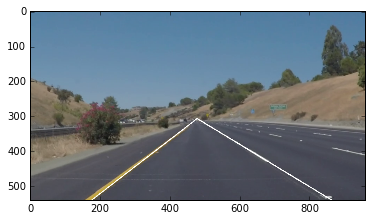

In [178]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [179]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))